### Imports

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
from helper import *
import numpy as np
from sklearn.metrics import mean_squared_error
from datetime import datetime, timezone, timedelta
from scipy.stats import spearmanr
import math

### Specify feed for analysis

In [2]:
feed = "link-eth"
network = "ethereum/mainnet"
# Get feed name in Binance's format
binance_feed = feed.upper().replace("-", "")


### Read config to read RPC endpoint

In [3]:
# Read config
with open('config.json', 'r') as file:
    config = json.load(file)

# Provider URLS
provider_url_archive = config[network.split('/')[0]]["providerUrlArchive"]
provider_url_archive


'https://mainnet.infura.io/v3/c33cd19bb3294a99aa81bc0e8131d75f'

### Load Binance Prices 
The below cell also does the following
* Calculate UTC date from timestamp
* Use Open as the price

In [4]:
# Load binance data
with open('data/binance/binance_data_'+binance_feed+'.json', 'r') as file:
    data = json.load(file)

# Create a DataFrame from the loaded data
binance_df = pd.DataFrame(data)
# Get date from timestamp
binance_df["Date"] = pd.to_datetime(binance_df['Timestamp'], unit='ms', utc=True)
binance_df["timestamp"] = binance_df['Timestamp']
binance_df["answer"] = binance_df['Open']


### Load Chainlink aggregated Prices 
The below cell also does the following
* Calculate UTC date from timestamp

In [5]:
# Load prices from CL
path = "./data/"+network+"/crypto-eth/"+feed
    
cl_df = pd.read_csv(path+"/answers.csv")
cl_df["timestamp"] = cl_df["timestamp"] * 1000
cl_df["date"] = pd.to_datetime(cl_df['timestamp'], unit='ms', utc=True)


In [6]:
binance_df

Timestamp        Open        High         Low       Close  \
0        1609459200000  0.01525000  0.01525000  0.01525000  0.01525000   
1        1609459260000  0.01522600  0.01522600  0.01522500  0.01522500   
2        1609459320000  0.01522500  0.01522500  0.01519400  0.01519400   
3        1609459380000  0.01519400  0.01519400  0.01519400  0.01519400   
4        1609459440000  0.01520000  0.01520100  0.01518100  0.01518100   
...                ...         ...         ...         ...         ...   
1371911  1692269880000  0.00379800  0.00379800  0.00379800  0.00379800   
1371912  1692269940000  0.00379600  0.00379600  0.00379600  0.00379600   
1371913  1692270000000  0.00379700  0.00379700  0.00379700  0.00379700   
1371914  1692270060000  0.00379700  0.00379700  0.00379700  0.00379700   
1371915  1692270120000  0.00379700  0.00379700  0.00379700  0.00379700   

               Volume                      Date      timestamp      answer  
0        132.56000000 2021-01-01 00:00:00+00:00  1609459200000  0.01525000  
1         27.07000000 2021-01-01 00:01:00+00:00  1609459260000  0.01522600  
2         36.09000000 2021-01-01 00:02:00+00:00  1609459320000  0.01522500  
3          0.00000000 2021-01-01 00:03:00+00:00  1609459380000  0.01519400  
4         65.58000000 2021-01-01 00:04:00+00:00  1609459440000  0.01520000  
...               ...                       ...            ...         ...  
1371911    0.00000000 2023-08-17 10:58:00+00:00  1692269880000  0.00379800  
1371912   15.24000000 2023-08-17 10:59:00+00:00  1692269940000  0.00379600  
1371913    3.70000000 2023-08-17 11:00:00+00:00  1692270000000  0.00379700  
1371914    0.00000000 2023-08-17 11:01:00+00:00  1692270060000  0.00379700  
1371915    0.00000000 2023-08-17 11:02:00+00:00  1692270120000  0.00379700  

[1371916 rows x 9 columns]

In [7]:
cl_df

Unnamed: 0      timestamp    answer                     txDate  \
0              0  1615457912000  0.016590  2021-03-11 10:18:32+00:00   
1              1  1615472456000  0.016406  2021-03-11 14:20:56+00:00   
2              2  1615496743000  0.016241  2021-03-11 21:05:43+00:00   
3              3  1615499335000  0.016415  2021-03-11 21:48:55+00:00   
4              4  1615552052000  0.016250  2021-03-12 12:27:32+00:00   
...          ...            ...       ...                        ...   
7737        7737  1692308807000  0.003717  2023-08-17 21:46:47+00:00   
7738        7738  1692309011000  0.003765  2023-08-17 21:50:11+00:00   
7739        7739  1692313007000  0.003692  2023-08-17 22:56:47+00:00   
7740        7740  1692326543000  0.003654  2023-08-18 02:42:23+00:00   
7741        7741  1692340367000  0.003692  2023-08-18 06:32:47+00:00   

                          date  
0    2021-03-11 10:18:32+00:00  
1    2021-03-11 14:20:56+00:00  
2    2021-03-11 21:05:43+00:00  
3    2021-03-11 21:48:55+00:00  
4    2021-03-12 12:27:32+00:00  
...                        ...  
7737 2023-08-17 21:46:47+00:00  
7738 2023-08-17 21:50:11+00:00  
7739 2023-08-17 22:56:47+00:00  
7740 2023-08-18 02:42:23+00:00  
7741 2023-08-18 06:32:47+00:00  

[7742 rows x 5 columns]

### Keep only Binance prices within the range of Chainlink prices

This is done to remove any additional Binance prices as oly want to compare Chainlik's prices with Binance's prices for when Chainlink prices are available

In [8]:
# KEEP ONLY COMMON RANGE
min_timestamp = cl_df['timestamp'].min()
max_timestamp = cl_df['timestamp'].max()

# Filter binance based on the timestamp range
filtered_binance = binance_df[(binance_df['timestamp'] >= min_timestamp-1200000) & (binance_df['timestamp'] <= max_timestamp+1200000)]
filtered_binance["date"] = pd.to_datetime(filtered_binance['timestamp'], unit='ms', utc=True)

/var/folders/6d/ynz59d513w3c9z0gdzpcf9100000gp/T/ipykernel_66880/2272709797.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_binance["date"] = pd.to_datetime(filtered_binance['timestamp'], unit='ms', utc=True)


In [9]:
filtered_binance.head(60)


Timestamp        Open        High         Low       Close  \
99790  1615456740000  0.01658000  0.01658000  0.01658000  0.01658000   
99791  1615456800000  0.01657700  0.01659700  0.01657300  0.01659500   
99792  1615456860000  0.01659500  0.01659500  0.01659500  0.01659500   
99793  1615456920000  0.01658600  0.01659400  0.01658600  0.01659400   
99794  1615456980000  0.01659400  0.01660500  0.01659400  0.01660500   
99795  1615457040000  0.01660500  0.01660500  0.01660500  0.01660500   
99796  1615457100000  0.01658700  0.01660300  0.01658700  0.01660300   
99797  1615457160000  0.01658700  0.01659500  0.01658400  0.01659500   
99798  1615457220000  0.01660000  0.01660500  0.01659500  0.01659500   
99799  1615457280000  0.01660500  0.01660900  0.01659000  0.01659000   
99800  1615457340000  0.01659500  0.01659500  0.01658900  0.01658900   
99801  1615457400000  0.01660400  0.01661300  0.01660400  0.01661300   
99802  1615457460000  0.01661300  0.01661300  0.01659500  0.01659500   
99803  1615457520000  0.01659500  0.01659500  0.01659500  0.01659500   
99804  1615457580000  0.01659500  0.01659500  0.01659500  0.01659500   
99805  1615457640000  0.01658700  0.01658700  0.01658400  0.01658600   
99806  1615457700000  0.01658600  0.01658600  0.01658600  0.01658600   
99807  1615457760000  0.01658600  0.01658600  0.01658600  0.01658600   
99808  1615457820000  0.01657600  0.01657600  0.01656800  0.01657600   
99809  1615457880000  0.01658500  0.01659100  0.01657200  0.01657500   
99810  1615457940000  0.01659300  0.01659500  0.01659300  0.01659500   
99811  1615458000000  0.01659500  0.01659500  0.01659500  0.01659500   
99812  1615458060000  0.01659800  0.01660500  0.01659800  0.01660500   
99813  1615458120000  0.01660500  0.01660500  0.01660500  0.01660500   
99814  1615458180000  0.01660500  0.01660900  0.01658400  0.01660000   
99815  1615458240000  0.01660100  0.01661800  0.01657900  0.01657900   
99816  1615458300000  0.01660000  0.01660100  0.01660000  0.01660100   
99817  1615458360000  0.01659100  0.01660100  0.01659100  0.01660100   
99818  1615458420000  0.01661400  0.01661700  0.01661400  0.01661600   
99819  1615458480000  0.01661600  0.01662900  0.01661600  0.01662900   
99820  1615458540000  0.01661200  0.01662800  0.01661200  0.01662800   
99821  1615458600000  0.01662800  0.01662800  0.01662800  0.01662800   
99822  1615458660000  0.01662200  0.01662200  0.01662200  0.01662200   
99823  1615458720000  0.01662200  0.01662200  0.01662200  0.01662200   
99824  1615458780000  0.01662900  0.01663700  0.01662900  0.01663700   
99825  1615458840000  0.01663700  0.01664500  0.01663200  0.01664500   
99826  1615458900000  0.01663400  0.01663400  0.01663400  0.01663400   
99827  1615458960000  0.01663200  0.01664400  0.01663100  0.01664300   
99828  1615459020000  0.01662700  0.01662700  0.01660900  0.01660900   
99829  1615459080000  0.01660800  0.01660800  0.01660400  0.01660400   
99830  1615459140000  0.01660400  0.01660400  0.01660400  0.01660400   
99831  1615459200000  0.01662500  0.01662600  0.01662500  0.01662600   
99832  1615459260000  0.01662600  0.01662600  0.01662600  0.01662600   
99833  1615459320000  0.01662600  0.01662600  0.01662600  0.01662600   
99834  1615459380000  0.01662000  0.01662000  0.01660900  0.01660900   
99835  1615459440000  0.01662600  0.01663200  0.01659600  0.01661800   
99836  1615459500000  0.01662300  0.01662300  0.01662300  0.01662300   
99837  1615459560000  0.01663200  0.01663200  0.01663200  0.01663200   
99838  1615459620000  0.01663500  0.01663500  0.01663500  0.01663500   
99839  1615459680000  0.01664100  0.01664900  0.01664100  0.01664900   
99840  1615459740000  0.01664900  0.01665000  0.01664900  0.01665000   
99841  1615459800000  0.01665000  0.01665000  0.01665000  0.01665000   
99842  1615459860000  0.01665000  0.01665000  0.01665000  0.01665000   
99843  1615459920000  0.01664700  0.01665000  0.01664700  0.01665000   
99844  1615459980000  0.01665000  0.01665000  0.016

### Merge Chainlink's Prices with Binance's prices in one DataFrame

This is done by merging Binance prices with Chainlink prices based on Chainlink's price timestamp. Basically, a record consist of a Chainlink price with a Binance price at the same minute as the timestamp of the Chailink's price.

In [10]:
# Merge prices on chainlink's data points
merged_df = pd.merge_asof(cl_df, filtered_binance, on='timestamp', suffixes=('_cl', '_binance'))
merged_df = merged_df[["timestamp", "answer_cl", "answer_binance"]]
merged_df["answer_cl"] = merged_df["answer_cl"].astype(float)
merged_df["answer_binance"] = merged_df["answer_binance"].astype(float)
merged_df['percentage_change'] = (abs(merged_df['answer_cl'] - merged_df['answer_binance']) / merged_df['answer_binance']) * 100
merged_df["date"] = pd.to_datetime(merged_df['timestamp'], unit='ms', utc=True)
merged_df.set_index('date', inplace=True)
merged_df["date"] = merged_df.index
print(merged_df)

                               timestamp  answer_cl  answer_binance  \
date                                                                  
2021-03-11 10:18:32+00:00  1615457912000   0.016590        0.016585   
2021-03-11 14:20:56+00:00  1615472456000   0.016406        0.016364   
2021-03-11 21:05:43+00:00  1615496743000   0.016241        0.016186   
2021-03-11 21:48:55+00:00  1615499335000   0.016415        0.016512   
2021-03-12 12:27:32+00:00  1615552052000   0.016250        0.016232   
...                                  ...        ...             ...   
2023-08-17 21:46:47+00:00  1692308807000   0.003717        0.003797   
2023-08-17 21:50:11+00:00  1692309011000   0.003765        0.003797   
2023-08-17 22:56:47+00:00  1692313007000   0.003692        0.003797   
2023-08-18 02:42:23+00:00  1692326543000   0.003654        0.003797   
2023-08-18 06:32:47+00:00  1692340367000   0.003692        0.003797   

                           percentage_change                      date  
dat

### Plot Chainlink's Prices with Binance's Prices

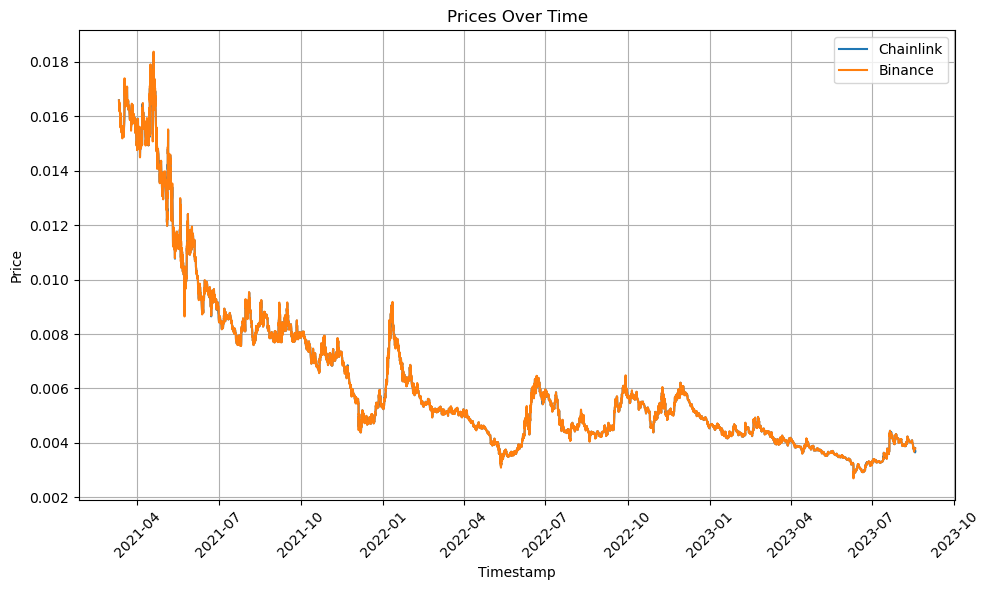

In [11]:
# Plot using Matplotlib
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
plt.plot(merged_df.index, merged_df['answer_cl'], label='Chainlink')
plt.plot(merged_df.index, merged_df['answer_binance'], label='Binance')
plt.title('Prices Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

### Plot the Percentage Difference between Chainlink's Prices and Binance's Prices

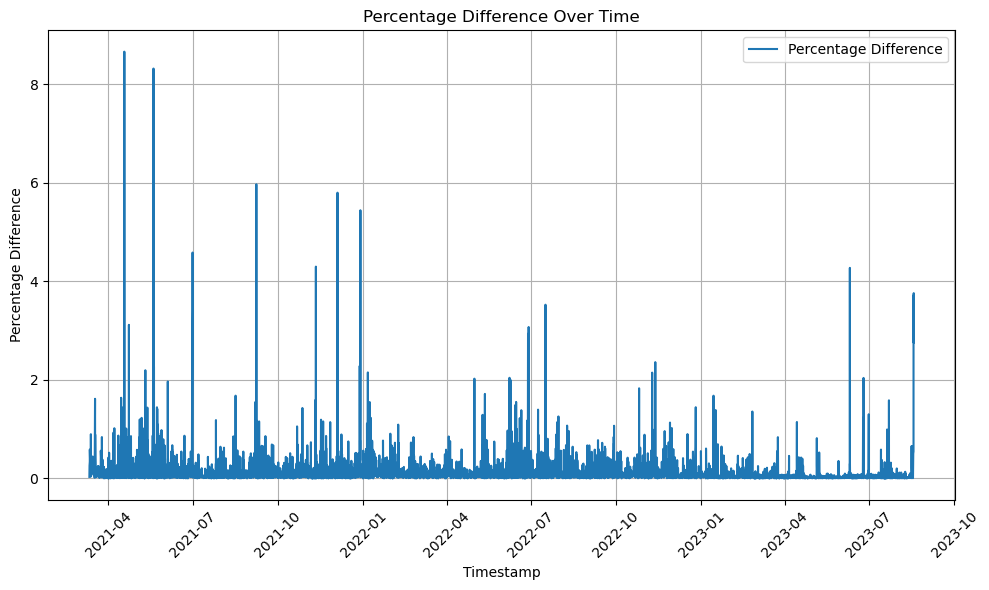

In [12]:
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
plt.plot(merged_df.index, merged_df['percentage_change'], label='Percentage Difference')
plt.title('Percentage Difference Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Percentage Difference')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Get the aggregator contract for the specified feed

In [13]:
# Get aggregator contract

# Load feeds
with open('data/feeds.json', 'r') as file:
    # load the contents of the file into a dictionary
    feeds = json.load(file)
    
# Read ABI
with open('abi/aggregator_abi.json', 'r') as file:
    contract_abi = json.load(file)
    
feed_path = network+"/"+feed
feed_details = feeds[feed_path]

w3_archive = Web3(Web3.HTTPProvider(provider_url_archive))
aggregator_contract_address = feed_details["address"]
contract, events = create_contract(w3_archive, aggregator_contract_address, contract_abi)
decimals = contract.functions.decimals().call()                                                                                                                                         

### Merge each operator's submissions with Binance's prices in one DataFrame

As was done when creating a dataframe with Chainlink's aggregated prices and Binance's prices. This is done by merging Binance prices with each operator's submissions based on the submission's timestamp. Basically, a record consist of a submission price with a Binance price at the same minute as the timestamp of the submission's price. A dataframe per operator is created

In [14]:
# Create DF's with each operator's deviation from binance
op_devs = {}

path = "data/"+network+"/crypto-eth/"+feed+"/per_op"
# Get a list of all directory names in the specified directory
operator_names = [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]

for op in operator_names:
    # Get submissions CSV
    op_submissions = pd.read_csv(path+"/"+op+"/submissions.csv")
    op_submissions = op_submissions[["timestamp", op+"_answer"]]
    op_submissions.rename(columns={op+"_answer": 'answer'}, inplace=True)
    op_submissions["answer"] = op_submissions["answer"] / (10 ** decimals)
    op_submissions['timestamp'] = op_submissions['timestamp'] * 1000
    op_submissions["date"] = pd.to_datetime(op_submissions['timestamp'], unit='ms', utc=True)
    
    # Merge with binance's prices
    op_merged_df = pd.merge_asof(op_submissions, filtered_binance, on='timestamp', suffixes=('_cl', '_binance'))
    op_merged_df = op_merged_df[["timestamp", "answer_cl", "answer_binance"]]
    op_merged_df["answer_cl"] = op_merged_df["answer_cl"].astype(float)
    op_merged_df["answer_binance"] = op_merged_df["answer_binance"].astype(float)
    op_merged_df['percentage_change'] = (abs(op_merged_df['answer_cl'] - op_merged_df['answer_binance']) / op_merged_df['answer_binance']) * 100
    op_merged_df["date"] = pd.to_datetime(op_merged_df['timestamp'], unit='ms', utc=True)
    op_merged_df.set_index('date', inplace=True)
    
    # Add to list of DataFrames
    op_devs[op] = op_merged_df

### From each operator's dataframe consisting of submitted prices and Binance's price, extract deviations

Here we extract the following per operator:
* The average deviation
* The minimum deviation
* The maximum deviation

In [15]:
# Calculate average, max and minimum percentage differences in a separate DFs
op_data = {
    "average_deviation": {},
    "minimum_deviation": {},
    "maximum_deviation": {}
}

for op in op_devs:
    op_data["average_deviation"][op] = op_devs[op]["percentage_change"].mean()
    op_data["maximum_deviation"][op] = op_devs[op]["percentage_change"].max()    
    op_data["minimum_deviation"][op] = op_devs[op]["percentage_change"].min()    

In [16]:
op_data

{'average_deviation': {'ztake_org': 0.3519258092751992,
  'easy_2_stake': 0.17891228298452874,
  'syncnode': 0.23144959731108497,
  'wetez': 0.1688952767146543,
  'linkforest': 0.16675001813192541,
  'staking_facilities': 0.24766615445215895,
  'linkpool': 0.31061064398751714,
  'xbto': 0.19525592813053597,
  'prophet': 0.21087785088987293,
  'blockdaemon': 0.38664077145648695,
  'kytzu': 0.30758814225106434,
  'deutsche_telekom_mms': 0.3626472831270695,
  'dextrac': 0.232366384977757,
  'blocksize_capital': 0.38556475853393224,
  '01node': 0.3590919502666662,
  'figment_networks': 0.2515504352439225},
 'minimum_deviation': {'ztake_org': 0.0,
  'easy_2_stake': 0.0,
  'syncnode': 0.0,
  'wetez': 0.0,
  'linkforest': 0.0,
  'staking_facilities': 0.0,
  'linkpool': 0.0,
  'xbto': 0.0,
  'prophet': 0.0,
  'blockdaemon': 0.0,
  'kytzu': 0.0,
  'deutsche_telekom_mms': 0.0,
  'dextrac': 0.0,
  'blocksize_capital': 0.0,
  '01node': 0.0012135922330025013,
  'figment_networks': 0.0},
 'maximum_d

In [17]:
# Change these deviations into a DataFrame
df = pd.DataFrame(op_data)
df

average_deviation  minimum_deviation  maximum_deviation
ztake_org                      0.351926           0.000000           8.143443
easy_2_stake                   0.178912           0.000000           9.865300
syncnode                       0.231450           0.000000          10.203174
wetez                          0.168895           0.000000          10.203174
linkforest                     0.166750           0.000000          13.367990
staking_facilities             0.247666           0.000000          12.981764
linkpool                       0.310611           0.000000          10.266083
xbto                           0.195256           0.000000           9.652367
prophet                        0.210878           0.000000          10.289276
blockdaemon                    0.386641           0.000000          14.454502
kytzu                          0.307588           0.000000          13.300801
deutsche_telekom_mms           0.362647           0.000000          14.454502
dextrac                        0.232366           0.000000          10.851690
blocksize_capital              0.385565           0.000000         136.851841
01node                         0.359092           0.001214           3.769818
figment_networks               0.251550           0.000000           9.310284

### Getting unique withdrawal dates by non payee addresses

In the cell below, the unique withdrawal dates by non payee addresses are obtained. These are useful as these will be the separators between periods to be analysed. The reason to only use dates for withdrawals made by Chainlink is that Chainlink withdraws for all operators at once, making analysis easier since the periods for analysis would be similar for each operator.

These are obtained by:
* Loading all the withdrawals
* Loading all the operators' addresses
* Calculating a UTC date from the withdrawal timestamps
* Filtering withdrawals and keeping only withdrawals not made by operator addresses (only by Chainlink team)
* Get unique dates from these withdrawals.

In [18]:
# Load withdrawal payments
path = "./data/"+network+"/crypto-eth/"+feed
withdrawals = pd.read_csv(path+"/payments.csv")

# Keep only needed columns
withdrawals = withdrawals[["blockNumber", "txTimestamp", "submitter", "payeeAddress", "oracleName"]]

# Get all payee addresses
with open(path+'/nops.json', 'r') as json_file:
    nops = json.load(json_file)
    
payment_addresses = []
    
for nop in nops["nops_details"]:
    payment_addresses.extend(nops["nops_details"][nop]["paymentAddress"])
    

# Calculate date
withdrawals['txTimestamp'] = withdrawals['txTimestamp'] * 1000
withdrawals["date"] = pd.to_datetime(withdrawals['txTimestamp'], unit='ms', utc=True)
# Keep only when submitter is not a payee
withdrawals_by_not_payee = withdrawals[~withdrawals['submitter'].isin(payment_addresses)]

# Get unique withdrawal dates by Chainlink
unique_withdrawal_dates = withdrawals_by_not_payee["date"].unique()

### Create date ranges from the unique withdrawal periods and group together rows from the merged prices DataFrame which fall into these ranges

Here, we are basically splitting the merged DataFrame consisting of Chainlink's aggregated prices and Binance's prices into dateframes per date range

In [19]:
# Group chainlink price updates with Binance prices in ranges of withdrawal dates
range_dfs = []
ranges = []

# Iterate through timestamps and split DataFrame
for i in range(len(unique_withdrawal_dates)):
    if i == 0:
        filtered_df = merged_df[merged_df['date'] < unique_withdrawal_dates[i]]
        first_date = filtered_df.iloc[0]["date"] - timedelta(days=1)
        ranges.append(first_date.strftime("%Y-%m-%d %H:%M:%S") + " -> " + unique_withdrawal_dates[i].strftime("%Y-%m-%d %H:%M:%S"))
    else:
        filtered_df = merged_df[(merged_df['date'] >= unique_withdrawal_dates[i-1]) & (merged_df['date'] < unique_withdrawal_dates[i])]
        ranges.append(unique_withdrawal_dates[i-1].strftime("%Y-%m-%d %H:%M:%S") + " -> " + unique_withdrawal_dates[i].strftime("%Y-%m-%d %H:%M:%S"))
    range_dfs.append(filtered_df)

# Include rows after the last timestamp in the last group
last_group = merged_df[merged_df['date'] >= unique_withdrawal_dates[-1]]
last_date = filtered_df.iloc[-1]["date"] + timedelta(days=1)
ranges.append(unique_withdrawal_dates[i].strftime("%Y-%m-%d %H:%M:%S") + " -> " + last_date.strftime("%Y-%m-%d %H:%M:%S"))
range_dfs.append(last_group)

### Calculate deviations for each range

For each range, calculate the following:
* Average deviation
* Maximum deviation
* Minimum deviation
* Number of Chainlink price updates
* Mean Absolute Percentage Error
* Root Mean Square Error

These are needed to choose the most accurate periods (the periods in which Chainlink's aggrregated prices are closes to Binance's prices)

In [20]:
# For each range, calculate average, min and max differences
range_data = {
    "average_deviation": {},
    "maximum_deviation": {},
    "minimum_deviation": {},
    "price_updates": {},
    "mean_absolute_percentage_error": {},
    "root_mean_square_error": {}
}

# Calculate MAPE
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100


for index,df in enumerate(range_dfs):
    range_data["average_deviation"][ranges[index]] = df["percentage_change"].mean()
    range_data["maximum_deviation"][ranges[index]] = df["percentage_change"].max()    
    range_data["minimum_deviation"][ranges[index]] = df["percentage_change"].min()    
    range_data["price_updates"][ranges[index]] = df["percentage_change"].count()   
    range_data["mean_absolute_percentage_error"][ranges[index]] = calculate_mape(df['answer_cl'], df['answer_binance'])
    range_data["root_mean_square_error"][ranges[index]] = np.sqrt(mean_squared_error(df['answer_cl'], df['answer_binance']))
    
range_data_df = pd.DataFrame(range_data)
range_data_df = range_data_df.sort_values(by='average_deviation')

print("Average MAPE: "+str(range_data_df["mean_absolute_percentage_error"].mean()))
print("Average RMSE: "+str(range_data_df["root_mean_square_error"].mean()))
print("Average maximum deviation: "+str(range_data_df["maximum_deviation"].mean()))
print("Average price updates: "+str(range_data_df["price_updates"].median()))

Average MAPE: 0.16583129861442092
Average RMSE: 1.9642558396073696e-05
Average maximum deviation: 1.1692841839352064
Average price updates: 48.0


In [21]:
range_data_df.head(20)

average_deviation  \
2021-12-07 04:31:27 -> 2021-12-07 12:23:40           0.010483   
2023-05-08 18:51:11 -> 2023-05-15 18:27:23           0.021074   
2023-04-24 16:42:59 -> 2023-05-01 20:51:11           0.021965   
2023-08-04 13:12:11 -> 2023-08-07 16:23:35           0.027045   
2023-05-30 18:01:23 -> 2023-06-06 12:22:35           0.027211   
2023-03-28 11:11:23 -> 2023-04-03 18:09:35           0.027435   
2023-05-15 18:27:23 -> 2023-05-23 12:06:47           0.028074   
2023-08-07 16:23:35 -> 2023-08-14 17:34:59           0.031028   
2023-06-13 14:13:23 -> 2023-06-20 14:08:59           0.031696   
2023-05-23 12:06:47 -> 2023-05-30 18:01:23           0.033492   
2023-07-03 13:31:59 -> 2023-07-11 13:14:23           0.034299   
2023-07-31 19:05:11 -> 2023-08-04 13:12:11           0.039246   
2023-04-03 18:09:35 -> 2023-04-10 13:03:59           0.043264   
2023-02-28 13:23:23 -> 2023-03-06 17:12:47           0.043265   
2023-03-06 17:12:47 -> 2023-03-13 20:18:47           0.049480   
2023-07-23 05:03:23 -> 2023-07-24 18:49:23           0.053829   
2023-01-27 16:15:59 -> 2023-02-07 17:55:35           0.054267   
2023-07-24 18:49:23 -> 2023-07-31 19:05:11           0.057372   
2021-07-08 18:19:45 -> 2021-07-15 21:51:20           0.058822   
2022-10-17 18:34:35 -> 2022-10-19 14:55:11           0.064904   

                                            maximum_deviation  \
2021-12-07 04:31:27 -> 2021-12-07 12:23:40           0.010483   
2023-05-08 18:51:11 -> 2023-05-15 18:27:23           0.062460   
2023-04-24 16:42:59 -> 2023-05-01 20:51:11           0.075465   
2023-08-04 13:12:11 -> 2023-08-07 16:23:35           0.080659   
2023-05-30 18:01:23 -> 2023-06-06 12:22:35           0.096997   
2023-03-28 11:11:23 -> 2023-04-03 18:09:35           0.081328   
2023-05-15 18:27:23 -> 2023-05-23 12:06:47           0.097614   
2023-08-07 16:23:35 -> 2023-08-14 17:34:59           0.134429   
2023-06-13 14:13:23 -> 2023-06-20 14:08:59           0.085585   
2023-05-23 12:06:47 -> 2023-05-30 18:01:23           0.353909   
2023-07-03 13:31:59 -> 2023-07-11 13:14:23           0.120595   
2023-07-31 19:05:11 -> 2023-08-04 13:12:11           0.119163   
2023-04-03 18:09:35 -> 2023-04-10 13:03:59           0.456782   
2023-02-28 13:23:23 -> 2023-03-06 17:12:47           0.250355   
2023-03-06 17:12:47 -> 2023-03-13 20:18:47           0.216419   
2023-07-23 05:03:23 -> 2023-07-24 18:49:23           0.319570   
2023-01-27 16:15:59 -> 2023-02-07 17:55:35           0.251675   
2023-07-24 18:49:23 -> 2023-07-31 19:05:11           0.207633   
2021-07-08 18:19:45 -> 2021-07-15 21:51:20           0.206692   
2022-10-17 18:34:35 -> 2022-10-19 14:55:11           0.140055   

                                            minimum_deviation  price_updates  \
2021-12-07 04:31:27 -> 2021-12-07 12:23:40           0.010483              1   
2023-05-08 18:51:11 -> 2023-05-15 18:27:23           0.002789             30   
2023-04-24 16:42:59 -> 2023-05-01 20:51:11           0.000000             34   
2023-08-04 13:12:11 -> 2023-08-07 16:23:35           0.003963             14   
2023-05-30 18:01:23 -> 2023-06-06 12:22:35           0.003017             28   
2023-03-28 11:11:23 -> 2023-04-03 18:09:35           0.000000             34   
2023-05-15 18:27:23 -> 2023-05-23 12:06:47           0.000462             35   
2023-08-07 16:23:35 -> 2023-08-14 17:34:59           0.000531             38   
2023-06-13 14:13:23 -> 2023-06-20 14:08:59           0.000000             36   
2023-05-23 12:06:47 -> 2023-05-30 18:01:23           0.000784             31   
2023-07-03 13:31:59 -> 2023-07-11 13:14:23           0.000491             36   
2023-07-31 19:05:11 -> 2023-08-04 13:12:11           0.001365             21   
2023-04-03 18:09:35 -> 2023-04-10 13:03:59           0.000000             32   
2023-02-28 13:23:23 -> 2023-03-06 17:12:47           0.000000             31   
2023-03-06 17:12:47 -> 2023-03-13 20:18:47           0.000000             43   
2023-07-23 05:03:23 -> 2023-07-2

### Hard Code Chosen periods

In [22]:
# Hard code chosen periods
chosen_periods = [
    {
        "from": "2023-05-08 18:51:11",
        "to": "2023-05-15 18:27:23"
    },
    {
        "from": "2023-04-24 16:42:59",
        "to": "2023-05-01 20:51:11"
    },
    {
        "from": "2023-03-28 11:11:23",
        "to": "2023-04-03 18:09:35"
    },
    {
        "from": "2023-05-15 18:27:23",
        "to": "2023-05-23 12:06:47"
    },
    {
        "from": "2023-08-07 16:23:35",
        "to": "2023-08-14 17:34:59"
    }
]

# Load all submissions
path = "./data/"+network+"/crypto-eth/"+feed
all_transmissions = pd.read_csv(path+"/transmissions.csv")
all_transmissions["timestamp"] = all_transmissions["timestamp"] * 1000
all_transmissions["date"] = pd.to_datetime(all_transmissions['timestamp'], unit='ms', utc=True)
all_transmissions = all_transmissions.fillna(0)


### Calculate each operator's performances in each of the chosen periods

Just as we calculated the deviations between Chainlink's prices and Binance's prices, we will now calculate deviation metrics for each operator from both Binance's prices and Chainlink's aggregated prices for each of the chosen periods

For each operator per chosen period we will be calculating the following against both Chainlink's aggregated prices and Binance's prices:
* Mean Absolute Percentage Error
* Root Mean Square Error
* Maximum Deviation
* Missed submissions
* Completed submissions
* Completed transmissions


In [23]:
# For each period, compute each operator's mape, rsme and max deviation averages and missed submissions for both CL and Binance

op_data_periods = {}
op_data_periods_cl = {}

for period in chosen_periods:
    period_key = period["from"] +" -> "+period["to"]
    op_data_periods[period_key] = {
        "mape": {},
        "rmse": {},
        "maximum_deviation": {},
        "missed_submissions": {},
        "completed_submissions": {},
        "completed_transmissions": {}
    }
    
    op_data_periods_cl[period_key] = {
        "mape": {},
        "rmse": {},
        "maximum_deviation": {},
        "missed_submissions": {},
        "completed_submissions": {},
        "completed_transmissions": {}
    }
    
    from_date = datetime.strptime(period["from"], "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc)
    to_date = datetime.strptime(period["to"], "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc)
    for op in operator_names:
        # Get submissions CSV
        op_submissions = pd.read_csv(path+"/per_op/"+op+"/submissions.csv")
        op_submissions = op_submissions[["timestamp", op+"_answer"]]
        op_submissions.rename(columns={op+"_answer": 'answer'}, inplace=True)
        op_submissions["answer"] = op_submissions["answer"] / (10 ** decimals)
        op_submissions['timestamp'] = op_submissions['timestamp'] * 1000
        op_submissions["date"] = pd.to_datetime(op_submissions['timestamp'], unit='ms', utc=True)
        op_submissions = op_submissions.dropna(subset=["answer"])
        # Keep only rows in given period
        op_submissions = op_submissions[(op_submissions['date'] >= from_date) & (op_submissions['date'] < to_date)]
        
        if len(op_submissions) > 0:
        
            # Get only transmissions in the period
            transmissions_in_period = all_transmissions[(all_transmissions['date'] >= from_date) & (all_transmissions['date'] <= to_date)]
            # Count missed submissions
            missed_submissions = len(transmissions_in_period[transmissions_in_period[op+"_answer"] == 0])
            # Count submissions
            completed_submissions = len(transmissions_in_period[transmissions_in_period[op+"_answer"] != 0])

            # Count transmissions
            completed_transmissions = 0;
            # Loop through submissions
            for index, row in transmissions_in_period.iterrows():
                submitter = row["submitter"]
                if op == nops["nops_details"][submitter.lower()]["name"]:
                    completed_transmissions += 1


            # Merge with binance's prices
            op_merged_df = pd.merge_asof(op_submissions, filtered_binance, on='timestamp', suffixes=('_cl', '_binance'))
            op_merged_df = op_merged_df[["timestamp", "answer_cl", "answer_binance"]]
            op_merged_df["answer_cl"] = op_merged_df["answer_cl"].astype(float)
            op_merged_df["answer_binance"] = op_merged_df["answer_binance"].astype(float)
            op_merged_df['percentage_change'] = (abs(op_merged_df['answer_cl'] - op_merged_df['answer_binance']) / op_merged_df['answer_binance']) * 100
            op_merged_df["date"] = pd.to_datetime(op_merged_df['timestamp'], unit='ms', utc=True)
            op_merged_df.set_index('date', inplace=True)
            
            # Merge with Chainlink's aggregated prices
            op_merged_df_cl = pd.merge_asof(op_submissions, cl_df, on='timestamp', suffixes=('_operator', '_cl'))
            op_merged_df_cl = op_merged_df_cl[["timestamp", "answer_operator", "answer_cl"]]
            op_merged_df_cl["answer_operator"] = op_merged_df_cl["answer_operator"].astype(float)
            op_merged_df_cl["answer_cl"] = op_merged_df_cl["answer_cl"].astype(float)
            op_merged_df_cl['percentage_change'] = (abs(op_merged_df_cl['answer_operator'] - op_merged_df_cl['answer_cl']) / op_merged_df_cl['answer_cl']) * 100
            op_merged_df_cl["date"] = pd.to_datetime(op_merged_df_cl['timestamp'], unit='ms', utc=True)
            op_merged_df_cl.set_index('date', inplace=True)

            # Calculate data for oeprators submissions against Binance's prices
            op_data_periods[period_key]["mape"][op] = calculate_mape(op_merged_df['answer_cl'], op_merged_df['answer_binance'])
            op_data_periods[period_key]["rmse"][op] =  np.sqrt(mean_squared_error(op_merged_df['answer_cl'], op_merged_df['answer_binance']))
            op_data_periods[period_key]["maximum_deviation"][op] =  op_merged_df['percentage_change'].max()
            op_data_periods[period_key]["missed_submissions"][op] = missed_submissions
            op_data_periods[period_key]["completed_submissions"][op] = completed_submissions
            op_data_periods[period_key]["completed_transmissions"][op] = completed_transmissions
            
            # Calculate data for oeprators submissions against Chainlink's prices
            op_data_periods_cl[period_key]["mape"][op] = calculate_mape(op_merged_df_cl['answer_operator'], op_merged_df_cl['answer_cl'])
            op_data_periods_cl[period_key]["rmse"][op] =  np.sqrt(mean_squared_error(op_merged_df_cl['answer_operator'], op_merged_df_cl['answer_cl']))
            op_data_periods_cl[period_key]["maximum_deviation"][op] =  op_merged_df_cl['percentage_change'].max()
            op_data_periods_cl[period_key]["missed_submissions"][op] = missed_submissions
            op_data_periods_cl[period_key]["completed_submissions"][op] = completed_submissions
            op_data_periods_cl[period_key]["completed_transmissions"][op] = completed_transmissions

### Output operator deviation data per period against Binance's prices and plot Bar Graphs

From the data collected, the following Bar Graphs were plotted per period:
* Operators' MAPE values agaisnt Binance's Prices 
* Operators' RMSE values agaisnt Binance's Prices 
* Operators' Maximum Deviation values agaisnt Binance's Prices 

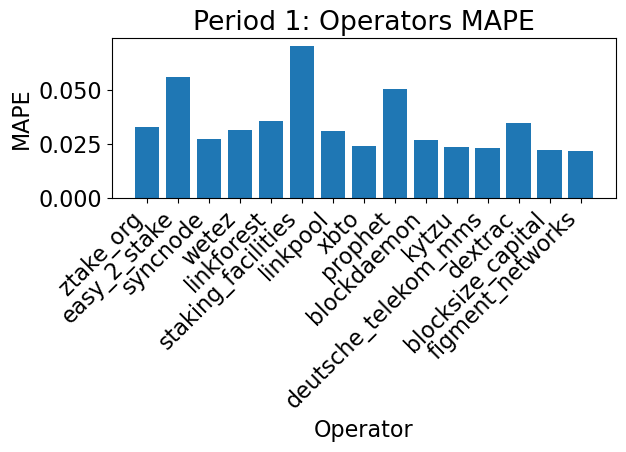

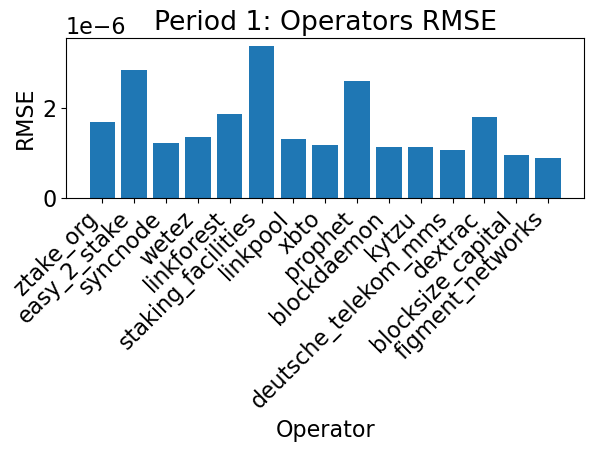

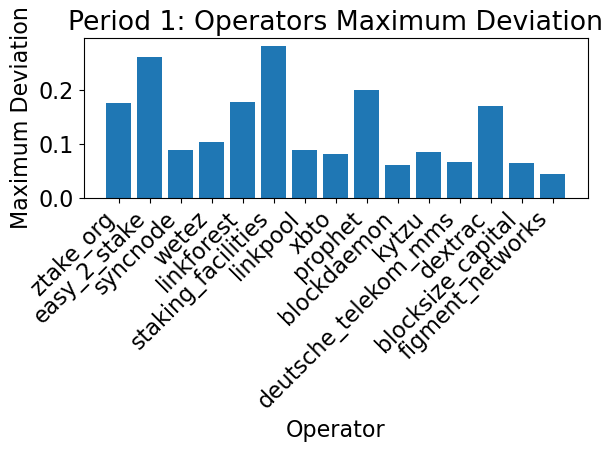

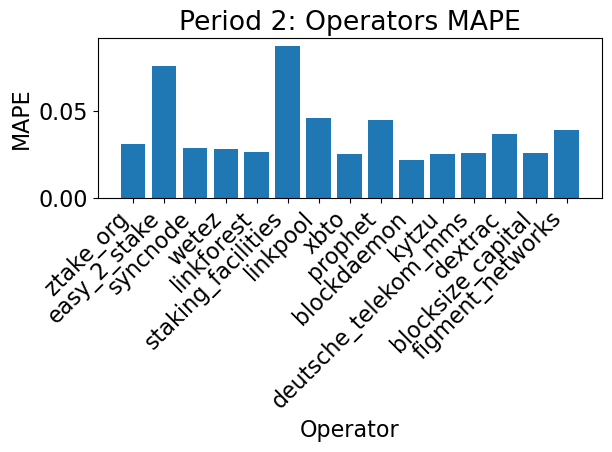

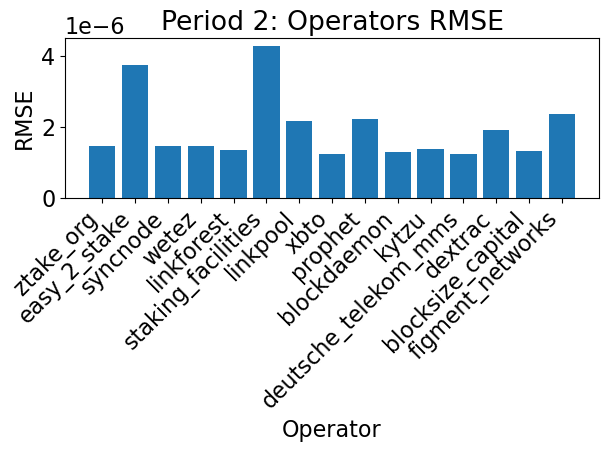

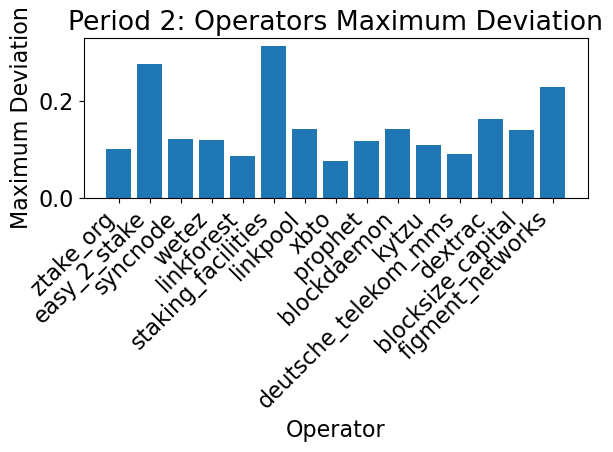

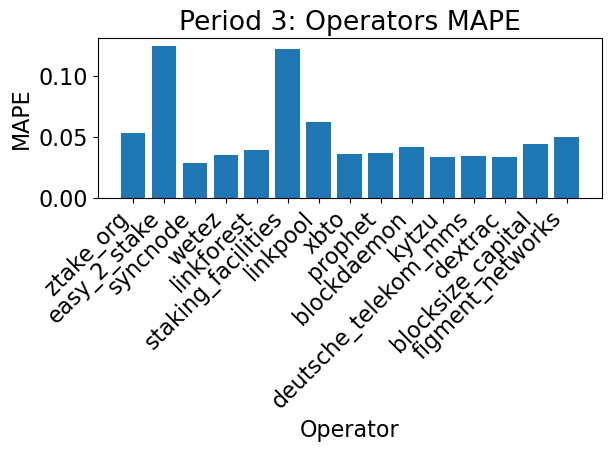

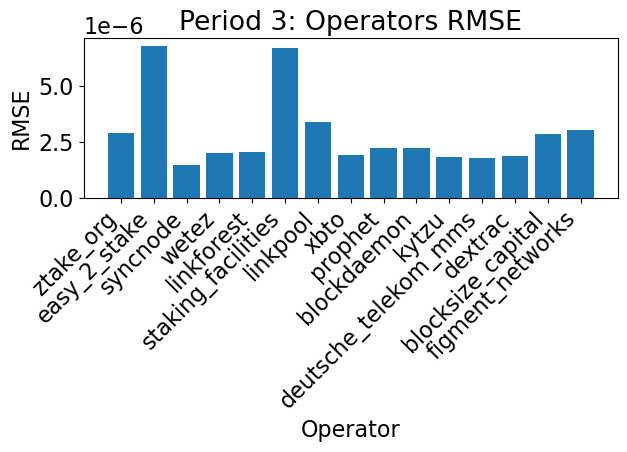

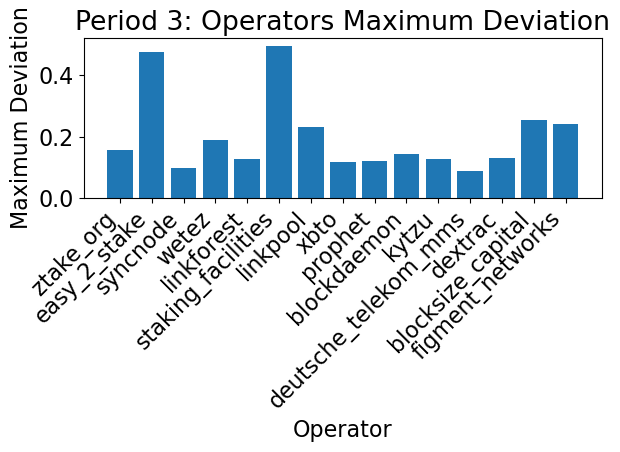

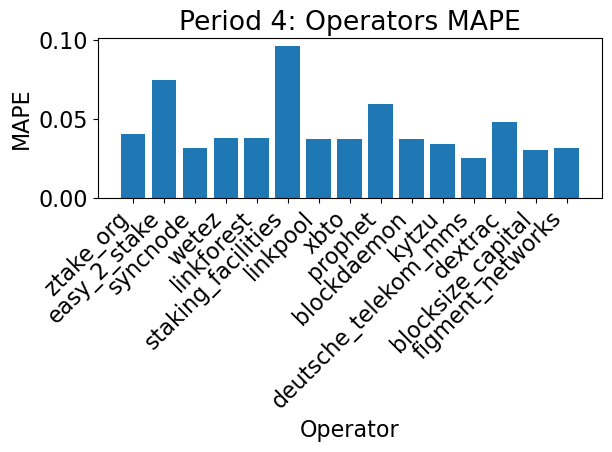

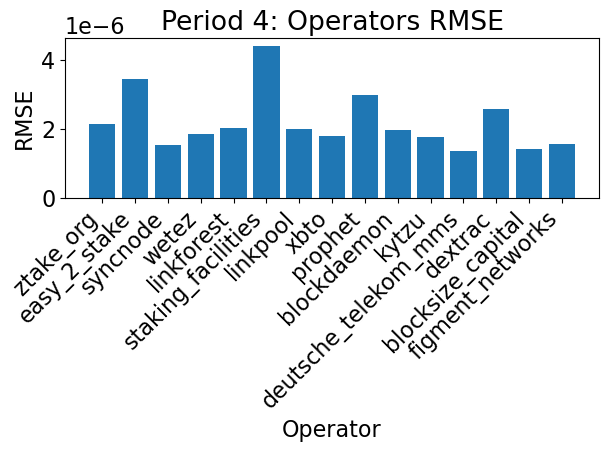

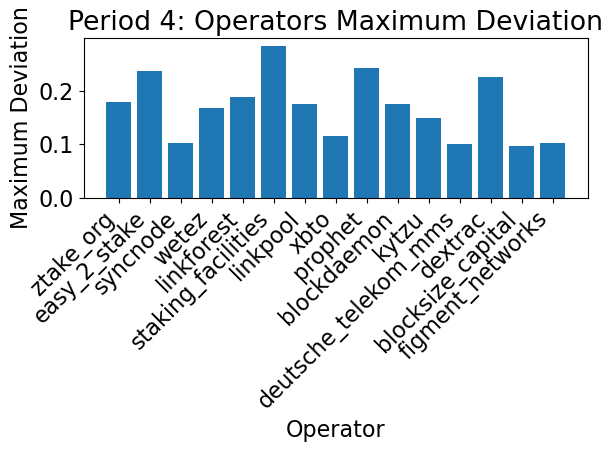

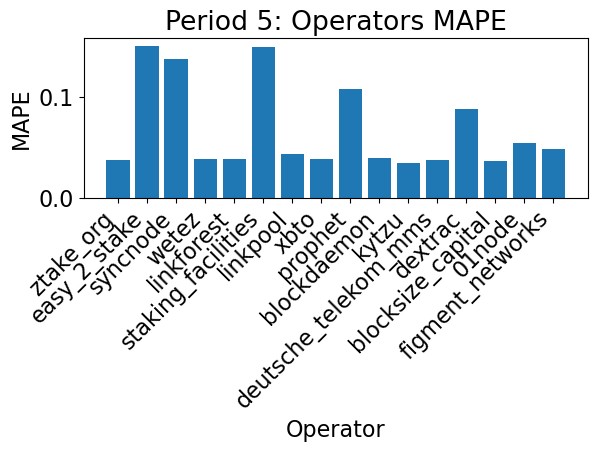

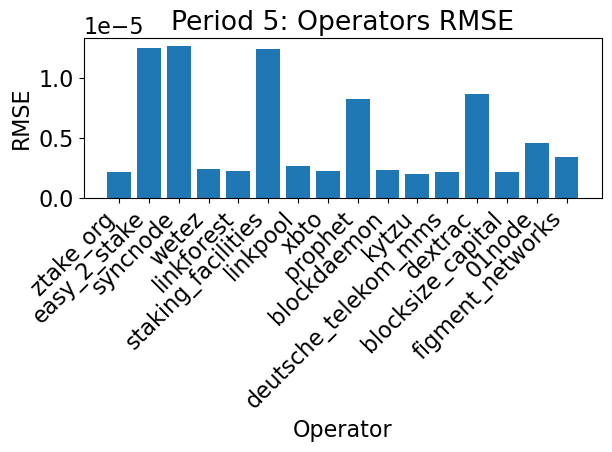

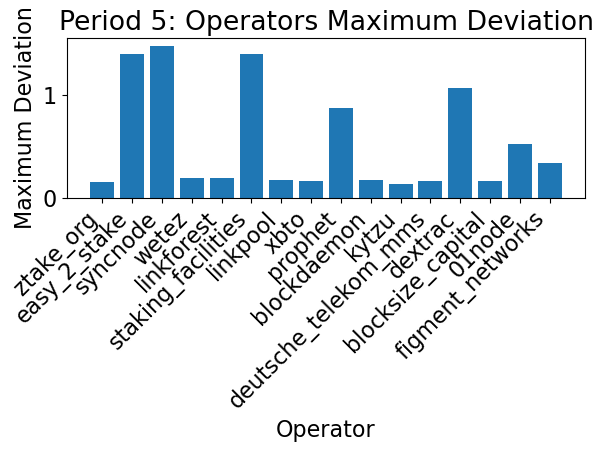

In [24]:
# This creates a DF with operators performances per period and also gathers the averages of operator performances
op_period_avgs = {}

period_op_dfs = []

for index, period in enumerate(op_data_periods):
    period_op_df = pd.DataFrame(op_data_periods[period])
    period_op_dfs.append(period_op_df)
    
    # Create a bar graph for MAPE
    plt.rcParams['font.size'] = 16
    plt.bar(period_op_df.index, period_op_df['mape'])
    plt.xlabel('Operator')
    plt.ylabel('MAPE')
    plt.title('Period '+str(index+1)+": Operators MAPE")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()  
    plt.savefig('figures/period'+str(index+1)+'_MAPE_operators.png', bbox_inches='tight')
    plt.show()
    
    # Create a bar graph for RMSE
    plt.rcParams['font.size'] = 16
    plt.bar(period_op_df.index, period_op_df['rmse'])
    plt.xlabel('Operator')
    plt.ylabel('RMSE')
    plt.title('Period '+str(index+1)+": Operators RMSE")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()  
    plt.savefig('figures/period'+str(index+1)+'_RMSE_operators.png', bbox_inches='tight')
    plt.show()
    
    # Create a bar graph for maximum deviation
    plt.rcParams['font.size'] = 16
    plt.bar(period_op_df.index, period_op_df['maximum_deviation'])
    plt.xlabel('Operator')
    plt.ylabel('Maximum Deviation')
    plt.title('Period '+str(index+1)+": Operators Maximum Deviation")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()  
    plt.savefig('figures/period'+str(index+1)+'_RSME_maximumdev.png', bbox_inches='tight')
    plt.show()
    
    op_period_avgs[period] = {
        "avg_MAPE": period_op_df["mape"].mean(),
        "avg_RMSE": period_op_df["rmse"].mean(),
        "avg_maximum_deviation": period_op_df["maximum_deviation"].mean()
    }

In [25]:
op_period_avgs

{'2023-05-08 18:51:11 -> 2023-05-15 18:27:23': {'avg_MAPE': 0.033927509569164335,
  'avg_RMSE': 1.6348103740868657e-06,
  'avg_maximum_deviation': 0.13068349241067215},
 '2023-04-24 16:42:59 -> 2023-05-01 20:51:11': {'avg_MAPE': 0.037949480930098485,
  'avg_RMSE': 1.9226408931502717e-06,
  'avg_maximum_deviation': 0.14805338432182727},
 '2023-03-28 11:11:23 -> 2023-04-03 18:09:35': {'avg_MAPE': 0.05163444151187716,
  'avg_RMSE': 2.877184211944809e-06,
  'avg_maximum_deviation': 0.20000959394249213},
 '2023-05-15 18:27:23 -> 2023-05-23 12:06:47': {'avg_MAPE': 0.043696696368736375,
  'avg_RMSE': 2.189819548209082e-06,
  'avg_maximum_deviation': 0.16971078117219746},
 '2023-08-07 16:23:35 -> 2023-08-14 17:34:59': {'avg_MAPE': 0.06765686599078519,
  'avg_RMSE': 5.185000795667946e-06,
  'avg_maximum_deviation': 0.53513994441312}}

### Calculate operators' incentives in USD and LINK (transmission normalised) in each of the chosen periods

In [26]:
# Function to get operator's address
def get_op_addr(nops, name):
    for addr in nops["nops_details"]:
        if nops["nops_details"][addr]["name"] == name:
            return addr
    
    return ""

In [27]:
# Get link prices for all payment dates
path = "./data/"+network+"/crypto-eth/"+feed
all_payments = pd.read_csv(path+"/payments.csv")
# Get heights of payments to get link-usd prices at thise heights
link_heights = all_payments["blockNumber"].unique()
print(path)

feed_path = network+"/crypto-eth/"+feed
link_usd_contract_address = feeds["ethereum/mainnet/link-usd"]["address"]
print(feed_path)
link_prices = get_prices_for_blocknumbers(w3_archive, link_usd_contract_address, contract_abi, link_heights, "link-usd", feed_path)

./data/ethereum/mainnet/crypto-eth/link-eth
ethereum/mainnet/crypto-eth/link-eth
Failed to get price for link-usd for block 12064883
Failed to get price for link-usd for block 12107060
Failed to get price for link-usd for block 12109536
Failed to get price for link-usd for block 12153717
Failed to get price for link-usd for block 12154408
Failed to get price for link-usd for block 12198475
Failed to get price for link-usd for block 12200098
Failed to get price for link-usd for block 12226697
Failed to get price for link-usd for block 12243369
Failed to get price for link-usd for block 12246095
Failed to get price for link-usd for block 12276304
Failed to get price for link-usd for block 12288693
Failed to get price for link-usd for block 12290373
Failed to get price for link-usd for block 12335272
Failed to get price for link-usd for block 12375457
Failed to get price for link-usd for block 12380815
Failed to get price for link-usd for block 12415852
Failed to get price for link-usd fo

In [28]:
# Calculating incentives per period in USD for operators
op_incentives_periods_usd = {}
# Calculating incentives per period in LINK for operators
op_incentives_periods_link_normalised = {}

for period in chosen_periods:
    period_key = period["from"] +" -> "+period["to"]
    op_incentives_periods_usd[period_key] = {}
    op_incentives_periods_link_normalised[period_key] = {}
    
    from_date = datetime.strptime(period["from"], "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc)
    to_date = datetime.strptime(period["to"], "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc)
    
    # Get transmissions in period
    transmissions_period = all_transmissions[(all_transmissions['date'] <= to_date) & (all_transmissions['date'] > from_date)]
    
    for op in operator_names:
        # Get operator address
        op_addr = get_op_addr(nops,op)
        # Get payments CSV
        op_payments = pd.read_csv(path+"/per_op/"+op+"/payments.csv")
        op_payments['txTimestamp'] = op_payments['txTimestamp'] * 1000
        op_payments["date"] = pd.to_datetime(op_payments['txTimestamp'], unit='ms', utc=True)
        op_payments["blockNumber"] = op_payments["blockNumber"].astype(str)
        op_payments["linkPrice"] = op_payments["blockNumber"].map(link_prices)
        op_payments["usdAmount"] = op_payments["linkPrice"] * op_payments["amount"]
        op_payments = op_payments[(op_payments['date'] <= to_date) & (op_payments['date'] > from_date)]
        
        # Get operators transmission counts
        op_transmissions_counts = transmissions_period[transmissions_period['submitter'] == op_addr]
        
        # Get link prices per block
        amount_paid_usd = op_payments["usdAmount"].sum()
        amount_paid_link = op_payments["amount"].sum()
        if amount_paid_usd > 0:
            op_incentives_periods_usd[period_key][op] = amount_paid_usd
        
        if amount_paid_link > 0 and len(op_transmissions_counts) > 0:
            op_incentives_periods_link_normalised[period_key][op] = amount_paid_link /  len(op_transmissions_counts)
        else:
            op_incentives_periods_link_normalised[period_key][op] = math.nan
        
op_incentives_periods_usd

{'2023-05-08 18:51:11 -> 2023-05-15 18:27:23': {'ztake_org': 132.26381248016585,
  'easy_2_stake': 121.04593781145793,
  'syncnode': 71.50194430497284,
  'wetez': 107.52325422542856,
  'linkforest': 85.65439024028343,
  'staking_facilities': 80.41802152356505,
  'linkpool': 26.207556119838,
  'xbto': 88.05044508806753,
  'prophet': 48.70989426268063,
  'blockdaemon': 69.20021688897816,
  'kytzu': 51.93061641866108,
  'deutsche_telekom_mms': 111.03343243133253,
  'dextrac': 45.25940416232044,
  'blocksize_capital': 26.207556119838,
  'figment_networks': 97.10351430001579},
 '2023-04-24 16:42:59 -> 2023-05-01 20:51:11': {'ztake_org': 62.31251929302519,
  'easy_2_stake': 39.32391844990957,
  'syncnode': 98.28634864623483,
  'wetez': 39.03397112652996,
  'linkforest': 71.0757986997647,
  'staking_facilities': 57.23676227696576,
  'linkpool': 76.31748178876197,
  'xbto': 59.125463074543994,
  'prophet': 55.79026515696557,
  'blockdaemon': 43.091116335610586,
  'kytzu': 56.80588448750714,
  

### Plot Scatter plots for each period between incentives and deviation metrics

The following scatter plots were plotted per chosen period:
* Showing operators' Incentives in USD against their MAPE values against Chainlink's prices
* Showing operators' Incentives in USD against their RMSe values against Chainlink's prices
* Showing operators' Incentives in USD against their maximum deviation values against Chainlink's prices
* Showing operators' Incentives in LINK normalised by transmission counts against their MAPE values against Chainlink's prices

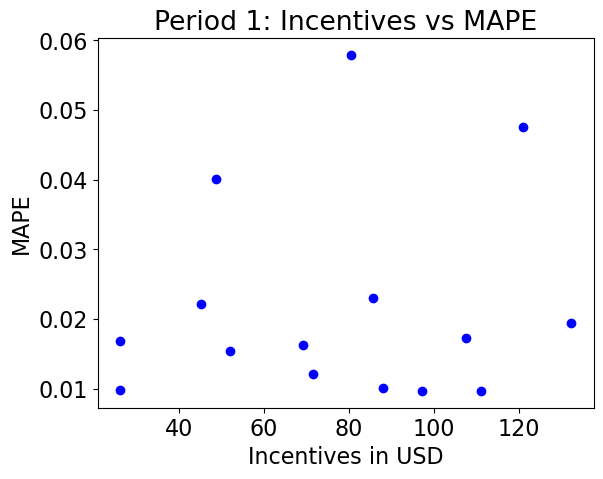

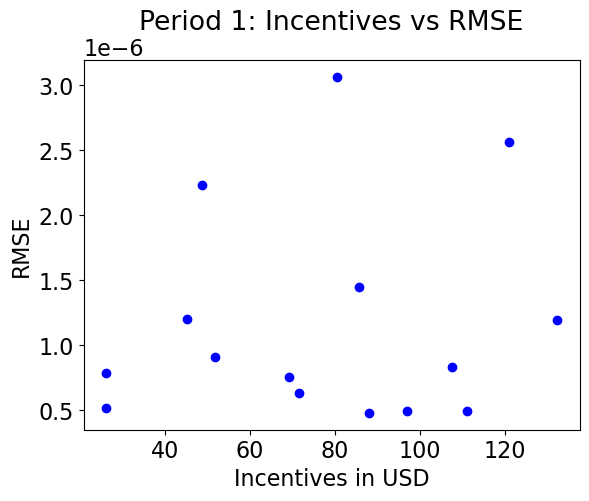

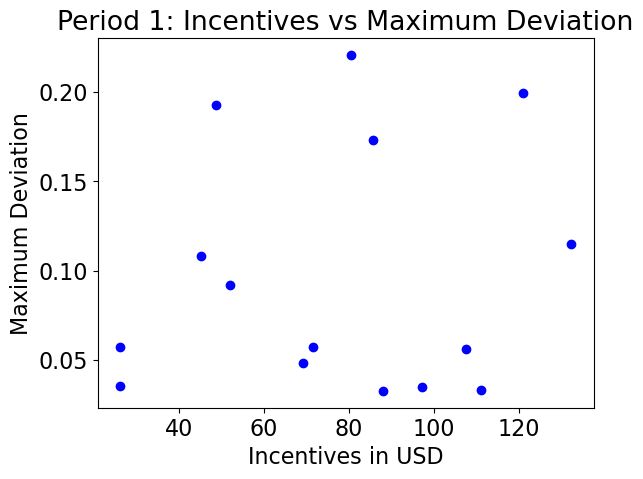

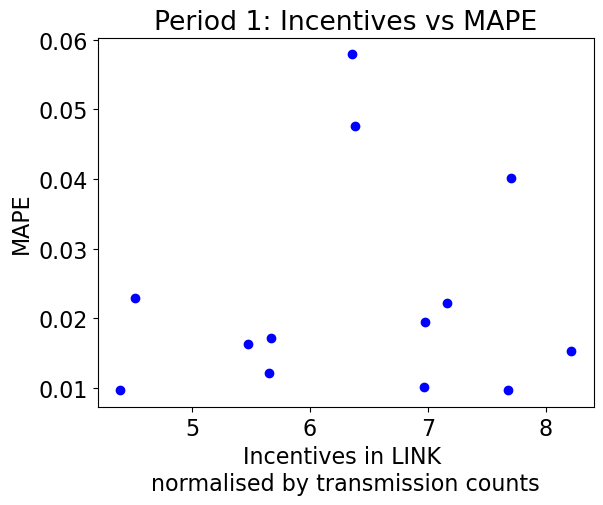

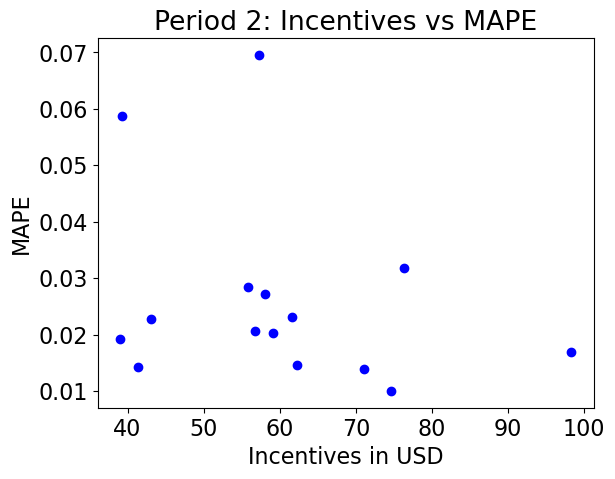

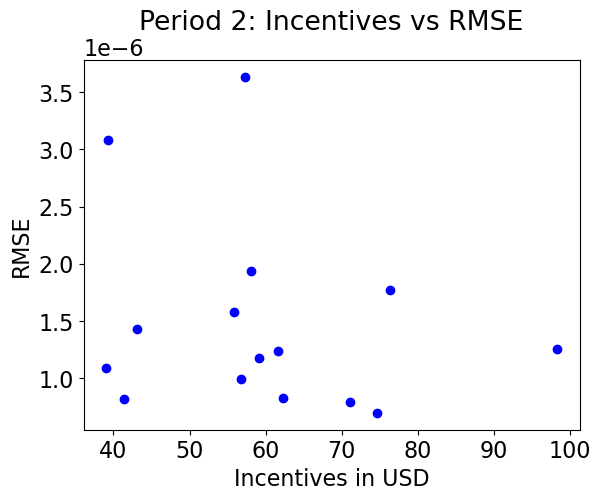

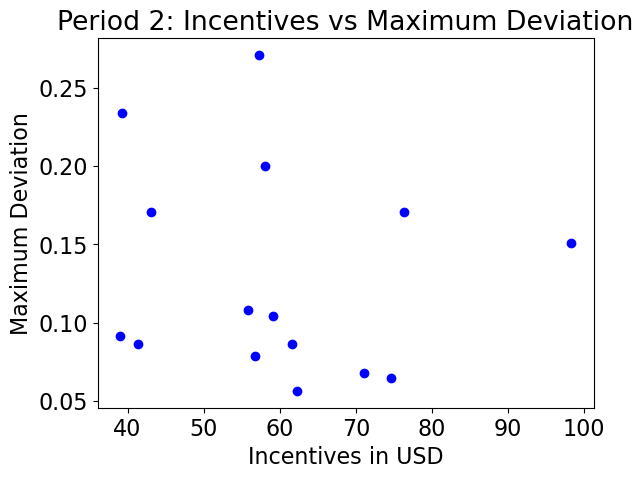

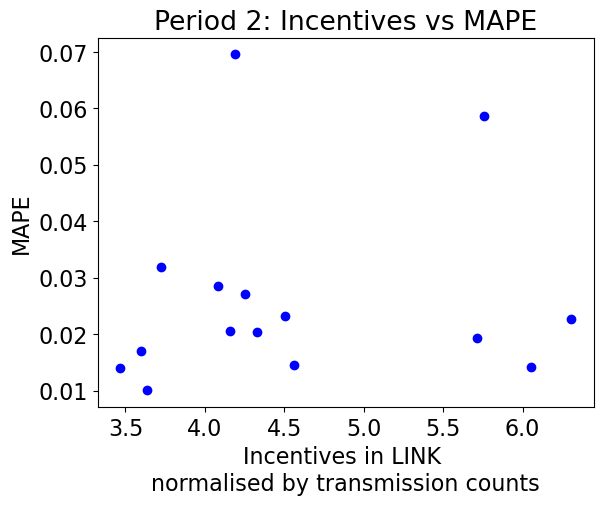

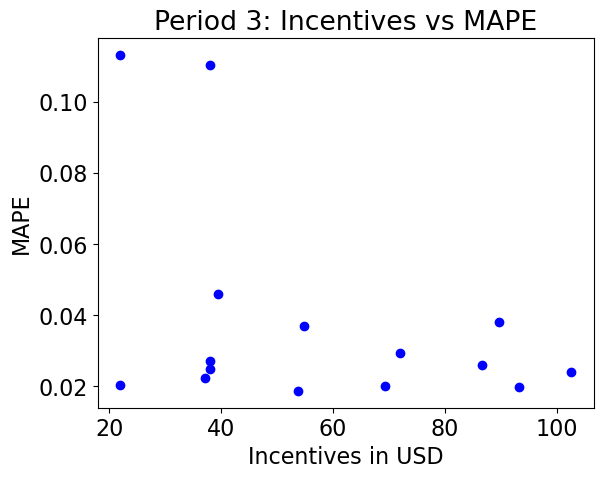

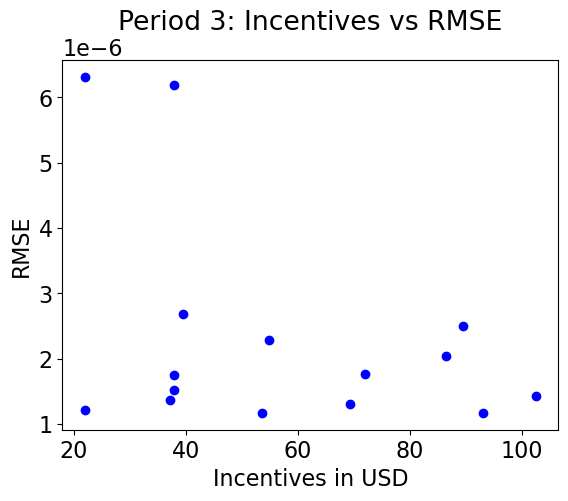

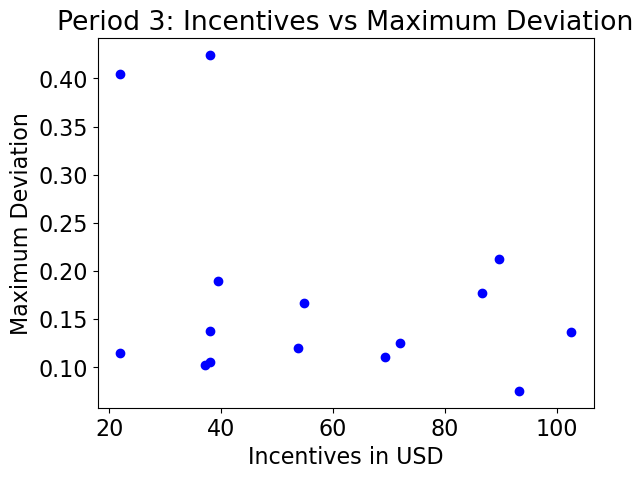

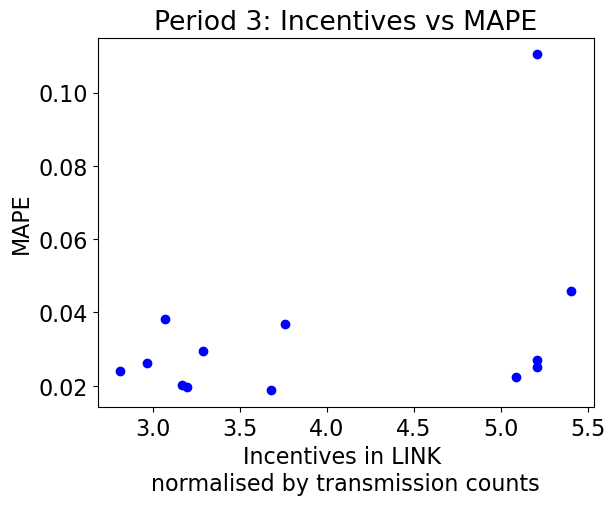

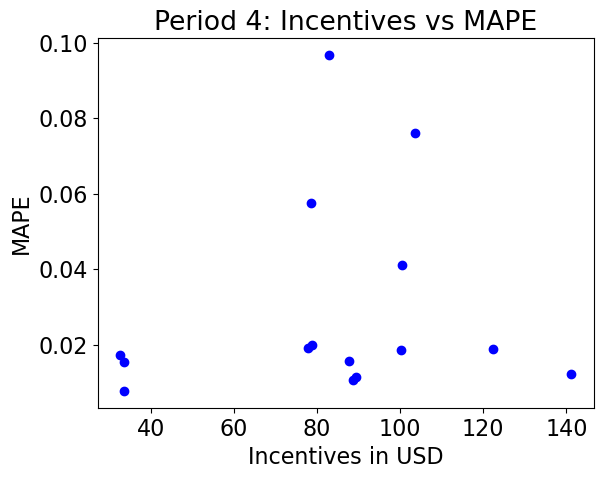

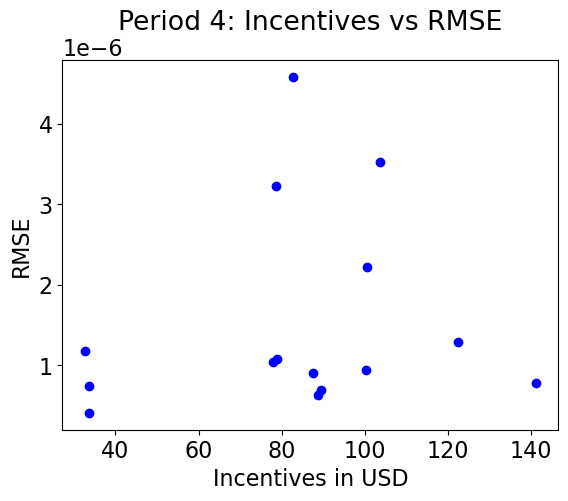

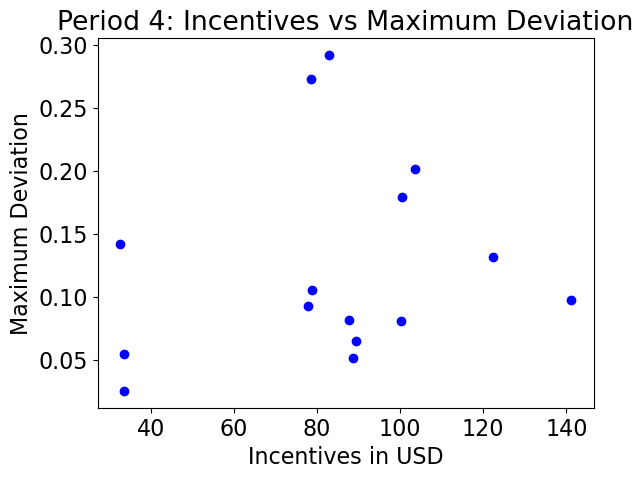

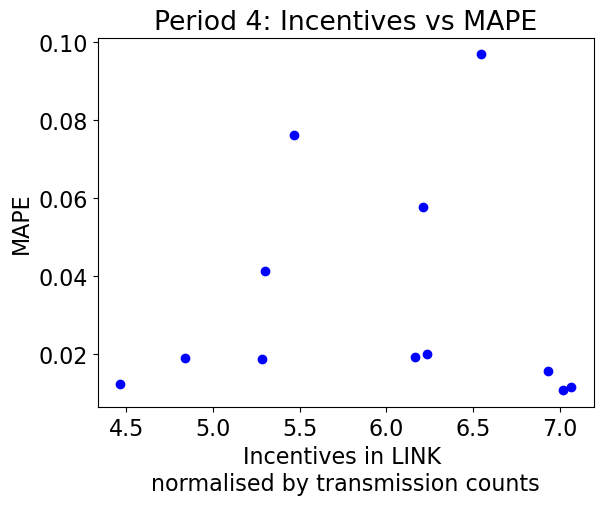

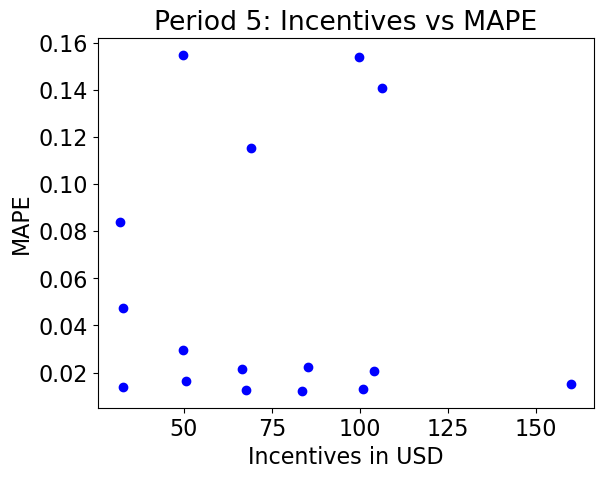

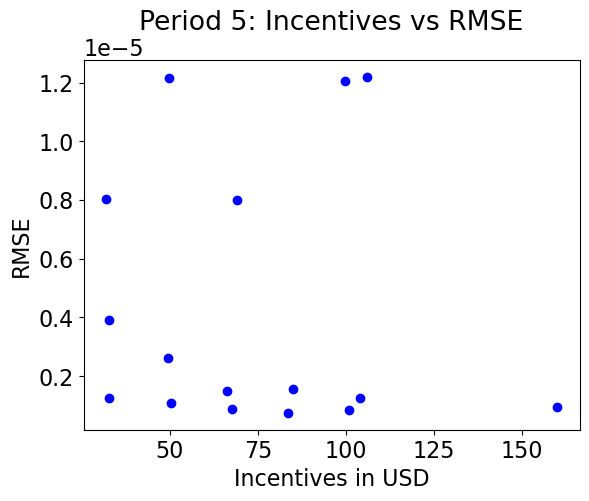

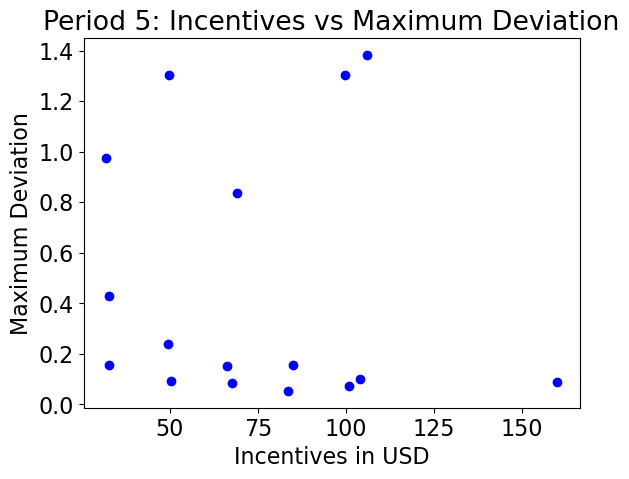

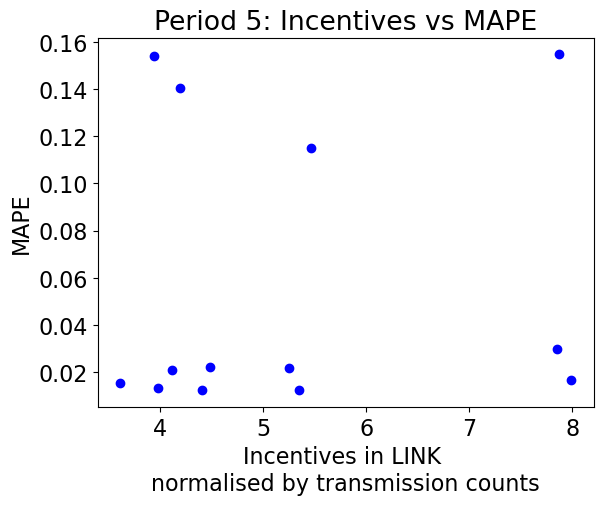

In [29]:
# Plot scatter plots for each period between incentives and errors

plt.figure(figsize=(6.4, 4.8)) 
plt.rcParams['font.size'] = 16
    
for index,period in enumerate(op_data_periods_cl):
    incentives = []
    incentives_link_normalised = []
    mape = []
    rmse = []
    max_dev = []
    for op in operator_names:
        if op in op_incentives_periods_usd[period]:
            incentives.append(op_incentives_periods_usd[period][op])
            incentives_link_normalised.append(op_incentives_periods_link_normalised[period][op])
            mape.append(op_data_periods_cl[period]["mape"][op])
            rmse.append(op_data_periods_cl[period]["rmse"][op])
            max_dev.append(op_data_periods_cl[period]["maximum_deviation"][op])
            
    # Create a scatter plot for mape
    plt.rcParams['font.size'] = 16
    plt.scatter(incentives, mape, color='blue', marker='o', label='Data Points')
    # Add labels and title
    plt.xlabel('Incentives in USD')
    plt.ylabel('MAPE')
    plt.title('Period '+str(index+1)+': Incentives vs MAPE')
    plt.savefig('figures/period'+str(index+1)+'_incentivesMAPE_corr_original.png', bbox_inches='tight')
    # Show the plot
    plt.show()
    
    # Create a scatter plot for rmse
    plt.rcParams['font.size'] = 16
    plt.scatter(incentives, rmse, color='blue', marker='o', label='Data Points')
    # Add labels and title
    plt.xlabel('Incentives in USD')
    plt.ylabel('RMSE')
    plt.title('Period '+str(index+1)+': Incentives vs RMSE')
    plt.savefig('figures/period'+str(index+1)+'_incentivesRMSE_corr.png', bbox_inches='tight')
    # Show the plot_original
    plt.show()
    
    # Create a scatter plot for maximum deviation
    plt.rcParams['font.size'] = 16
    plt.scatter(incentives, max_dev, color='blue', marker='o', label='Data Points')
    # Add labels and title
    plt.xlabel('Incentives in USD')
    plt.ylabel('Maximum Deviation')
    plt.title('Period '+str(index+1)+': Incentives vs Maximum Deviation')
    plt.savefig('figures/period'+str(index+1)+'_incentivesMaxDev_corr_original.png', bbox_inches='tight')
    # Show the plot
    plt.show()
    
    # Create a scatter plot for link normalised against mape
    plt.rcParams['font.size'] = 16
    plt.scatter(incentives_link_normalised, mape, color='blue', marker='o', label='Data Points')
    # Add labels and title
    plt.xlabel('Incentives in LINK \nnormalised by transmission counts')
    plt.ylabel('MAPE')
    plt.title('Period '+str(index+1)+': Incentives vs MAPE')
    plt.savefig('figures/period'+str(index+1)+'_incentiveslinkMAPE_corr_original.png', bbox_inches='tight')
    # Show the plot
    plt.show()

    

### Plot a scatter plot showing the original incentives in USD against MAPE of all periods in one plot

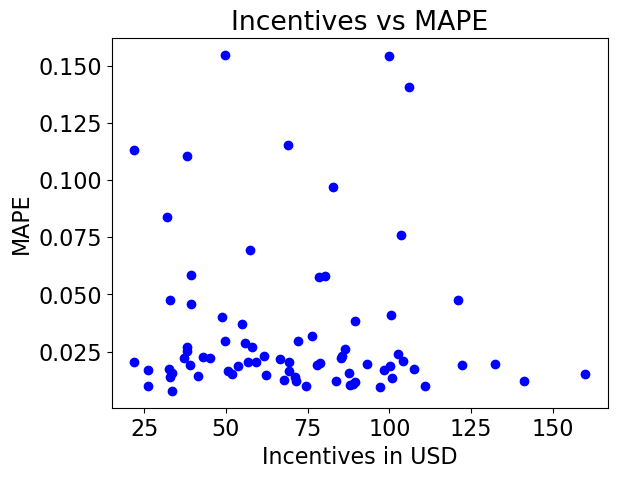

In [30]:
# Plot scatter plots for each period between incentives differences and errors
incentives = []
operators = []
mape = []
rmse = []
max_dev = []
for index,period in enumerate(op_data_periods_cl):
    
    for op in operator_names:
        if op in op_incentives_periods_usd[period]:
            incentives.append(op_incentives_periods_usd[period][op])
            mape.append(op_data_periods_cl[period]["mape"][op])
            rmse.append(op_data_periods_cl[period]["rmse"][op])
            max_dev.append(op_data_periods_cl[period]["maximum_deviation"][op])
            operators.append(op)
            
# Create a scatter plot for mape
plt.scatter(incentives, mape, color='blue', marker='o', label='Data Points')
# Add labels and title
plt.xlabel('Incentives in USD')
plt.ylabel('MAPE')
plt.title('Incentives vs MAPE')
# plt.savefig(deviation_threshold_dir_path+'/period'+str(index+1)+'_newincentivesdiffMAPE_corr.png', bbox_inches='tight')
# Show the plot
plt.show()
    

### Calculate the Spearman's Coefficient and the p-value for the relationship between original incentives in USD and the MAPE value

In [31]:
# Assuming you have two arrays: array1 and array2
correlation_coefficient, p_value = spearmanr(mape, incentives)
print("Spearman coefficient", correlation_coefficient)
print("p-value", p_value)

Spearman coefficient -0.12149673274393862
p-value 0.29578778550229695


### Plot a scatter plot showing the original incentives in normalised LINK per transmission against MAPE of all periods in one plot

In [32]:
op_incentives_periods_link_normalised

{'2023-05-08 18:51:11 -> 2023-05-15 18:27:23': {'ztake_org': 6.973798785402679,
  'easy_2_stake': 6.382320290472964,
  'syncnode': 5.655063501470502,
  'wetez': 5.669317447145896,
  'linkforest': 4.516250298710177,
  'staking_facilities': 6.360232897145896,
  'linkpool': nan,
  'xbto': 6.963878579049116,
  'prophet': 7.70489663974676,
  'blockdaemon': 5.473020693725199,
  'kytzu': 8.214348193538864,
  'deutsche_telekom_mms': 4.390797462145027,
  'dextrac': 7.159100554943648,
  'blocksize_capital': nan,
  '01node': nan,
  'figment_networks': 7.67988262305683},
 '2023-04-24 16:42:59 -> 2023-05-01 20:51:11': {'ztake_org': 4.559007849943312,
  'easy_2_stake': 5.754158391850976,
  'syncnode': 3.595491244009176,
  'wetez': 5.711731215471168,
  'linkforest': 3.466773909850976,
  'staking_facilities': 4.187647225414528,
  'linkpool': 3.7224408247371947,
  'xbto': 4.325831363370208,
  'prophet': 4.081816297700144,
  'blockdaemon': 6.30540186356608,
  'kytzu': 4.156122657850976,
  'deutsche_tele

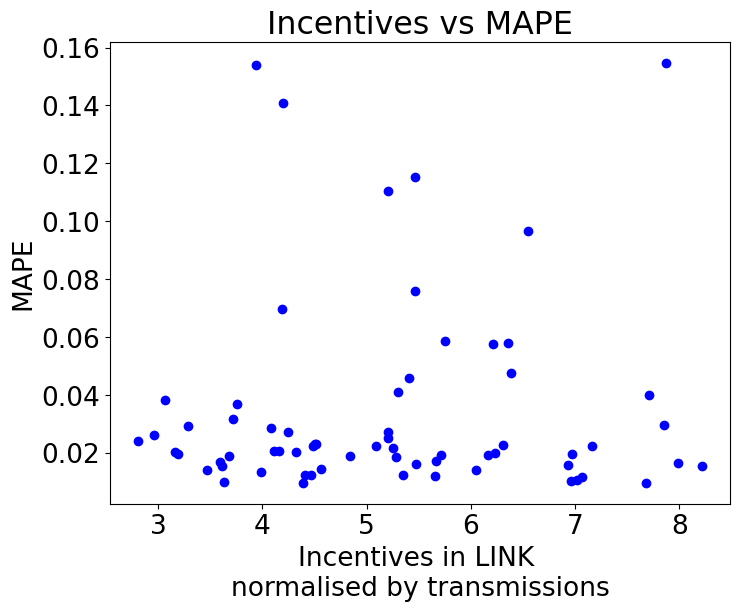

In [34]:
# Plot scatter plots for each period between incentives differences and errors
incentives = []
operators = []
mape = []
rmse = []
max_dev = []
for index,period in enumerate(op_data_periods_cl):
    
    for op in operator_names:
        if op in op_incentives_periods_link_normalised[period]:
            if not math.isnan(op_incentives_periods_link_normalised[period][op]):
                incentives.append(op_incentives_periods_link_normalised[period][op])
                mape.append(op_data_periods_cl[period]["mape"][op])
                rmse.append(op_data_periods_cl[period]["rmse"][op])
                max_dev.append(op_data_periods_cl[period]["maximum_deviation"][op])
                operators.append(op)
            
# Create a scatter plot for mape
plt.figure(figsize=(8, 6)) 
plt.rcParams['font.size'] = 19
plt.scatter(incentives, mape, color='blue', marker='o', label='Data Points')
# Add labels and title
plt.xlabel('Incentives in LINK \nnormalised by transmissions')
plt.ylabel('MAPE')
plt.title('Incentives vs MAPE')
plt.savefig('figures/combinedperiods_linkincvsmape_original.png', bbox_inches='tight')
# Show the plot
plt.show()
    

### Calculate the Spearman's Coefficient and the p-value for the relationship between original incentives in USD and the MAPE value

In [35]:
# Assuming you have two arrays: array1 and array2
correlation_coefficient, p_value = spearmanr(mape, incentives)
print("Spearman coefficient", correlation_coefficient)
print("p-value", p_value)

Spearman coefficient -0.04314969838635461
p-value 0.7308370585658497


# Specify Deviation Threshold

This is thre threshold which will be used for the proposed incentivisation mechanism. Any operator whose submissio exceeds this threshold from the aggregate answer will be affected by this mechanism

In [36]:
deviation_threshold = 0.045
deviation_threshold_dir = str(deviation_threshold).replace(".", "_") + "-threshold"
deviation_threshold_dir_path = "./figures/"+deviation_threshold_dir

# Create figure directory if it does not exist
if not os.path.exists(deviation_threshold_dir_path):
    os.makedirs(deviation_threshold_dir_path)
    print(f"Directory '{deviation_threshold_dir_path}' created.")

# Proposed Incentivisation Scheme

Do not incentivise operators with a deviation of more than or equal to the deviation threshold . Then, split this penalty split amongst operators whose submission was within the acceptable thresholds for that round.

### Calculate incentives by simulating the incentivisation scheme for each chosen period

This is done by going over each submission and calculating its deviation from the aggregated answer. If the submission's deviation exceeds the deviation threshold, it is considered as an operator's misbehvaiour. This operator is penalised and the penalty amount is split amongst operators whose submission was within the acceptable thresholds for that round.

In [37]:
# Get all withdrawal block numbers, not only those done by Chainlink but also done by operators themselves
unique_withdrawal_blocks = withdrawals["blockNumber"].unique()
# Get billing params
billing_params_filename = "data/"+feed_details["path"]+"/billing_params.json"
with open(billing_params_filename, 'r') as file:
    billing_params = json.load(file)

# Get billing params per withdrawal block
billing_params_per_withdrawal_block = {}
for block in unique_withdrawal_blocks:
    billing_params_per_withdrawal_block[block] = get_block_billing(block, billing_params)
    
# Calculate earnings per period
period_earnings_incentivisation_scheme = {}
period_earnings_incentivisation_scheme_link_normalised = {}

# Keep transmission counts
op_transmission_counts = {}

# Keep amounts of misbehaviours per period
period_misbehaviours = {}
        
# Loop through each chosen period
for period in chosen_periods:
    operator_extra_incentives = {}
    operator_extra_incentives_link = {}
    period_key = period["from"] +" -> "+period["to"]
    period_misbehaviours[period_key] = {}
    period_earnings_incentivisation_scheme[period_key] = {}
    period_earnings_incentivisation_scheme_link_normalised[period_key] = {}
    op_transmission_counts[period_key] = {}
    
    from_date = datetime.strptime(period["from"], "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc)
    to_date = datetime.strptime(period["to"], "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc)
    
    # Get transmissions in period
    transmissions_period = all_transmissions[(all_transmissions['date'] <= to_date) & (all_transmissions['date'] > from_date)]
    
    for op in operator_names:
        
        # Get operator's address
        op_addr = get_op_addr(nops,op)
        
        # Get all submissions in period
        op_submissions_period = pd.read_csv(path+"/per_op/"+op+"/submissions.csv")
        op_submissions_period.rename(columns={op+"_answer": 'answer'}, inplace=True)
        op_submissions_period["answer"] = op_submissions_period["answer"]
        op_submissions_period['timestamp'] = op_submissions_period['timestamp'] * 1000
        op_submissions_period["date"] = pd.to_datetime(op_submissions_period['timestamp'], unit='ms', utc=True)
        op_submissions_period = op_submissions_period[(op_submissions_period['date'] <= to_date) & (op_submissions_period['date'] > from_date)]
        
        # Get payments in period
        op_payments = pd.read_csv(path+"/per_op/"+op+"/payments.csv")
        op_payments['txTimestamp'] = op_payments['txTimestamp'] * 1000
        op_payments["date"] = pd.to_datetime(op_payments['txTimestamp'], unit='ms', utc=True)
        op_payments["blockNumber"] = op_payments["blockNumber"].astype(str)
        op_payments["linkPrice"] = op_payments["blockNumber"].map(link_prices)
        op_payments["usdAmount"] = op_payments["linkPrice"] * op_payments["amount"]
        op_payments = op_payments[(op_payments['date'] <= to_date) & (op_payments['date'] > from_date)]
        
        # Get operators transmission counts
        op_transmission_counts[period_key][op] = len(transmissions_period[transmissions_period['submitter'] == op_addr])
        
        # Get link prices per block
        amount_paid = op_payments["usdAmount"].sum()
        amount_paid_link = op_payments["amount"].sum()
        # If there were payments made
        
        penalty = 0
        reduce_rewards = 0
        reduce_rewards_link = 0
        
        if amount_paid > 0 or amount_paid_link > 0:
            last_date = ""
            # Loop through each withdrawal and get submissions until that date to calculate errors
            for withdrawal_index, withdrawal_row in op_payments.iterrows():
                withdrawal_date = withdrawal_row["date"]
                
                # Get billing params at date
                reward_rate = (billing_params_per_withdrawal_block[int(withdrawal_row["blockNumber"])]["linkGweiPerObservation"] / 1000000000.0) * withdrawal_row["linkPrice"]
                reward_rate_link = (billing_params_per_withdrawal_block[int(withdrawal_row["blockNumber"])]["linkGweiPerObservation"] / 1000000000.0)
                
                # if there was no previous date
                if last_date == "":
                    op_submissions_withdrawal = op_submissions_period[op_submissions_period['date'] <= withdrawal_date]
                else: 
                    op_submissions_withdrawal = op_submissions_period[(op_submissions_period['date'] > last_date) & (op_submissions_period['date'] <= withdrawal_date)]
                
                # Holds operator misbehaviours
                op_misbehaviours = 0
                # Loop through submissions during withdrawal to find misbehaviours
                for submission_index, submission_row in op_submissions_withdrawal.iterrows():
                    upper_limit = submission_row["aggregatedAnswer"] * (1+deviation_threshold)
                    lower_limit = submission_row["aggregatedAnswer"] * (1-deviation_threshold)
                    operator_deviation = (abs(submission_row["answer"] - submission_row["aggregatedAnswer"]) / submission_row["aggregatedAnswer"]) * 100
                    # if deviated more than threshold
                    if operator_deviation > deviation_threshold:
                        op_misbehaviours += 1
                        # Get correct operators
                        correct_oracles = [col for col in submission_row.index if col.endswith('_answer') and submission_row[col] <= upper_limit and submission_row[col] >= lower_limit]
                        correct_oracles = [element[:-7] for element in correct_oracles]
                        # For each correct oracle, add extra incentive
                        for correct_oracle in correct_oracles:
                            # Extra incentive is the penalty amount divided by the correct operators
                            if not (correct_oracle in operator_extra_incentives):
                                operator_extra_incentives[correct_oracle] = 0
                                operator_extra_incentives_link[correct_oracle] = 0
                            operator_extra_incentives[correct_oracle] += reward_rate / float(len(correct_oracles))
                            operator_extra_incentives_link[correct_oracle] += reward_rate_link / float(len(correct_oracles))
                        
                period_misbehaviours[period_key][op] = (op_misbehaviours / len(op_submissions_withdrawal)) * 100
                # Calculate penalty by multiplying reward_rate * 2 * operator_misbehaviours
                # We need this to reduce the incentive given for these submissions before
                reduce_rewards += reward_rate * op_misbehaviours
                reduce_rewards_link += reward_rate_link * op_misbehaviours
                
            
            period_earnings_incentivisation_scheme[period_key][op] = amount_paid - reduce_rewards
            period_earnings_incentivisation_scheme_link_normalised[period_key][op] = amount_paid_link - reduce_rewards_link

            # For each oracle, add extra incentives
    for operator_name in operator_extra_incentives:
        if operator_name in period_earnings_incentivisation_scheme[period_key]:
            period_earnings_incentivisation_scheme[period_key][operator_name] += operator_extra_incentives[operator_name]
            if operator_name in operator_extra_incentives_link and  float(op_transmission_counts[period_key][operator_name]) > 0:
                period_earnings_incentivisation_scheme_link_normalised[period_key][operator_name] += operator_extra_incentives_link[operator_name]
                period_earnings_incentivisation_scheme_link_normalised[period_key][operator_name] /= float(op_transmission_counts[period_key][operator_name])
            
        

In [38]:
period_misbehaviours

{'2023-05-08 18:51:11 -> 2023-05-15 18:27:23': {'ztake_org': 10.0,
  'easy_2_stake': 23.333333333333332,
  'syncnode': 3.3333333333333335,
  'wetez': 6.666666666666667,
  'linkforest': 13.793103448275861,
  'staking_facilities': 40.0,
  'linkpool': 6.666666666666667,
  'xbto': 0.0,
  'prophet': 30.0,
  'blockdaemon': 3.3333333333333335,
  'kytzu': 6.666666666666667,
  'deutsche_telekom_mms': 0.0,
  'dextrac': 16.666666666666664,
  'blocksize_capital': 0.0,
  'figment_networks': 0.0},
 '2023-04-24 16:42:59 -> 2023-05-01 20:51:11': {'ztake_org': 8.823529411764707,
  'easy_2_stake': 47.05882352941176,
  'syncnode': 5.88235294117647,
  'wetez': 5.88235294117647,
  'linkforest': 3.4482758620689653,
  'staking_facilities': 55.88235294117647,
  'linkpool': 20.588235294117645,
  'xbto': 11.76470588235294,
  'prophet': 29.411764705882355,
  'blockdaemon': 11.76470588235294,
  'kytzu': 8.823529411764707,
  'deutsche_telekom_mms': 2.941176470588235,
  'dextrac': 14.705882352941178,
  'blocksize_c

### Plot the number of misbehaviours and the differences between the original incentives and the incentives after the introduction of the proposed incentivisation scheme for each period

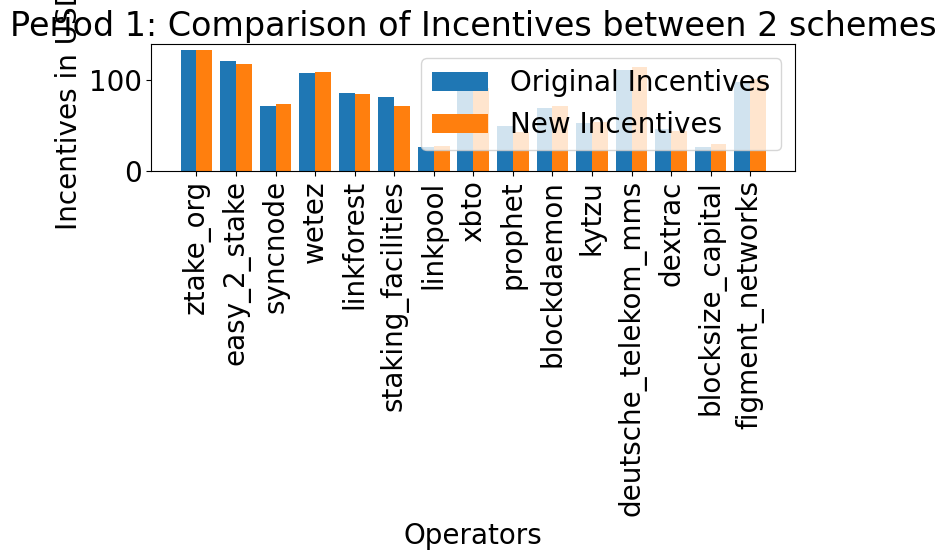

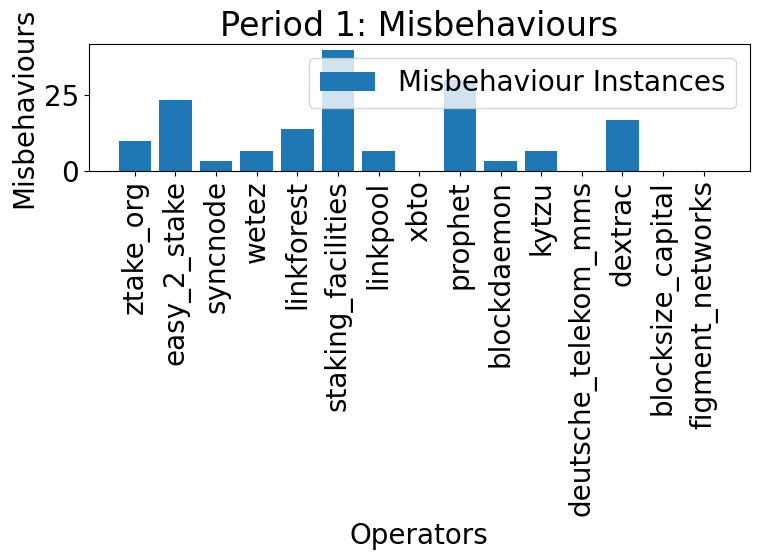

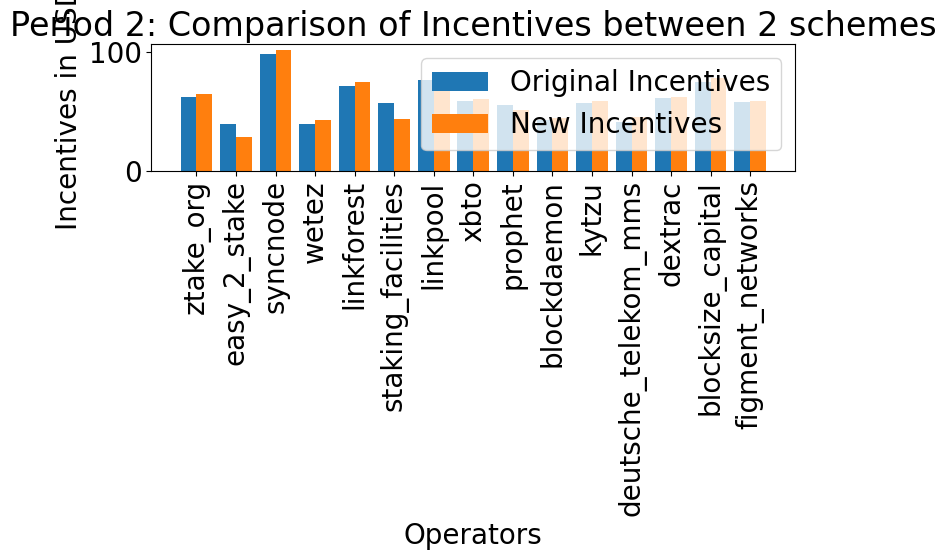

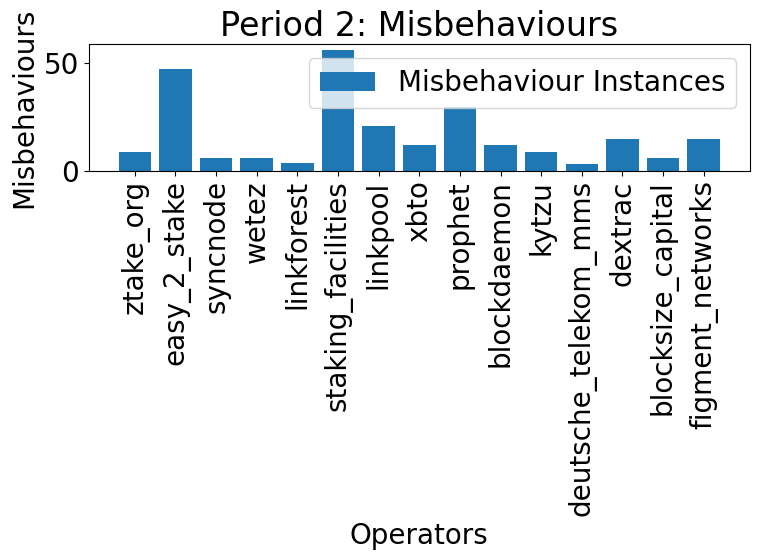

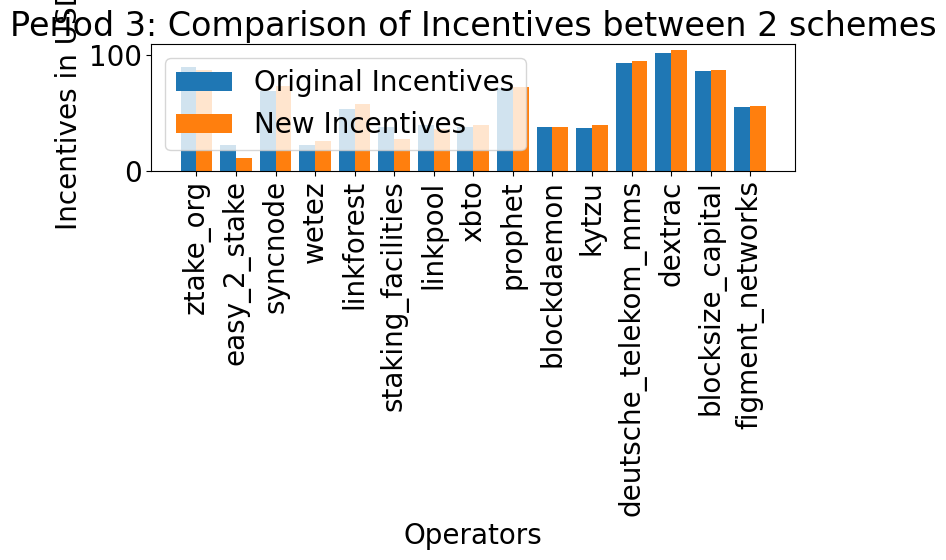

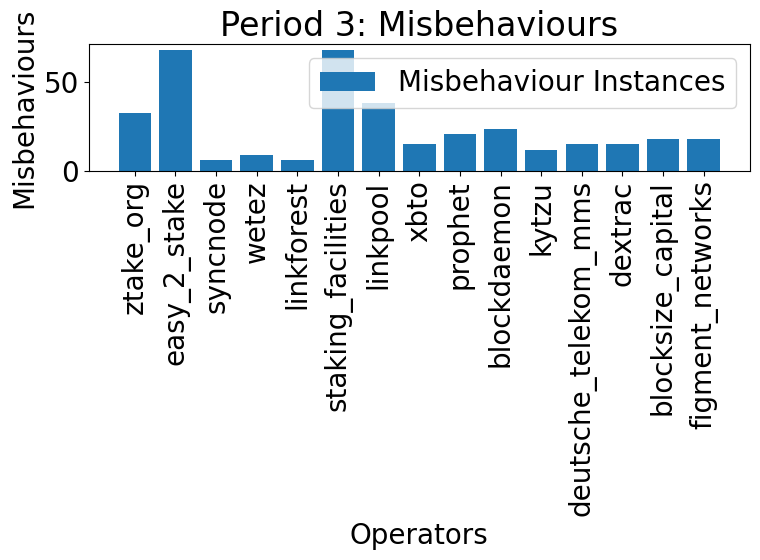

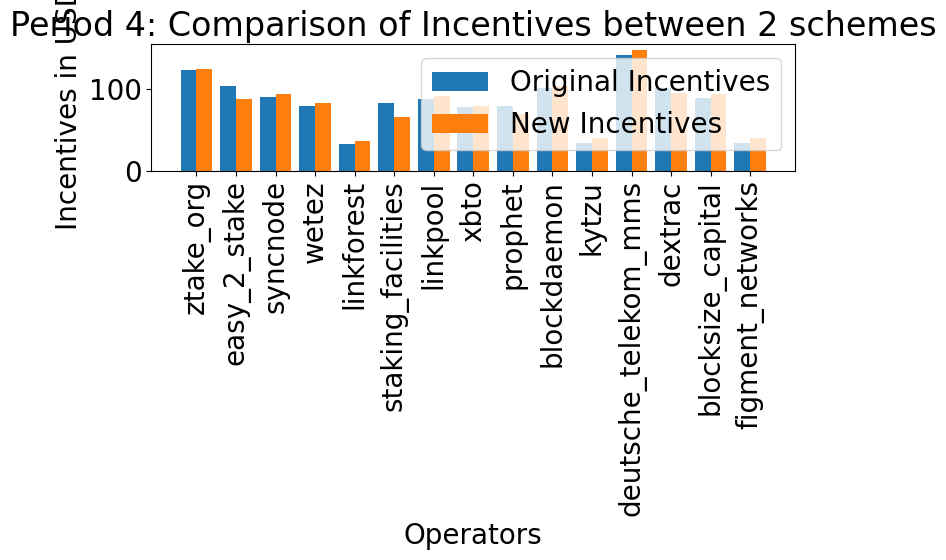

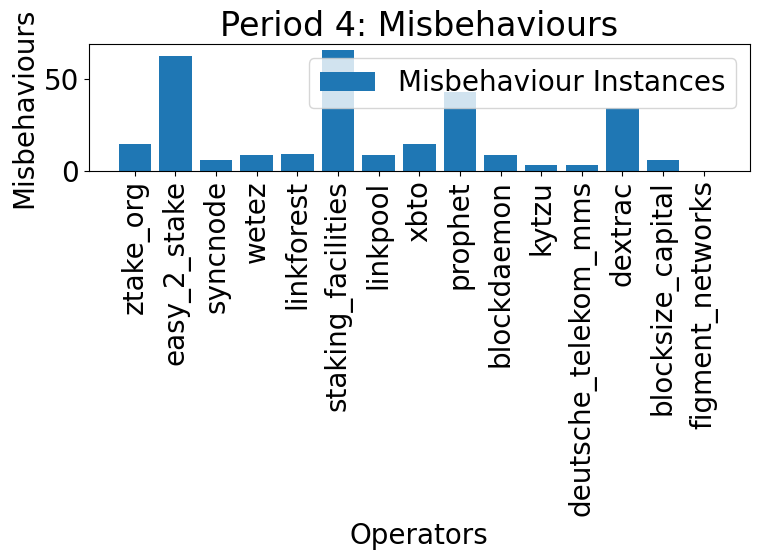

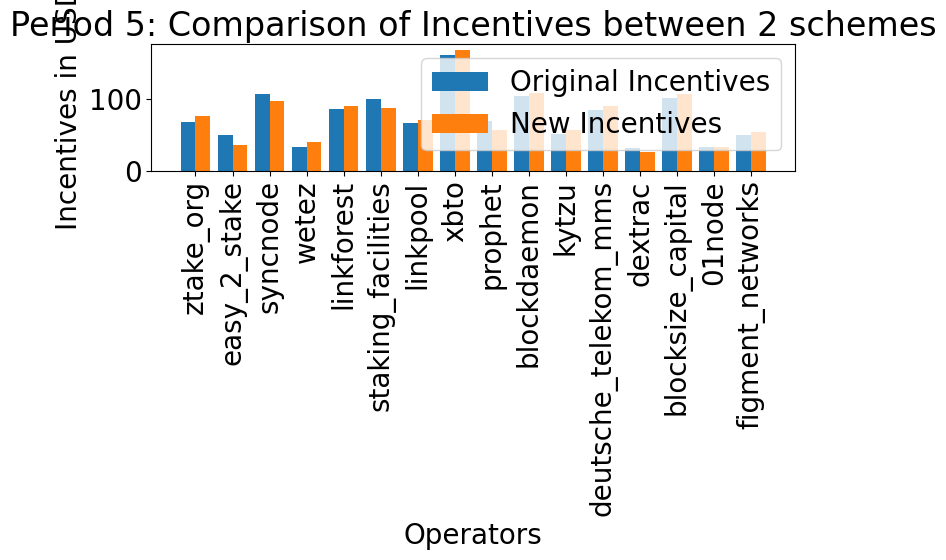

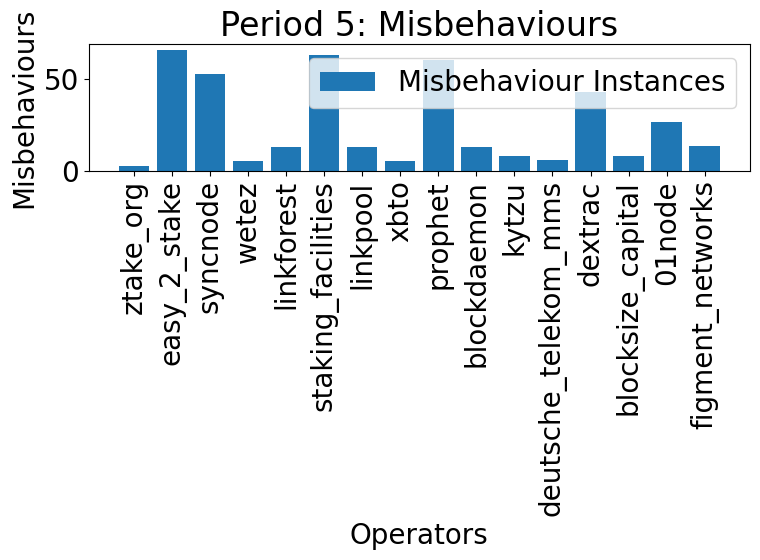

./figures/0_045-threshold


In [39]:
for index,period in enumerate(op_incentives_periods_usd):
    
    traditional_incentives = op_incentives_periods_usd[period]
    incentivisation_scheme_incentives = period_earnings_incentivisation_scheme[period]

    # Extract names and values
    operators = list(op_incentives_periods_usd[period].keys())
    values_ti = list(traditional_incentives.values())
    values_pi = [incentivisation_scheme_incentives[op] if op in traditional_incentives else 0 for op in operators]

    # Create positions for bars
    x = range(0, len(operators))
    plt.figure(figsize=(8, 6)) 
    plt.rcParams['font.size'] = 20 
    
    # Create the bar graph
    plt.bar(x, values_ti, width=0.4, label='Original Incentives')
    plt.bar([pos + 0.4 for pos in x], values_pi, width=0.4, label='New Incentives')

    # Add labels and title
    plt.xlabel('Operators')
    plt.xticks(rotation=90)
    plt.ylabel('Incentives in USD')
    plt.title('Period '+str(index+1)+': Comparison of Incentives between 2 schemes')
    plt.xticks([pos + 0.2 for pos in x], operators)
    plt.legend()
    plt.savefig(deviation_threshold_dir_path+'/period'+str(index+1)+'_inccomparison_incentivisation.png', bbox_inches='tight')
    plt.tight_layout()
    plt.show()
    
    
    plt.figure(figsize=(8, 6)) 
    plt.rcParams['font.size'] = 20
    values = list(period_misbehaviours[period].values())
    keys = list(period_misbehaviours[period].keys())
    x = range(0, len(values))
    plt.bar(x, values, label='Misbehaviour Instances')
    plt.xlabel('Operators')
    plt.xticks(rotation=90)
    plt.ylabel('Misbehaviours')
    plt.title('Period '+str(index+1)+': Misbehaviours')
    plt.xticks(x, keys)
    plt.legend()
    plt.savefig(deviation_threshold_dir_path+'/period'+str(index+1)+'_misbehaviours_incentivisation.png', bbox_inches='tight')
    plt.tight_layout()
    plt.show()
    
print(deviation_threshold_dir_path)


### Calculate the percentage difference between incentives

In [40]:
# Calculate differences in incentives
incentives_differences = {}

for period in chosen_periods:
    operator_extra_incentives = {}
    period_key = period["from"] +" -> "+period["to"]
    incentives_differences[period_key] = {}
    for op in op_incentives_periods_usd[period_key]:
        incentives_differences[period_key][op] = (period_earnings_incentivisation_scheme[period_key][op] - op_incentives_periods_usd[period_key][op]) / op_incentives_periods_usd[period_key][op] * 100
        
incentives_differences

{'2023-05-08 18:51:11 -> 2023-05-15 18:27:23': {'ztake_org': 0.017471452076430756,
  'easy_2_stake': -3.4057649276841433,
  'syncnode': 2.928062782896365,
  'wetez': 0.9843127629002395,
  'linkforest': -1.5054093513813518,
  'staking_facilities': -11.568856247524499,
  'linkpool': 4.038396825659875,
  'xbto': 3.5535067686782926,
  'prophet': -12.71415921085895,
  'blockdaemon': 3.025455575666927,
  'kytzu': 2.0380368796205004,
  'deutsche_telekom_mms': 2.755524379661216,
  'dextrac': -4.533923330895471,
  'blocksize_capital': 11.938841270618926,
  'figment_networks': 3.2222093593736534},
 '2023-04-24 16:42:59 -> 2023-05-01 20:51:11': {'ztake_org': 3.673271691949289,
  'easy_2_stake': -27.50229104048147,
  'syncnode': 3.353677931875648,
  'wetez': 8.444458735470104,
  'linkforest': 5.580298312799878,
  'staking_facilities': -24.166950463962507,
  'linkpool': -2.2862213366940765,
  'xbto': 2.16760869551468,
  'prophet': -8.543936648200633,
  'blockdaemon': 2.974183051758195,
  'kytzu': 4

### Plot scatter plots for each period showing the new inventives in USD against MAPE and RMSE

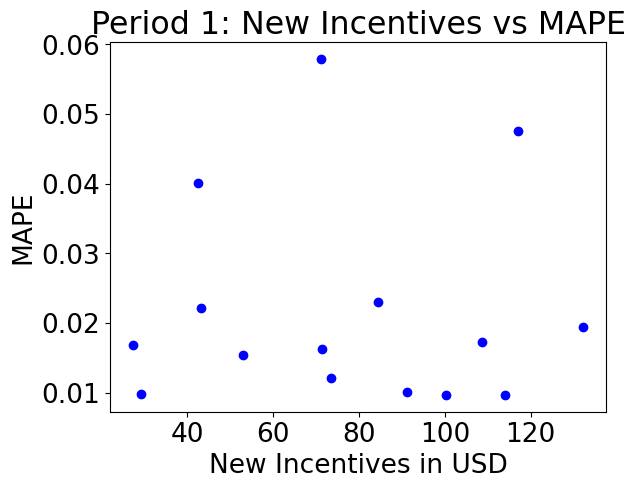

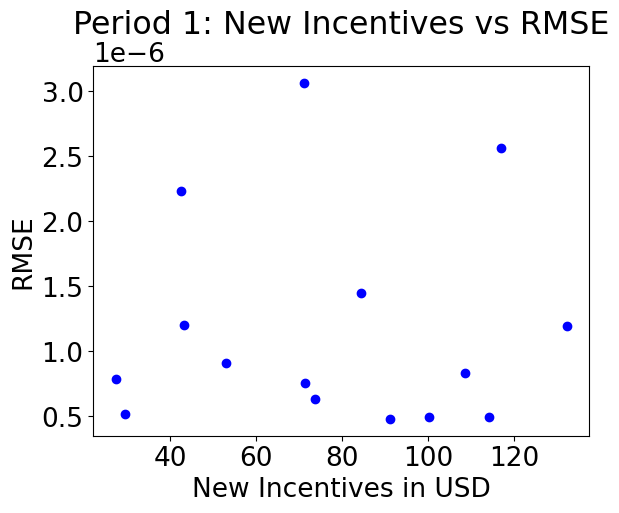

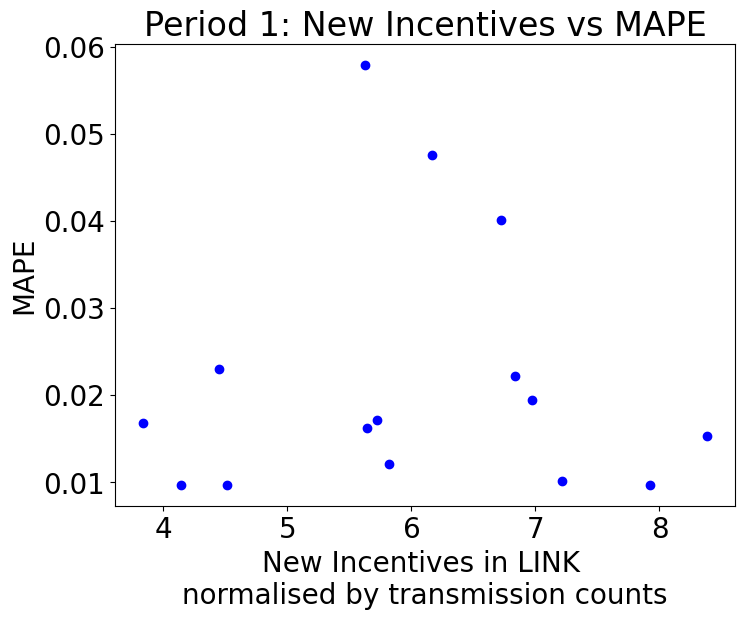

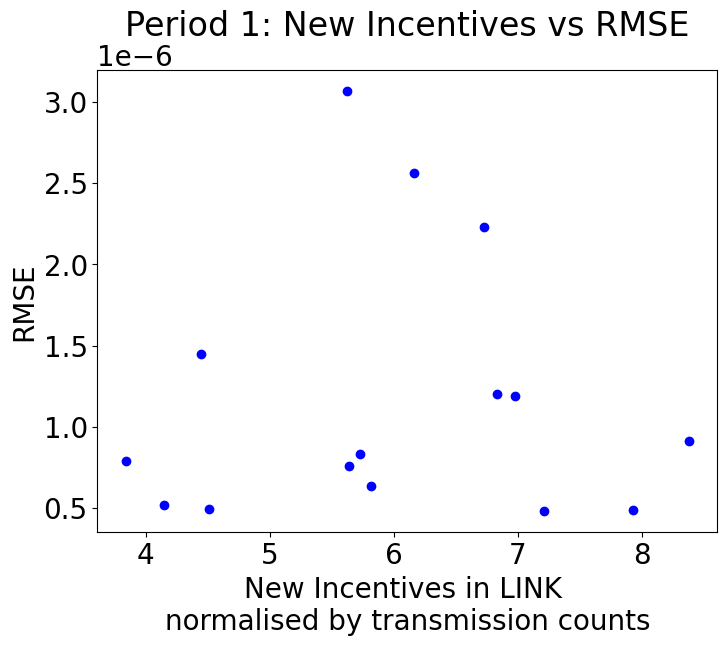

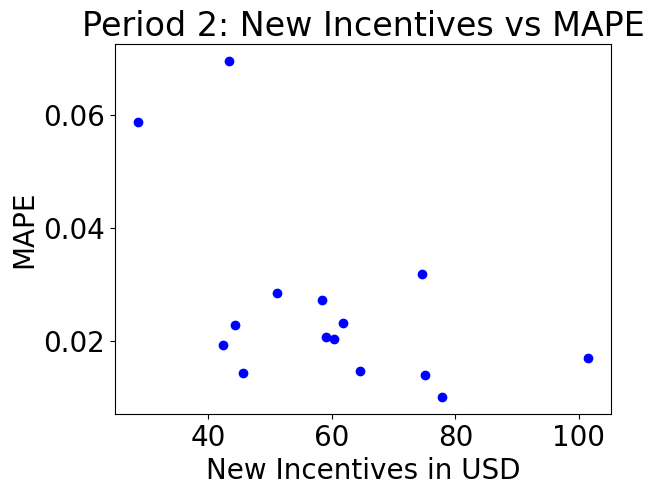

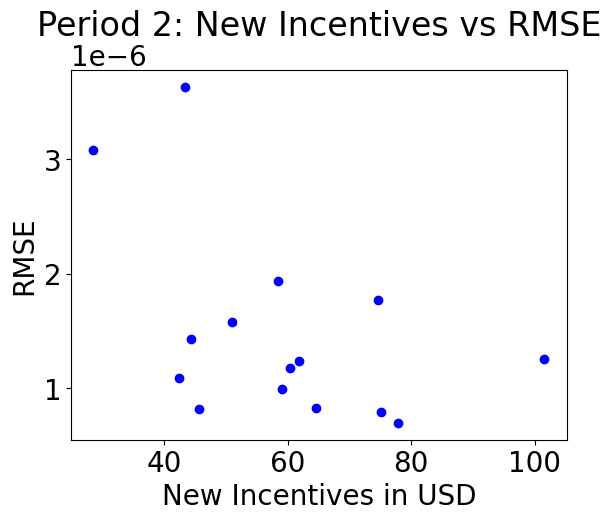

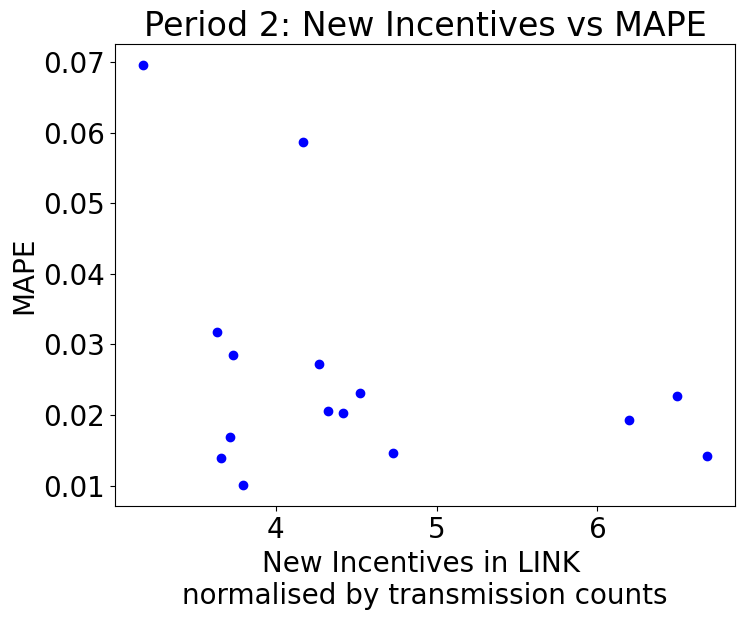

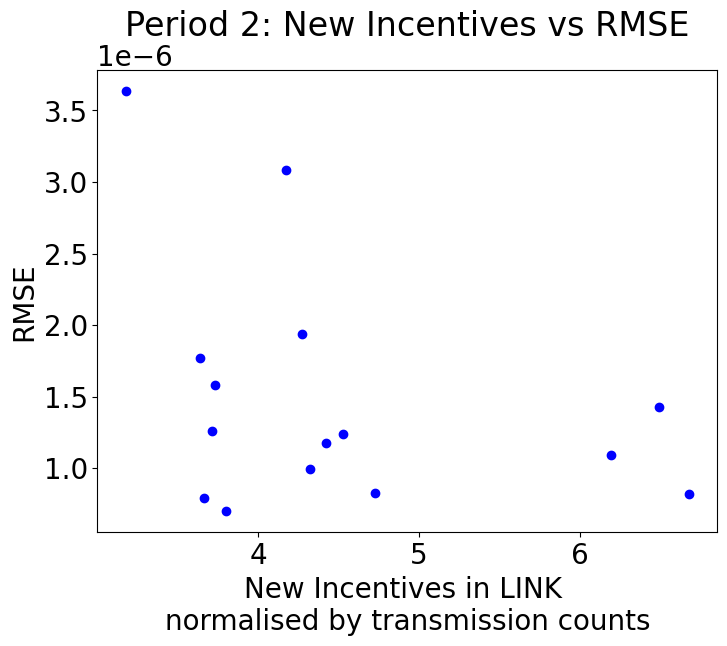

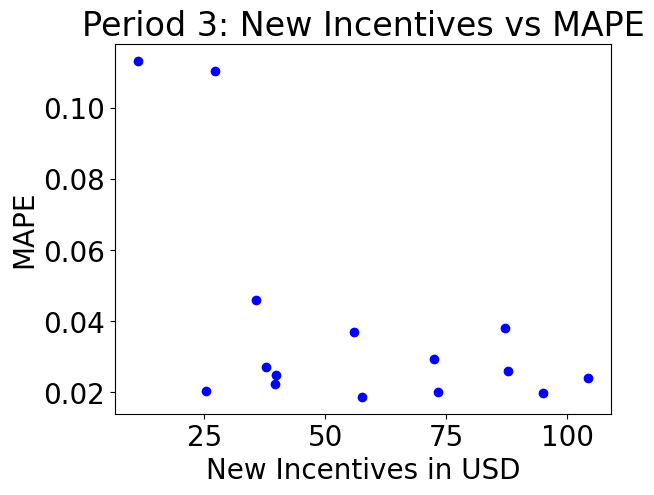

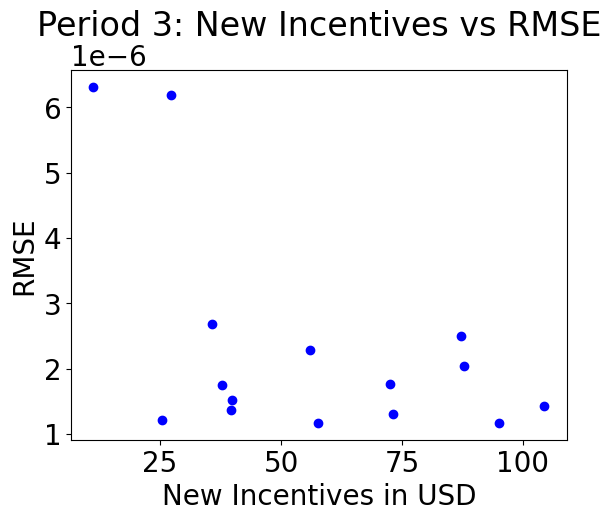

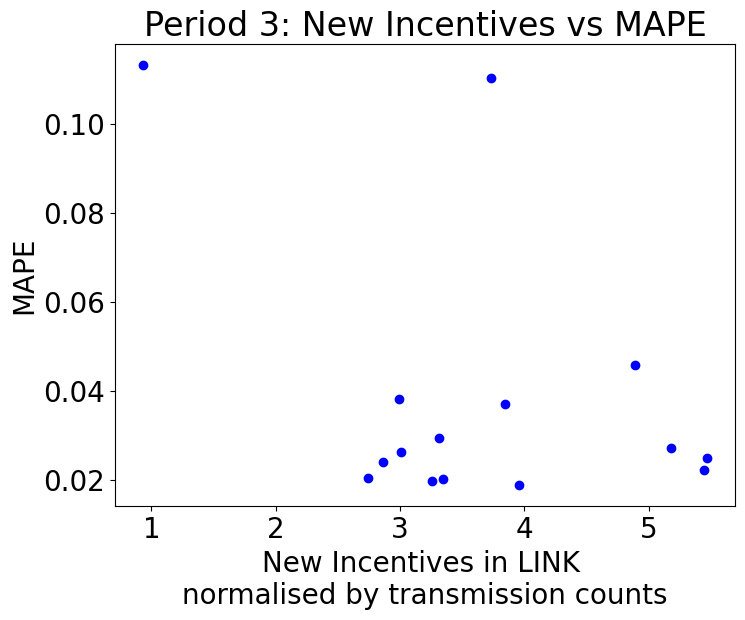

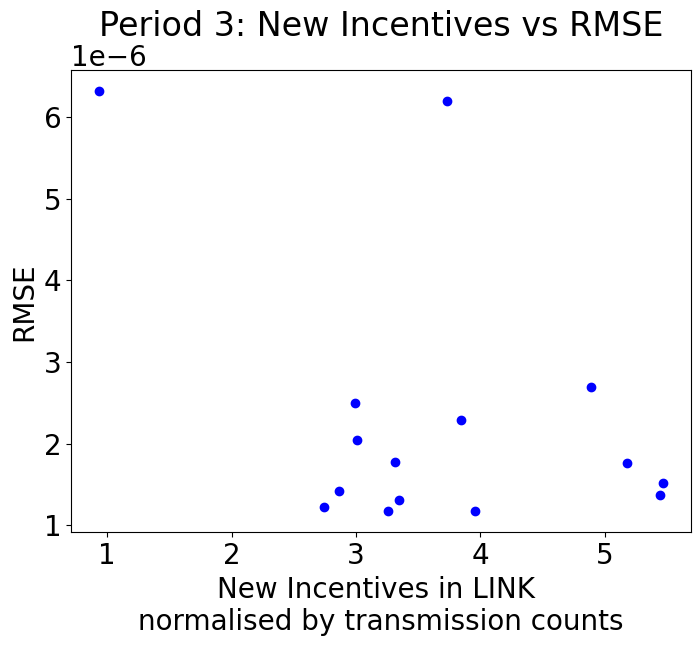

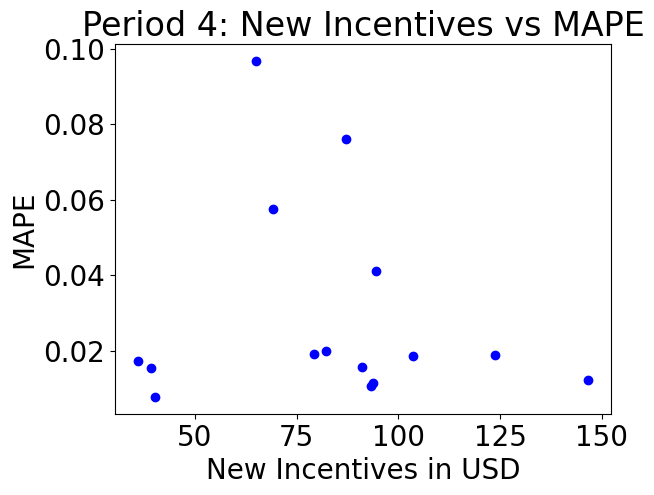

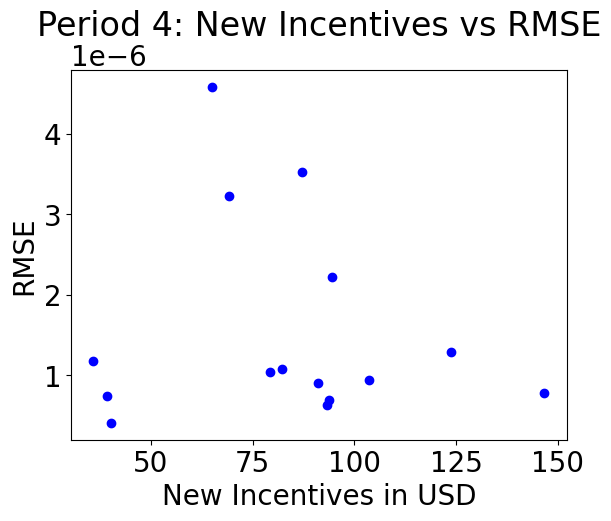

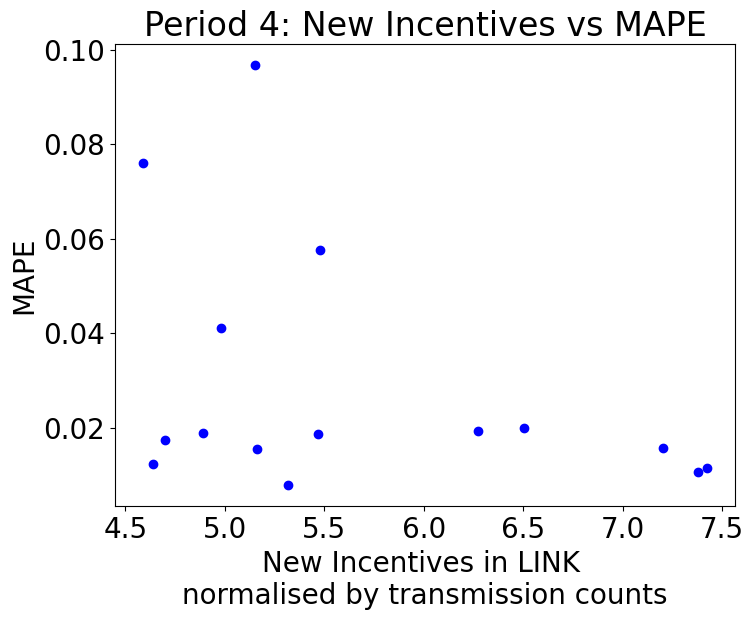

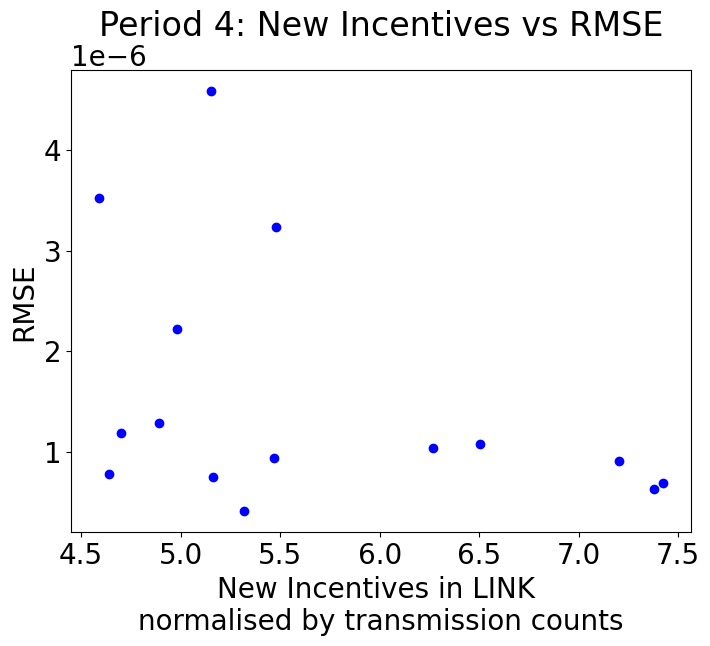

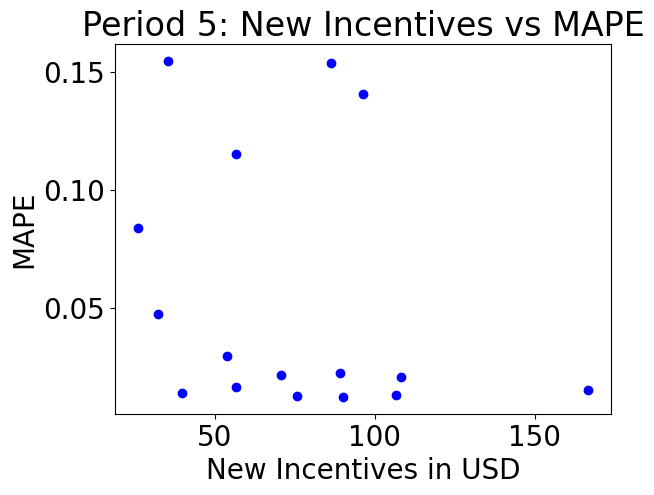

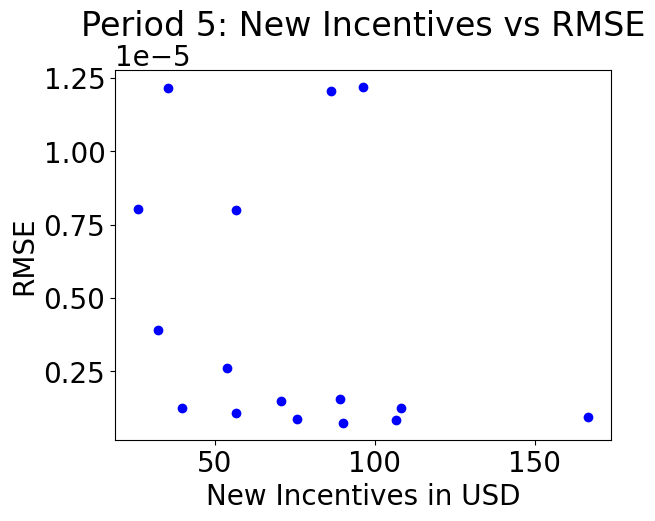

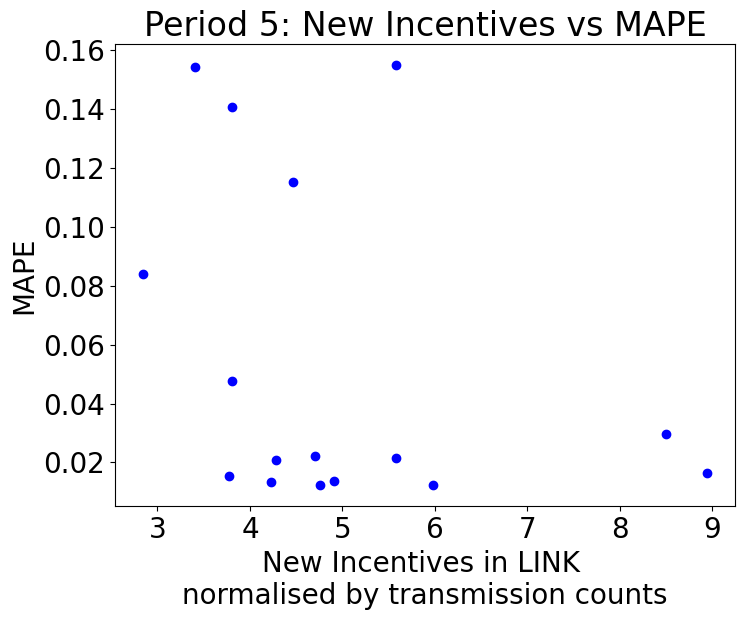

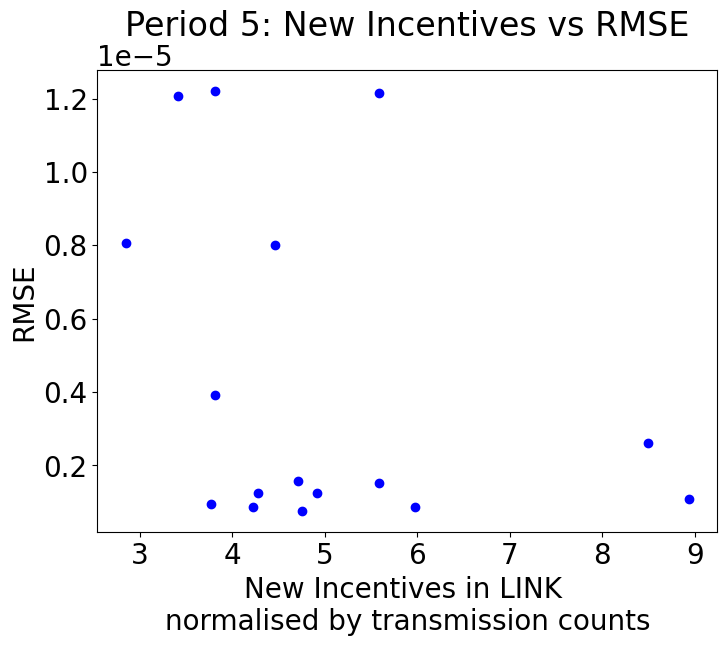

In [42]:
# Plot scatter plots for each period between incentives and errors
for index,period in enumerate(op_data_periods_cl):
    incentives = []
    incentives_link = []
    operators = []
    mape = []
    rmse = []
    max_dev = []
    for op in operator_names:
        if op in period_earnings_incentivisation_scheme[period]:
            incentives.append(period_earnings_incentivisation_scheme[period][op])
            incentives_link.append(period_earnings_incentivisation_scheme_link_normalised[period][op])
            mape.append(op_data_periods_cl[period]["mape"][op])
            rmse.append(op_data_periods_cl[period]["rmse"][op])
            max_dev.append(op_data_periods_cl[period]["maximum_deviation"][op])
            operators.append(op)
            
    # Create a scatter plot for mape
    plt.scatter(incentives, mape, color='blue', marker='o', label='Data Points')
    # Add labels and title
    plt.xlabel('New Incentives in USD')
    plt.ylabel('MAPE')
    plt.title('Period '+str(index+1)+': New Incentives vs MAPE')
    plt.savefig(deviation_threshold_dir_path+'/period'+str(index+1)+'_newincentivesMAPE_corr_nopenalty.png', bbox_inches='tight')
    # Show the plot
    plt.show()
    
    # Create a scatter plot for rmse
    plt.scatter(incentives, rmse, color='blue', marker='o', label='Data Points')
    # Add labels and title
    plt.xlabel('New Incentives in USD')
    plt.ylabel('RMSE')
    plt.title('Period '+str(index+1)+': New Incentives vs RMSE')
    plt.savefig(deviation_threshold_dir_path+'/period'+str(index+1)+'_newincentivesRMSE_corr_nopenalty.png', bbox_inches='tight')
    # Show the plot
    plt.show()
    
    # Create a scatter plot for mape
    plt.figure(figsize=(8, 6)) 
    plt.rcParams['font.size'] = 20
    plt.scatter(incentives_link, mape, color='blue', marker='o', label='Data Points')
    # Add labels and title
    plt.xlabel('New Incentives in LINK \nnormalised by transmission counts')
    plt.ylabel('MAPE')
    plt.title('Period '+str(index+1)+': New Incentives vs MAPE')
    plt.savefig(deviation_threshold_dir_path+'/period'+str(index+1)+'_newincentivesLINKMAPE_corr_nopenalty.png', bbox_inches='tight')
    # Show the plot
    plt.show()
    
    # Create a scatter plot for mape
    plt.figure(figsize=(8, 6)) 
    plt.rcParams['font.size'] = 20
    plt.scatter(incentives_link, rmse, color='blue', marker='o', label='Data Points')
    # Add labels and title
    plt.xlabel('New Incentives in LINK \nnormalised by transmission counts')
    plt.ylabel('RMSE')
    plt.title('Period '+str(index+1)+': New Incentives vs RMSE')
    plt.savefig(deviation_threshold_dir_path+'/period'+str(index+1)+'_newincentivesLINKRMSE_corr_nopenalty.png', bbox_inches='tight')
    # Show the plot
    plt.show()
    

### Plot scatter plots for each period showing the difference between incentives in USD against MAPE

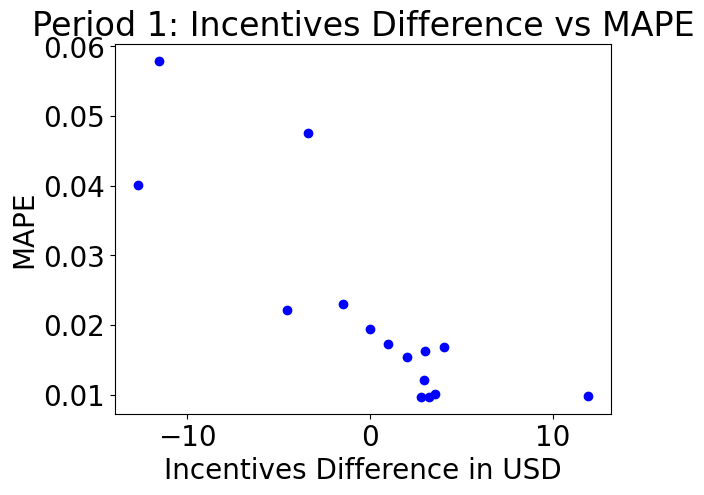

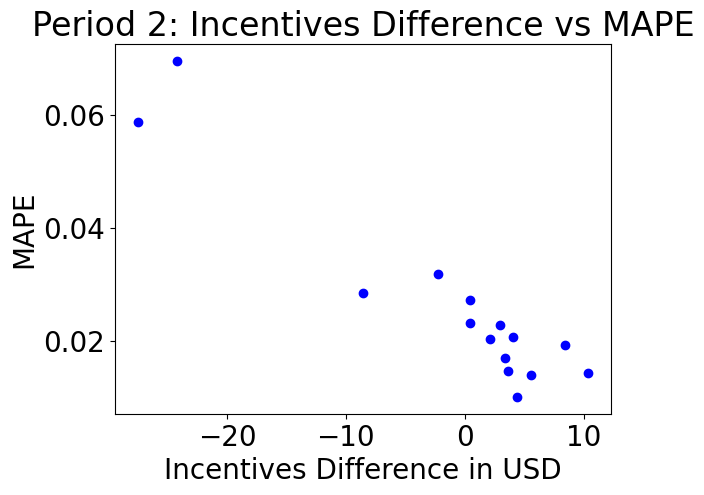

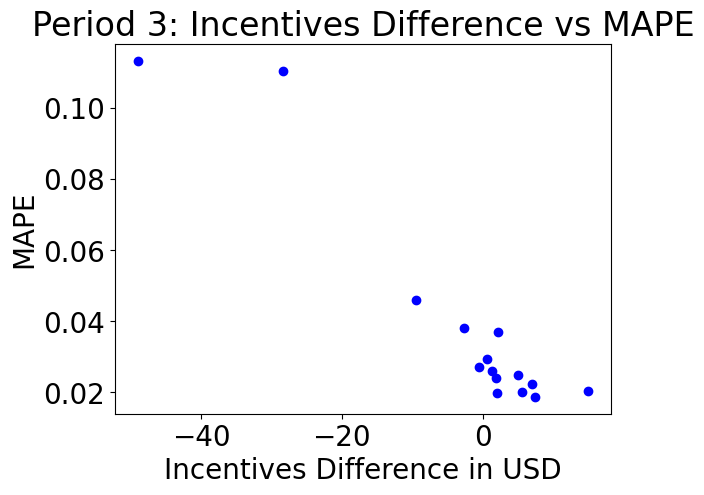

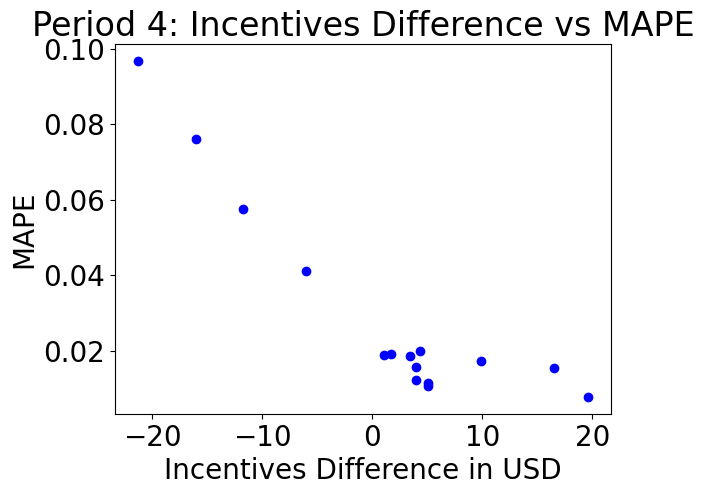

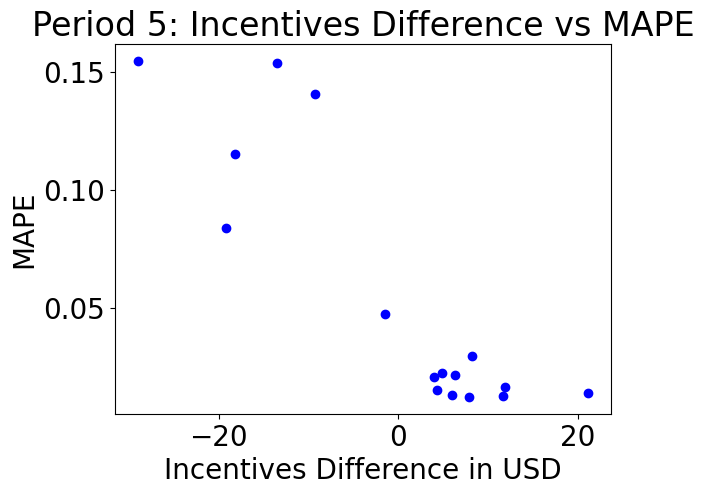

In [43]:
# Plot scatter plots for each period between incentives differences and errors
for index,period in enumerate(op_data_periods_cl):
    incentives = []
    operators = []
    mape = []
    rmse = []
    max_dev = []
    for op in operator_names:
        if op in incentives_differences[period]:
            incentives.append(incentives_differences[period][op])
            mape.append(op_data_periods_cl[period]["mape"][op])
            rmse.append(op_data_periods_cl[period]["rmse"][op])
            max_dev.append(op_data_periods_cl[period]["maximum_deviation"][op])
            operators.append(op)
            
            
    # Create a scatter plot for mape
    plt.scatter(incentives, mape, color='blue', marker='o', label='Data Points')
    # Add labels and title
    plt.xlabel('Incentives Difference in USD')
    plt.ylabel('MAPE')
    plt.title('Period '+str(index+1)+': Incentives Difference vs MAPE')
    plt.savefig(deviation_threshold_dir_path+'/period'+str(index+1)+'_newincentivesdiffMAPE_corr_simple.png', bbox_inches='tight')
    # Show the plot
    plt.show()
    

### Plot a scatter plot showing the percentage differences between incentives in USD against MAPE of all periods in one plot

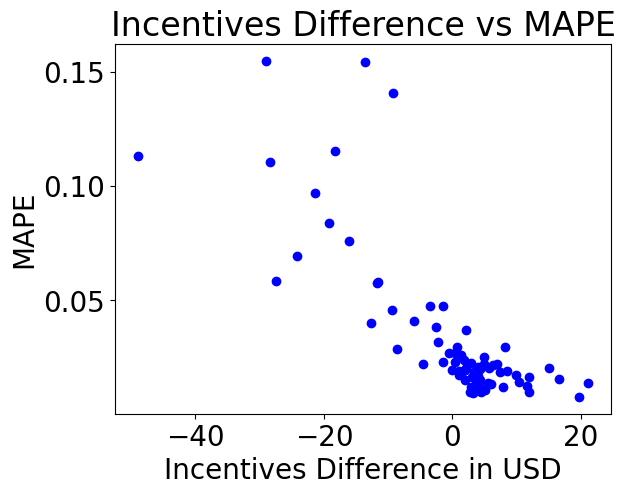

In [44]:
# Plot scatter plots for each period between incentives differences and errors
incentives = []
operators = []
mape = []
rmse = []
max_dev = []
for index,period in enumerate(op_data_periods_cl):
    
    for op in operator_names:
        if op in incentives_differences[period]:
            incentives.append(incentives_differences[period][op])
            mape.append(op_data_periods_cl[period]["mape"][op])
            rmse.append(op_data_periods_cl[period]["rmse"][op])
            max_dev.append(op_data_periods_cl[period]["maximum_deviation"][op])
            operators.append(op)
            
# Create a scatter plot for mape
plt.scatter(incentives, mape, color='blue', marker='o', label='Data Points')
# Add labels and title
plt.xlabel('Incentives Difference in USD')
plt.ylabel('MAPE')
plt.title('Incentives Difference vs MAPE')
# plt.savefig(deviation_threshold_dir_path+'/period'+str(index+1)+'_newincentivesdiffMAPE_corr.png', bbox_inches='tight')
# Show the plot
plt.show()
    

### Calculate the Spearman's Coefficient and the p-value for the relationship between percentage differences of incentives and the MAPE value

In [45]:
# Assuming you have two arrays: array1 and array2
correlation_coefficient, p_value = spearmanr(mape, incentives)
print("Spearman coefficient", correlation_coefficient)
print("p-value", p_value)

Spearman coefficient -0.762323991797676
p-value 1.2483031684264061e-15


### Plot a scatter plot showing the proposed incentives in USD against MAPE of all periods in one plot

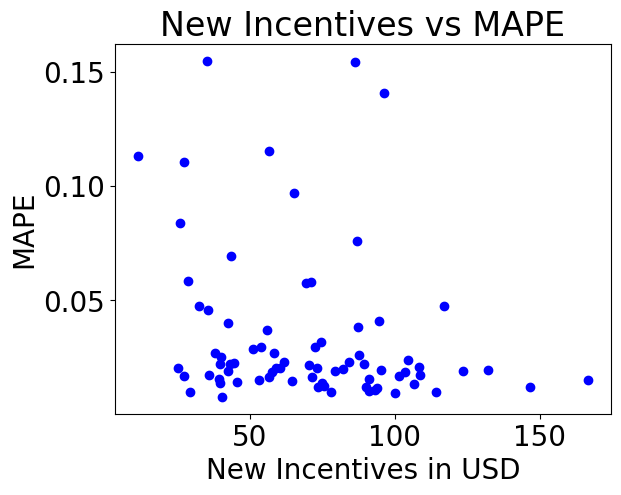

In [46]:
# Plot scatter plots for each period between incentives differences and errors
incentives = []
operators = []
mape = []
rmse = []
max_dev = []
for index,period in enumerate(op_data_periods_cl):
    
    for op in operator_names:
        if op in period_earnings_incentivisation_scheme[period]:
            incentives.append(period_earnings_incentivisation_scheme[period][op])
            mape.append(op_data_periods_cl[period]["mape"][op])
            rmse.append(op_data_periods_cl[period]["rmse"][op])
            max_dev.append(op_data_periods_cl[period]["maximum_deviation"][op])
            operators.append(op)
            

# Create a scatter plot for mape
plt.scatter(incentives, mape, color='blue', marker='o', label='Data Points')
# Add labels and title
plt.xlabel('New Incentives in USD')
plt.ylabel('MAPE')
plt.title('New Incentives vs MAPE')
plt.savefig(deviation_threshold_dir_path+'/allperiods_usdincvsmape_incentivisationmechanism.png', bbox_inches='tight')
# Show the plot
plt.show()
    

### Calculate the Spearman's Coefficient and the p-value for the relationship between proposed incentives in USD and the MAPE value

In [47]:
# Assuming you have two arrays: array1 and array2
correlation_coefficient, p_value = spearmanr(mape, incentives)
print("Spearman coefficient", correlation_coefficient)
print("p-value", p_value)

Spearman coefficient -0.296431989063568
p-value 0.009318921641242645


### Plot a scatter plot showing the proposed incentives in LINK normalised by transmission counts against MAPE of all periods in one plot

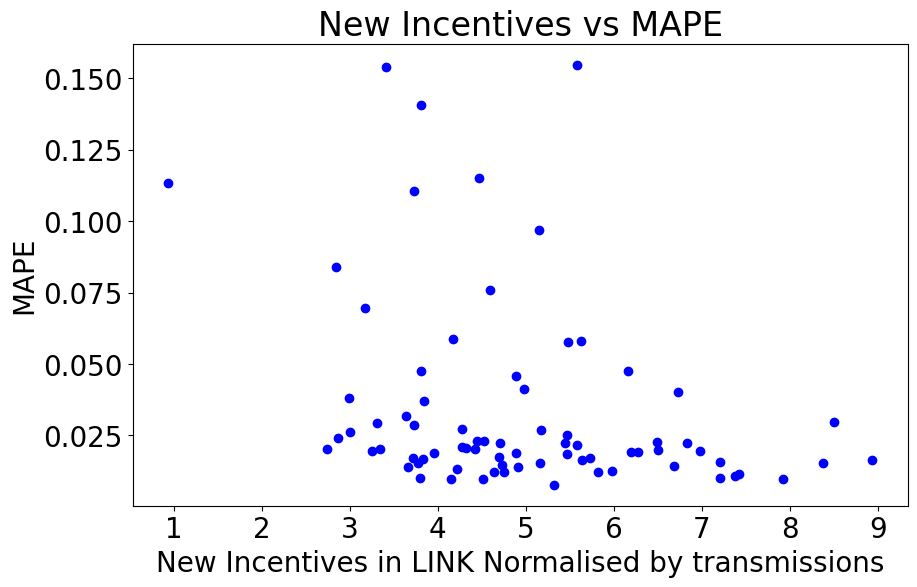

In [48]:
# Plot scatter plots for each period between incentives differences and errors
incentives = []
operators = []
mape = []
rmse = []
max_dev = []
for index,period in enumerate(op_data_periods_cl):
    
    for op in operator_names:
        if op in period_earnings_incentivisation_scheme_link_normalised[period]:
            incentives.append(period_earnings_incentivisation_scheme_link_normalised[period][op])
            mape.append(op_data_periods_cl[period]["mape"][op])
            rmse.append(op_data_periods_cl[period]["rmse"][op])
            max_dev.append(op_data_periods_cl[period]["maximum_deviation"][op])
            operators.append(op)
            

# Create a scatter plot for mape
plt.figure(figsize=(10, 6)) 
plt.rcParams['font.size'] = 20
plt.scatter(incentives, mape, color='blue', marker='o', label='Data Points')
# Add labels and title
plt.xlabel('New Incentives in LINK Normalised by transmissions')
plt.ylabel('MAPE')
plt.title('New Incentives vs MAPE')
plt.savefig(deviation_threshold_dir_path+'/allperiods_linkincvsmape_incentivisationmechanism.png', bbox_inches='tight')
# Show the plot
plt.show()
    

### Calculate the Spearman's Coefficient and the p-value for the relationship between proposed incentives in LINK normalised by transmission counts and the MAPE value

In [49]:
# Assuming you have two arrays: array1 and array2
correlation_coefficient, p_value = spearmanr(mape, incentives)
print("Spearman coefficient", correlation_coefficient)
print("p-value", p_value)

Spearman coefficient -0.3260697197539303
p-value 0.004046589729937796


# Proposed Penalisation Scheme

Penalise operators with a deviation of more than or equal to the deviation threshold with a penalty of double the amount of LINK Gwei offered for a correct observation at the time of withdrawal. Then, split this penalty split amongst operators whose submission was within the acceptable thresholds for that round.

### Calculate incentives by simulating the penalisation scheme for each chosen period

This is done by going over each submission and calculating its deviation from the aggregated answer. If the submission's deviation exceeds the deviation threshold, it is considered as an operator's misbehvaiour. This operator is penalised and the penalty amount is split amongst operators whose submission was within the acceptable thresholds for that round.

In [50]:
# Get all withdrawal block numbers, not only those done by Chainlink but also done by operators themselves
unique_withdrawal_blocks = withdrawals["blockNumber"].unique()
# Get billing params
billing_params_filename = "data/"+feed_details["path"]+"/billing_params.json"
with open(billing_params_filename, 'r') as file:
    billing_params = json.load(file)

# Get billing params per withdrawal block
billing_params_per_withdrawal_block = {}
for block in unique_withdrawal_blocks:
    billing_params_per_withdrawal_block[block] = get_block_billing(block, billing_params)
    
# Calculate earnings per period
period_earnings_penalisation_scheme = {}
period_earnings_penalisation_scheme_link_normalised = {}

# Keep amounts of misbehaviours per period
period_misbehaviours = {}

# Keep transmission counts
op_transmission_counts = {}
        
# Loop through each chosen period
for period in chosen_periods:
    operator_extra_incentives = {}
    operator_extra_incentives_link = {}
    period_key = period["from"] +" -> "+period["to"]
    period_misbehaviours[period_key] = {}
    period_earnings_penalisation_scheme[period_key] = {}
    period_earnings_penalisation_scheme_link_normalised[period_key] = {}
    op_transmission_counts[period_key] = {}
    
    from_date = datetime.strptime(period["from"], "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc)
    to_date = datetime.strptime(period["to"], "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc)
    
    # Get transmissions in period
    transmissions_period = all_transmissions[(all_transmissions['date'] <= to_date) & (all_transmissions['date'] > from_date)]
    
    for op in operator_names:
        
        
        # Get operator's address
        op_addr = get_op_addr(nops,op)
        
        # Get all submissions in period
        op_submissions_period = pd.read_csv(path+"/per_op/"+op+"/submissions.csv")
        op_submissions_period.rename(columns={op+"_answer": 'answer'}, inplace=True)
        op_submissions_period["answer"] = op_submissions_period["answer"]
        op_submissions_period['timestamp'] = op_submissions_period['timestamp'] * 1000
        op_submissions_period["date"] = pd.to_datetime(op_submissions_period['timestamp'], unit='ms', utc=True)
        op_submissions_period = op_submissions_period[(op_submissions_period['date'] <= to_date) & (op_submissions_period['date'] > from_date)]
        
        # Get payments in period
        op_payments = pd.read_csv(path+"/per_op/"+op+"/payments.csv")
        op_payments['txTimestamp'] = op_payments['txTimestamp'] * 1000
        op_payments["date"] = pd.to_datetime(op_payments['txTimestamp'], unit='ms', utc=True)
        op_payments["blockNumber"] = op_payments["blockNumber"].astype(str)
        op_payments["linkPrice"] = op_payments["blockNumber"].map(link_prices)
        op_payments["usdAmount"] = op_payments["linkPrice"] * op_payments["amount"]
        op_payments = op_payments[(op_payments['date'] <= to_date) & (op_payments['date'] > from_date)]
        
        # Get operators transmission counts
        op_transmission_counts[period_key][op] = len(transmissions_period[transmissions_period['submitter'] == op_addr])
        
        
        # Get link prices per block
        amount_paid = op_payments["usdAmount"].sum()
        amount_paid_link = op_payments["amount"].sum()
        # If there were payments made
        
        penalty = 0
        reduce_rewards = 0
        reduce_rewards_link = 0
        
        if amount_paid > 0 or amount_paid_link > 0:
            last_date = ""
            # Loop through each withdrawal and get submissions until that date to calculate errors
            for withdrawal_index, withdrawal_row in op_payments.iterrows():
                withdrawal_date = withdrawal_row["date"]
                
                # Get billing params at date
                reward_rate = (billing_params_per_withdrawal_block[int(withdrawal_row["blockNumber"])]["linkGweiPerObservation"] / 1000000000.0) * withdrawal_row["linkPrice"]
                reward_rate_link = (billing_params_per_withdrawal_block[int(withdrawal_row["blockNumber"])]["linkGweiPerObservation"] / 1000000000.0)
                
                # if there was no previous date
                if last_date == "":
                    op_submissions_withdrawal = op_submissions_period[op_submissions_period['date'] <= withdrawal_date]
                else: 
                    op_submissions_withdrawal = op_submissions_period[(op_submissions_period['date'] > last_date) & (op_submissions_period['date'] <= withdrawal_date)]
                
                # Holds operator misbehaviours
                op_misbehaviours = 0
                # Loop through submissions during withdrawal to find misbehaviours
                for submission_index, submission_row in op_submissions_withdrawal.iterrows():
                    upper_limit = submission_row["aggregatedAnswer"] * (1+deviation_threshold)
                    lower_limit = submission_row["aggregatedAnswer"] * (1-deviation_threshold)
                    operator_deviation = (abs(submission_row["answer"] - submission_row["aggregatedAnswer"]) / submission_row["aggregatedAnswer"]) * 100
                    # if deviated more than threshold
                    if operator_deviation > deviation_threshold:
                        op_misbehaviours += 1
                        # Get correct operators
                        correct_oracles = [col for col in submission_row.index if col.endswith('_answer') and submission_row[col] <= upper_limit and submission_row[col] >= lower_limit]
                        correct_oracles = [element[:-7] for element in correct_oracles]
                        # For each correct oracle, add extra incentive
                        for correct_oracle in correct_oracles:
                            # Extra incentive is the penalty amount divided by the correct operators
                            if not (correct_oracle in operator_extra_incentives):
                                operator_extra_incentives[correct_oracle] = 0
                                operator_extra_incentives_link[correct_oracle] = 0
                            operator_extra_incentives[correct_oracle] += (reward_rate * 3) / float(len(correct_oracles))
                            operator_extra_incentives_link[correct_oracle] += (reward_rate_link * 3) / float(len(correct_oracles))
                        
                period_misbehaviours[period_key][op] = (op_misbehaviours / len(op_submissions_withdrawal)) * 100
                # Calculate penalty by multiplying reward_rate * 2 * operator_misbehaviours
                # We need this to reduce the incentive given for these submissions before
                reduce_rewards += reward_rate * 2 * op_misbehaviours
                reduce_rewards_link += reward_rate_link * 2 * op_misbehaviours
                
            
            period_earnings_penalisation_scheme[period_key][op] = amount_paid - reduce_rewards
            period_earnings_penalisation_scheme_link_normalised[period_key][op] = amount_paid_link - reduce_rewards_link

            # For each oracle, add extra incentives
    for operator_name in operator_extra_incentives:
        if operator_name in period_earnings_penalisation_scheme[period_key]:
            period_earnings_penalisation_scheme[period_key][operator_name] += operator_extra_incentives[operator_name]
            if operator_name in operator_extra_incentives_link and float(op_transmission_counts[period_key][operator_name]) > 0:
                period_earnings_penalisation_scheme_link_normalised[period_key][operator_name] += operator_extra_incentives_link[operator_name]
                period_earnings_penalisation_scheme_link_normalised[period_key][operator_name] /= float(op_transmission_counts[period_key][operator_name])
            
        

### Plot the number of misbehaviours and the differences between the original incentives and the incentives after the introduction of the proposed penalisation scheme for each period

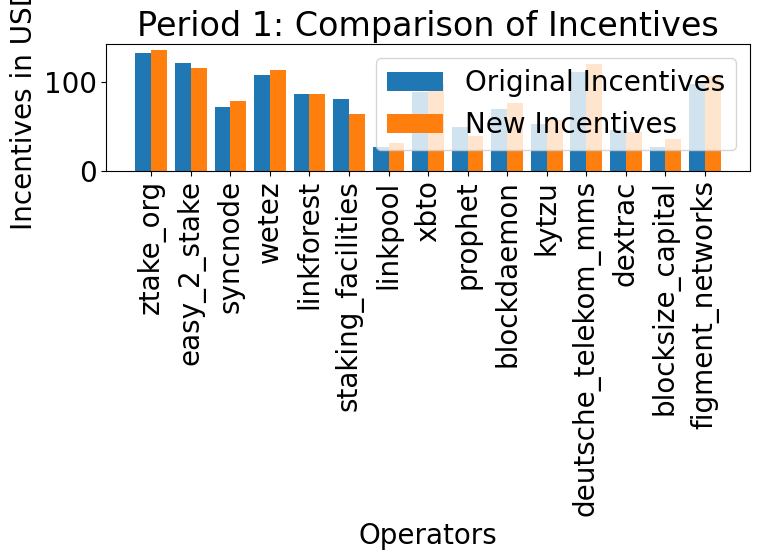

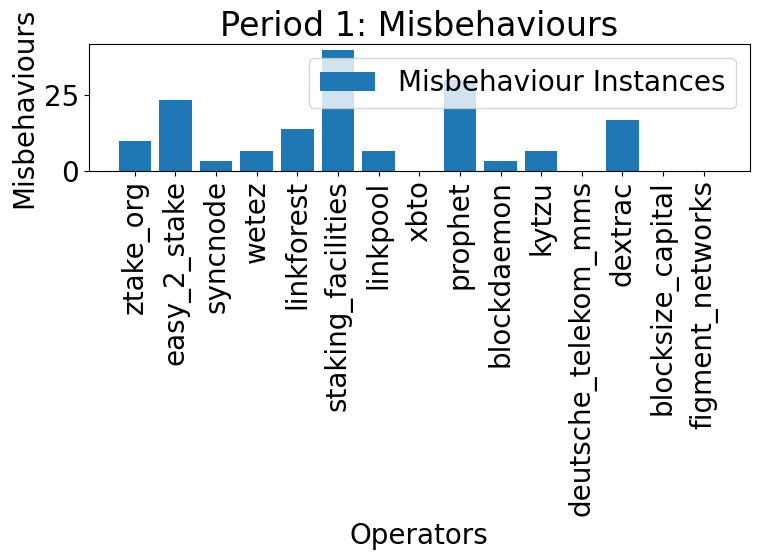

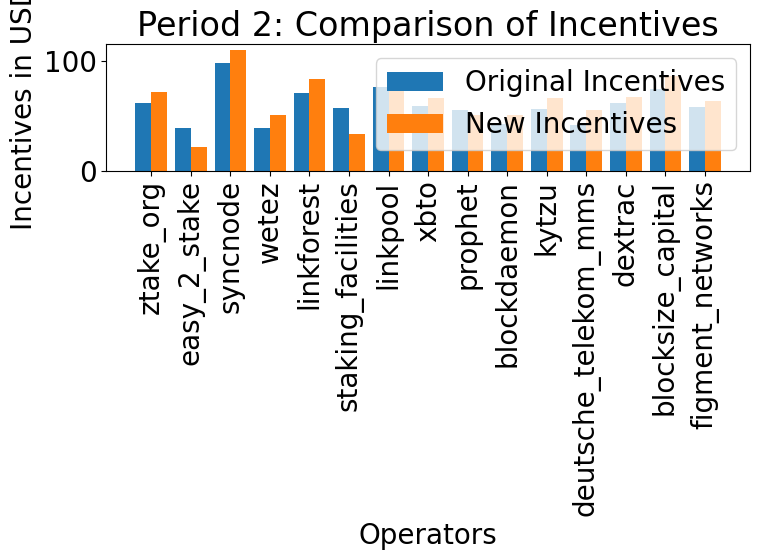

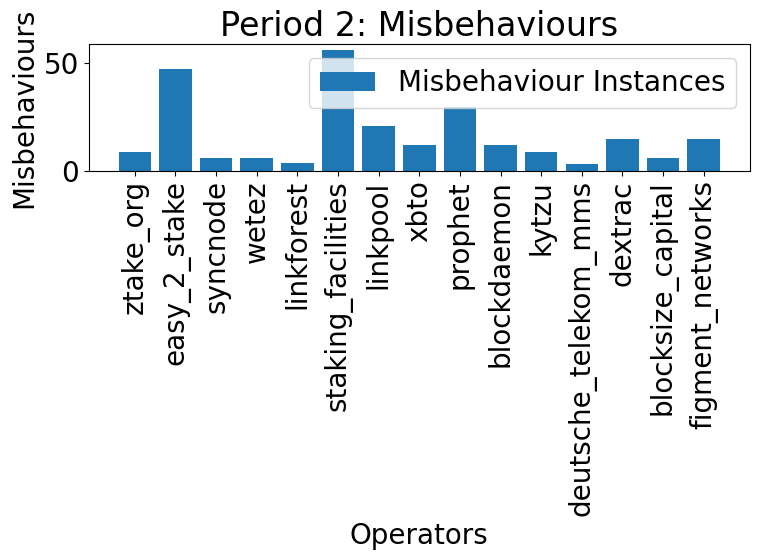

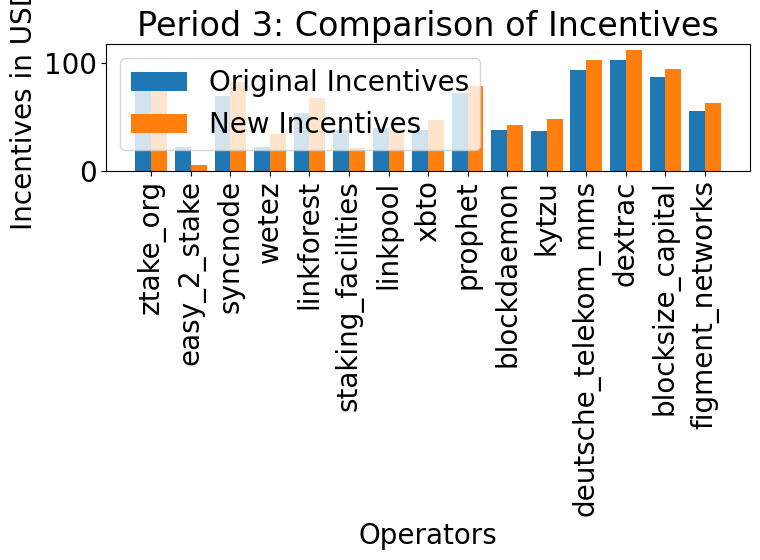

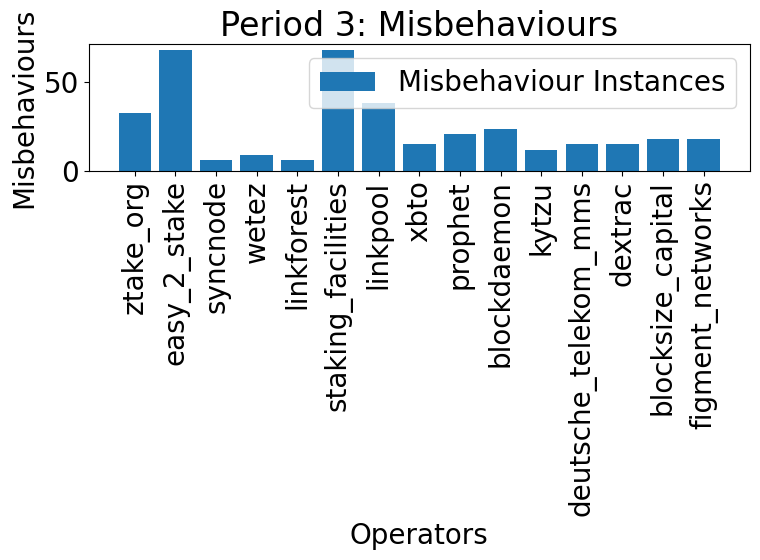

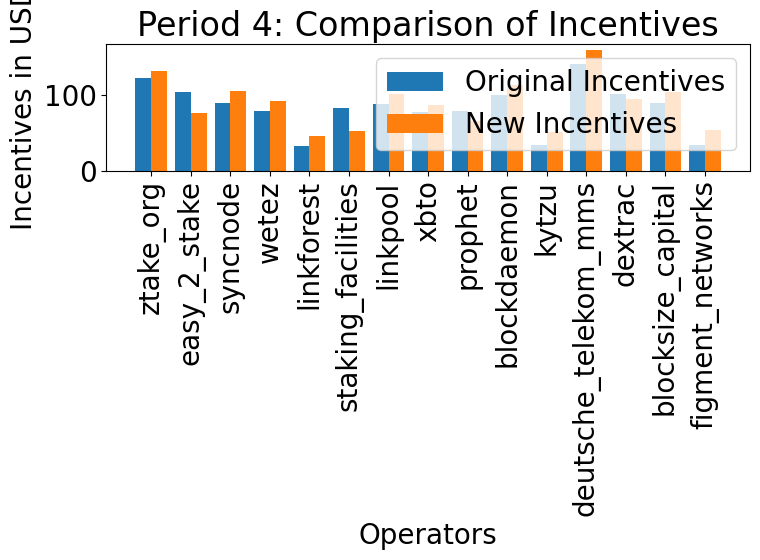

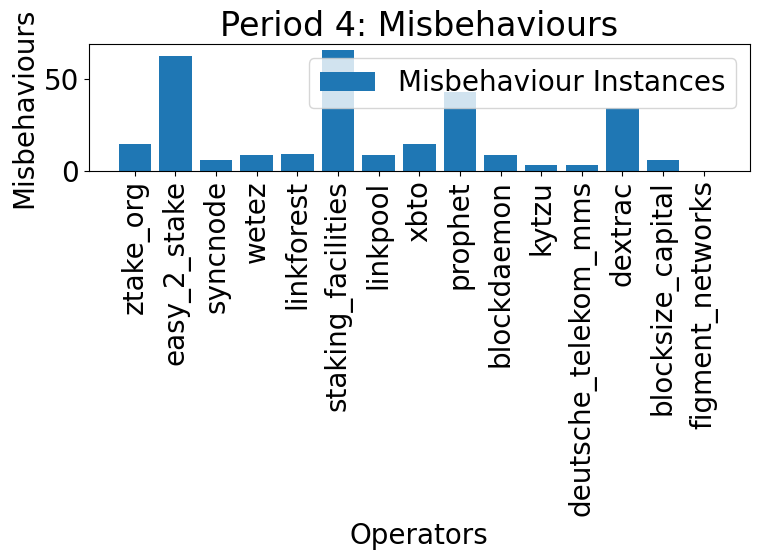

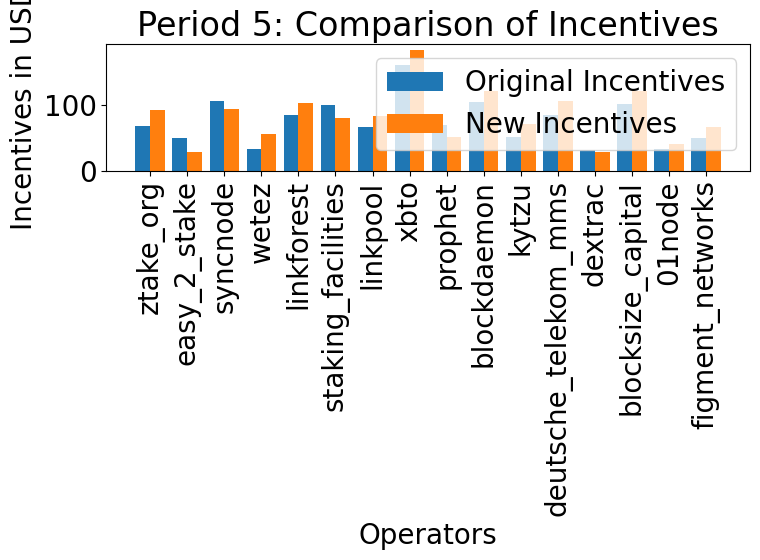

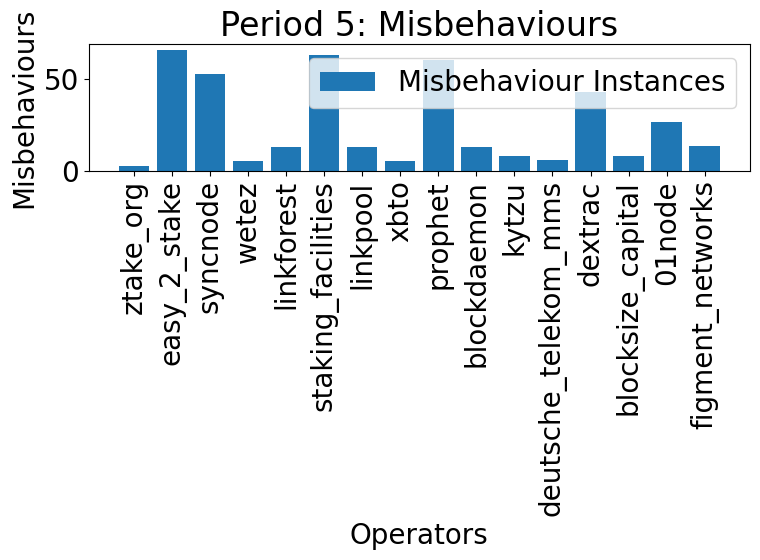

In [51]:
for index,period in enumerate(op_incentives_periods_usd):
    
    traditional_incentives = op_incentives_periods_usd[period]
    penalisation_scheme_incentives = period_earnings_penalisation_scheme[period]

    # Extract names and values
    operators = list(op_incentives_periods_usd[period].keys())
    values_ti = list(traditional_incentives.values())
    values_pi = [penalisation_scheme_incentives[op] if op in traditional_incentives else 0 for op in operators]

    # Create positions for bars
    x = range(0, len(operators))
    # Create the bar graph
    plt.figure(figsize=(8, 6))
    plt.rcParams['font.size'] = 20
    plt.bar(x, values_ti, width=0.4, label='Original Incentives')
    plt.bar([pos + 0.4 for pos in x], values_pi, width=0.4, label='New Incentives')

    # Add labels and title
    plt.xlabel('Operators')
    plt.xticks(rotation=90)
    plt.ylabel('Incentives in USD')
    plt.title('Period '+str(index+1)+': Comparison of Incentives')
    plt.xticks([pos + 0.2 for pos in x], operators)
    plt.legend()
    plt.savefig(deviation_threshold_dir_path+'/period'+str(index+1)+'_inccomparison_penalty.png', bbox_inches='tight')
    plt.tight_layout()
    plt.show()
    
    keys = list(period_misbehaviours[period].keys())
    x = range(0, len(keys))
    values = list(period_misbehaviours[period].values())
    plt.figure(figsize=(8, 6)) 
    plt.rcParams['font.size'] = 20
    plt.bar(x, values, label='Misbehaviour Instances')
    plt.xlabel('Operators')
    plt.xticks(rotation=90)
    plt.ylabel('Misbehaviours')
    plt.title('Period '+str(index+1)+': Misbehaviours')
    plt.xticks(x, keys)
    plt.legend()
    plt.savefig(deviation_threshold_dir_path+'/period'+str(index+1)+'_misbehaviours_penalty.png', bbox_inches='tight')
    plt.tight_layout()
    plt.show()


### Plot the differences between the incentives with penalisation and without penalisation for each round

In [52]:
incentivisation_scheme_incentives

{'ztake_org': 75.55602548085551,
 'easy_2_stake': 35.28510280619639,
 'syncnode': 96.31707037184376,
 'wetez': 39.75562858640299,
 'linkforest': 89.27104677643317,
 'staking_facilities': 86.22276633122301,
 'linkpool': 70.55925016098139,
 'xbto': 166.8626218374103,
 'prophet': 56.47175810929446,
 'blockdaemon': 108.23816696223335,
 'kytzu': 56.51609155342811,
 'deutsche_telekom_mms': 90.21625368810902,
 'dextrac': 25.80057622563244,
 'blocksize_capital': 106.77903928177011,
 '01node': 32.31116168867882,
 'figment_networks': 53.72566355851383}

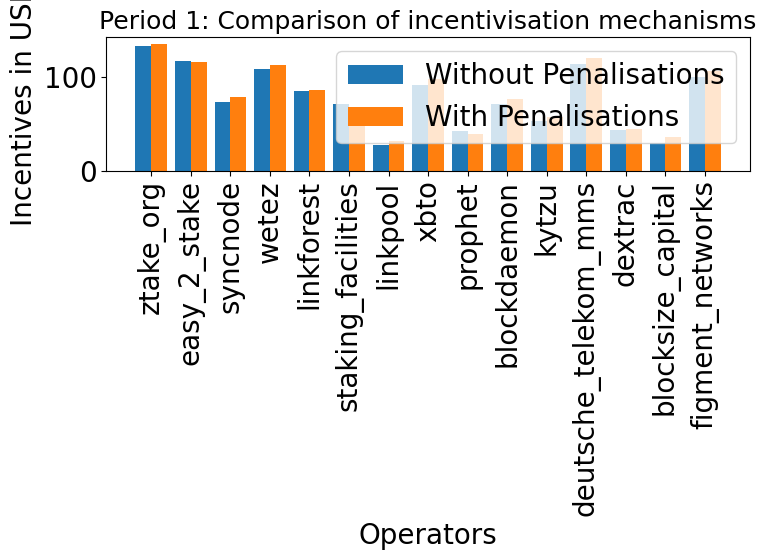

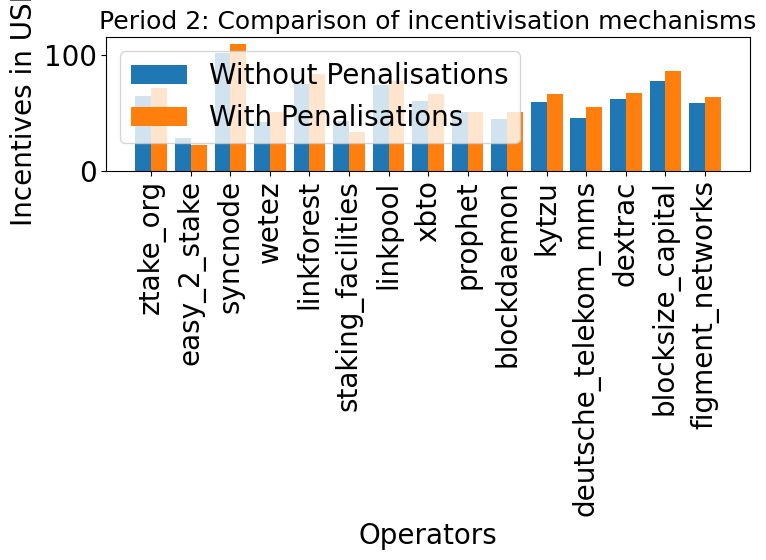

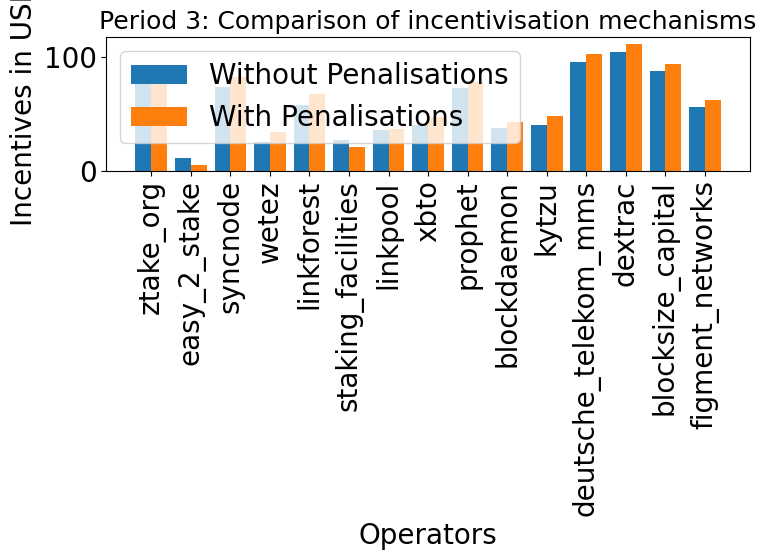

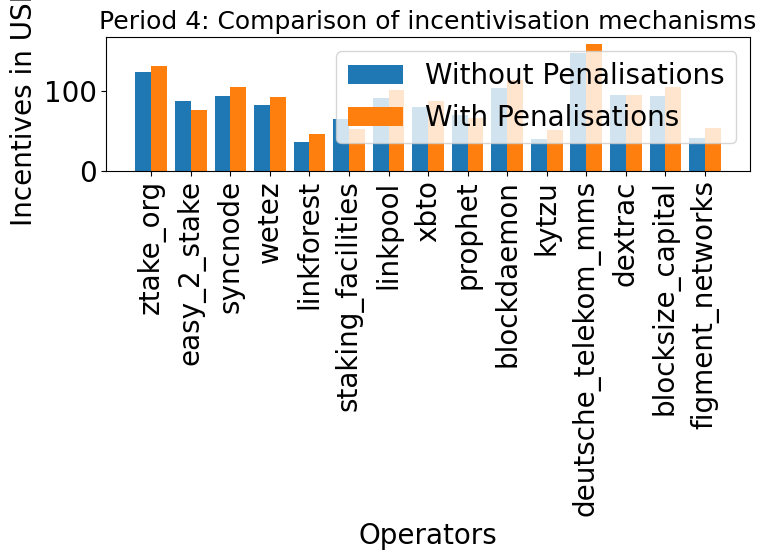

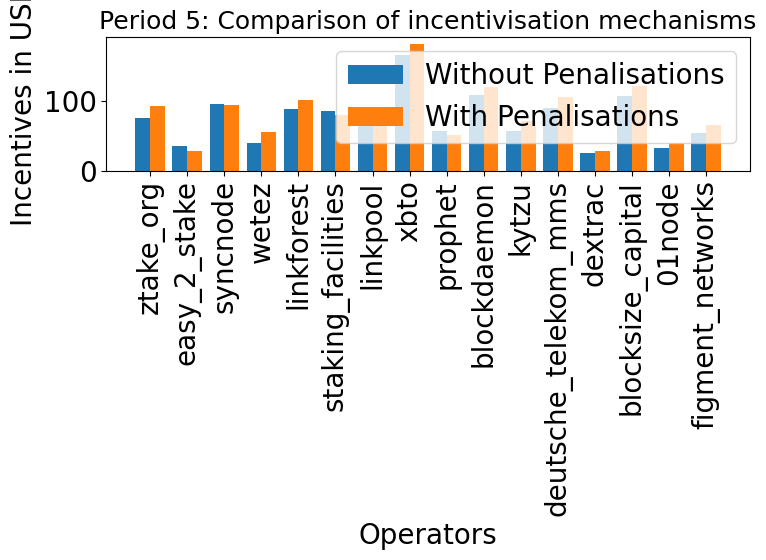

In [53]:
for index,period in enumerate(period_earnings_incentivisation_scheme):
    
    incentivisation_scheme_incentives = period_earnings_incentivisation_scheme[period]
    penalisation_scheme_incentives = period_earnings_penalisation_scheme[period]

    # Extract names and values
    operators = list(incentivisation_scheme_incentives.keys())
    values_ti = list(incentivisation_scheme_incentives.values())
    values_pi = [penalisation_scheme_incentives[op] if op in incentivisation_scheme_incentives else 0 for op in operators]

    # Create positions for bars
    x = range(0, len(operators))
    # Create the bar graph
    
    plt.figure(figsize=(8, 6)) 
    plt.rcParams['font.size'] = 20
    plt.rcParams['axes.titlesize'] = 18 
    plt.bar(x, values_ti, width=0.4, label='Without Penalisations')
    plt.bar([pos + 0.4 for pos in x], values_pi, width=0.4, label='With Penalisations')

    # Add labels and title
    plt.xlabel('Operators')
    plt.xticks(rotation=90)
    plt.ylabel('Incentives in USD')
    plt.title('Period '+str(index+1)+': Comparison of incentivisation mechanisms')
    plt.xticks([pos + 0.2 for pos in x], operators)
    plt.legend()
    plt.savefig(deviation_threshold_dir_path+'/period'+str(index+1)+'_nopenaltyvspenalty.png', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

### Calculate the percentage difference between incentives

In [54]:
# Calculate differences in incentives
incentives_differences = {}

for period in chosen_periods:
    operator_extra_incentives = {}
    period_key = period["from"] +" -> "+period["to"]
    incentives_differences[period_key] = {}
    for op in op_incentives_periods_usd[period_key]:
        incentives_differences[period_key][op] = (period_earnings_penalisation_scheme[period_key][op] - op_incentives_periods_usd[period_key][op]) / op_incentives_periods_usd[period_key][op] * 100
        
incentives_differences

{'2023-05-08 18:51:11 -> 2023-05-15 18:27:23': {'ztake_org': 2.2538173178596965,
  'easy_2_stake': -4.60465527218281,
  'syncnode': 10.141568446720564,
  'wetez': 4.758228072185905,
  'linkforest': 0.016187197326686914,
  'staking_facilities': -20.223946912587525,
  'linkpool': 19.52185714412877,
  'xbto': 10.660520306034876,
  'prophet': -20.20982023815637,
  'blockdaemon': 10.478895801813309,
  'kytzu': 9.851994872226594,
  'deutsche_telekom_mms': 8.266573138983674,
  'dextrac': -2.879654007460623,
  'blocksize_capital': 35.816523811856825,
  'figment_networks': 9.666628078120945},
 '2023-04-24 16:42:59 -> 2023-05-01 20:51:11': {'ztake_org': 15.566300667062208,
  'easy_2_stake': -44.08371391312097,
  'syncnode': 11.982650073100071,
  'wetez': 30.171947378166813,
  'linkforest': 18.06953739382817,
  'staking_facilities': -41.152954008529086,
  'linkpool': 1.8030508480113356,
  'xbto': 12.8915675049032,
  'prophet': -8.705143000053438,
  'blockdaemon': 17.68856236045677,
  'kytzu': 17.

### Plot scatter plats for each period showing the new inventives in USD and LINK normalised against MAPE and RMSE

In [55]:
for index,period in enumerate(op_data_periods_cl):
    print(period)
    for op in operator_names:
        if op in op_incentives_periods_usd[period]:
            print(op)
    print()

2023-05-08 18:51:11 -> 2023-05-15 18:27:23
ztake_org
easy_2_stake
syncnode
wetez
linkforest
staking_facilities
linkpool
xbto
prophet
blockdaemon
kytzu
deutsche_telekom_mms
dextrac
blocksize_capital
figment_networks

2023-04-24 16:42:59 -> 2023-05-01 20:51:11
ztake_org
easy_2_stake
syncnode
wetez
linkforest
staking_facilities
linkpool
xbto
prophet
blockdaemon
kytzu
deutsche_telekom_mms
dextrac
blocksize_capital
figment_networks

2023-03-28 11:11:23 -> 2023-04-03 18:09:35
ztake_org
easy_2_stake
syncnode
wetez
linkforest
staking_facilities
linkpool
xbto
prophet
blockdaemon
kytzu
deutsche_telekom_mms
dextrac
blocksize_capital
figment_networks

2023-05-15 18:27:23 -> 2023-05-23 12:06:47
ztake_org
easy_2_stake
syncnode
wetez
linkforest
staking_facilities
linkpool
xbto
prophet
blockdaemon
kytzu
deutsche_telekom_mms
dextrac
blocksize_capital
figment_networks

2023-08-07 16:23:35 -> 2023-08-14 17:34:59
ztake_org
easy_2_stake
syncnode
wetez
linkforest
staking_facilities
linkpool
xbto
prophet
blo

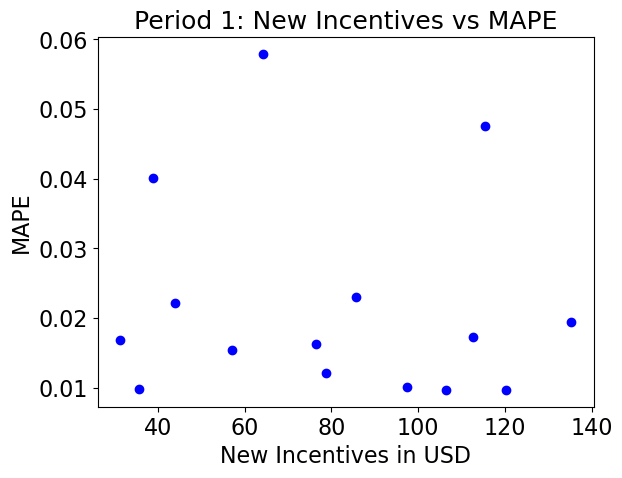

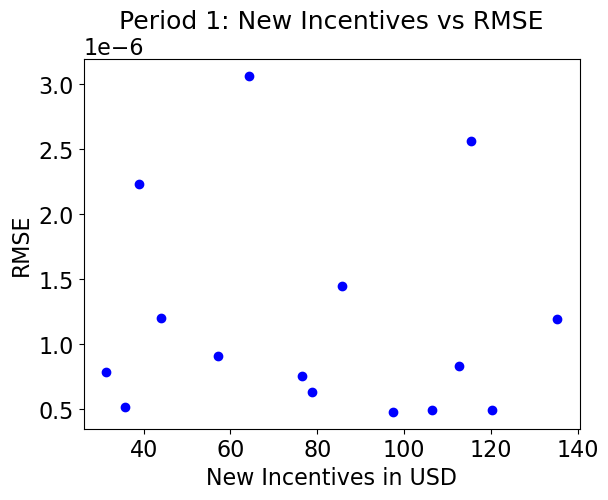

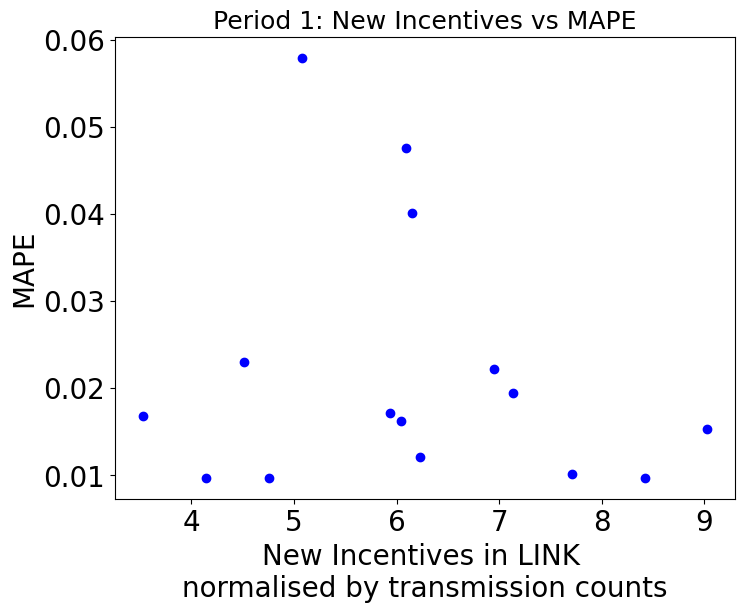

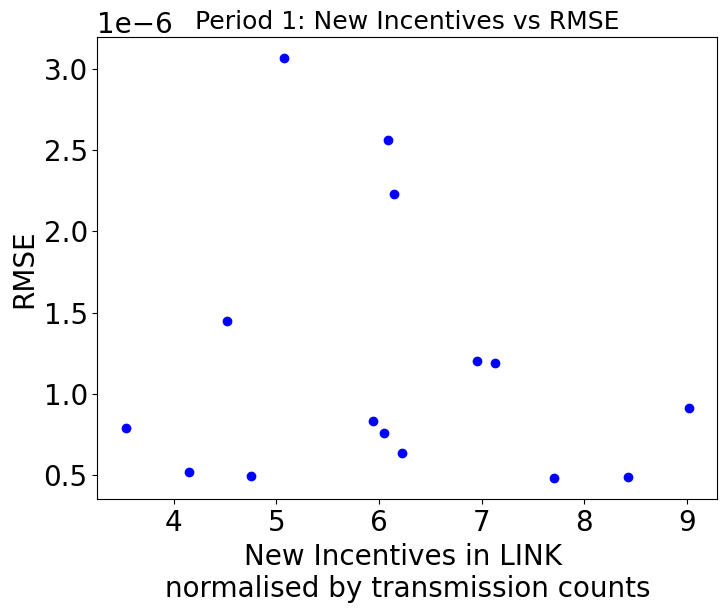

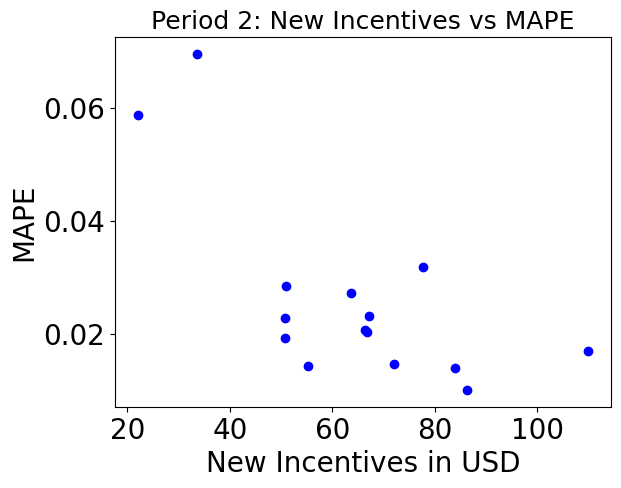

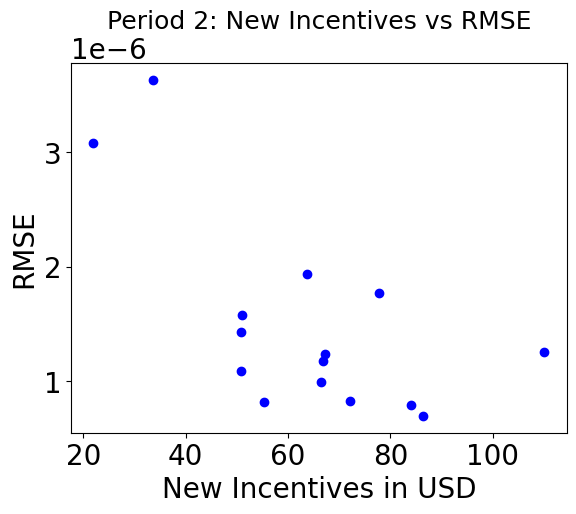

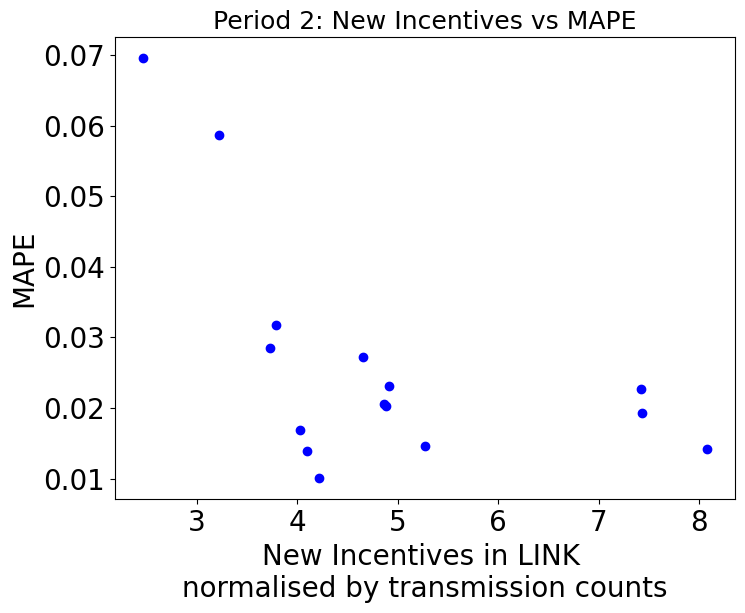

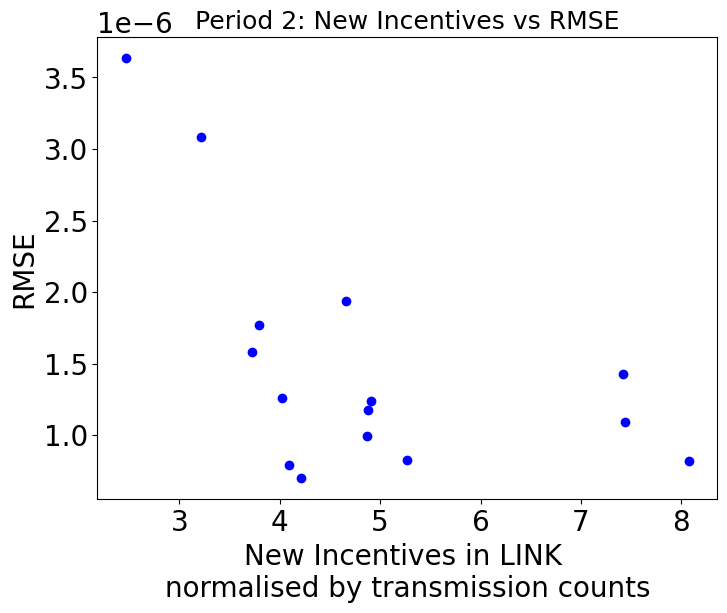

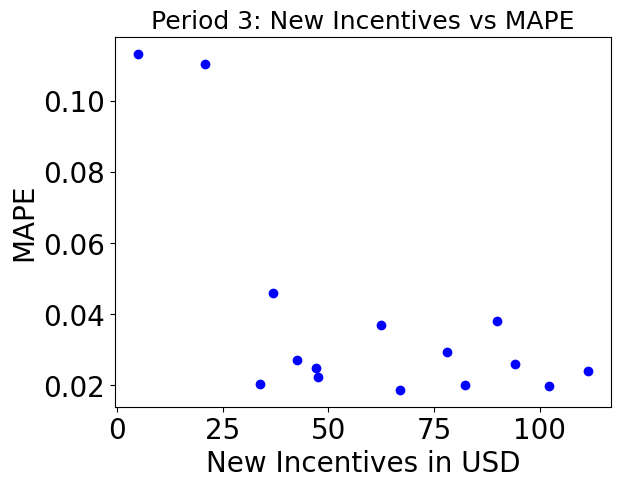

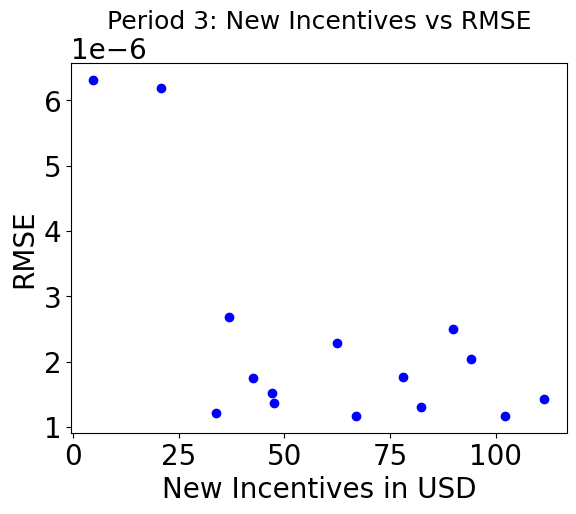

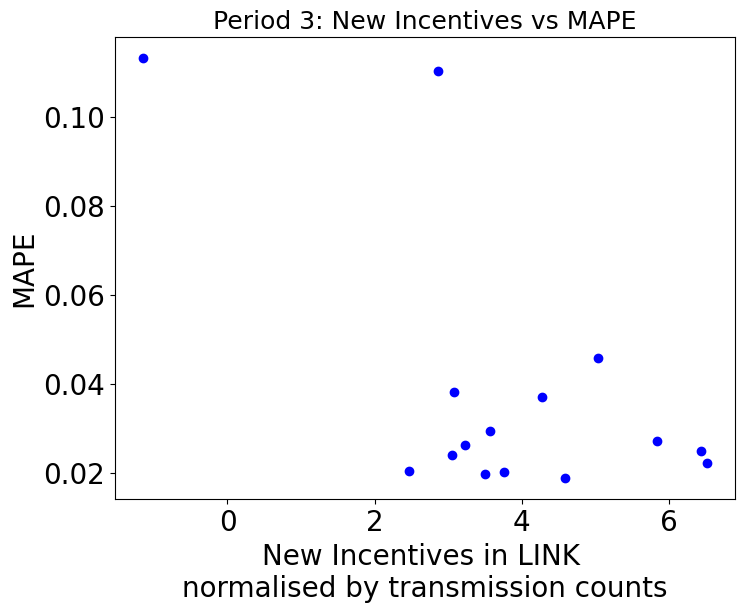

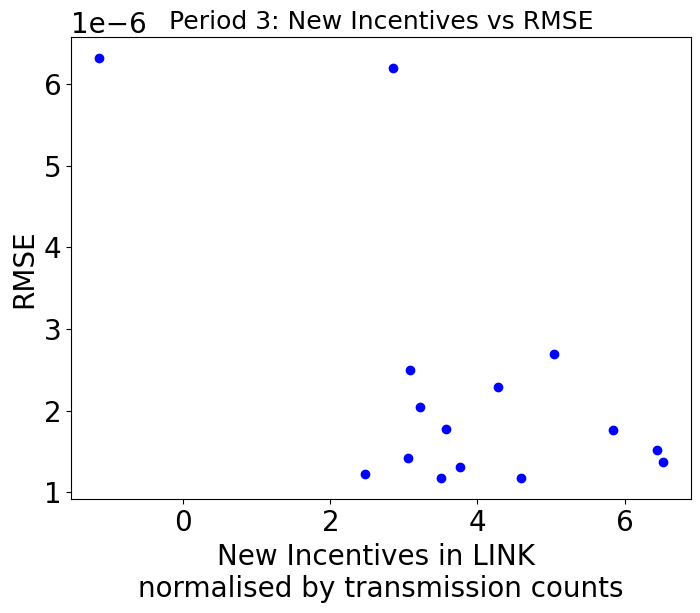

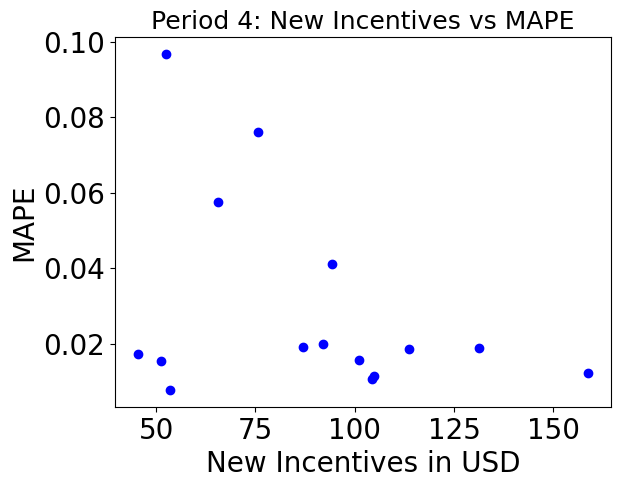

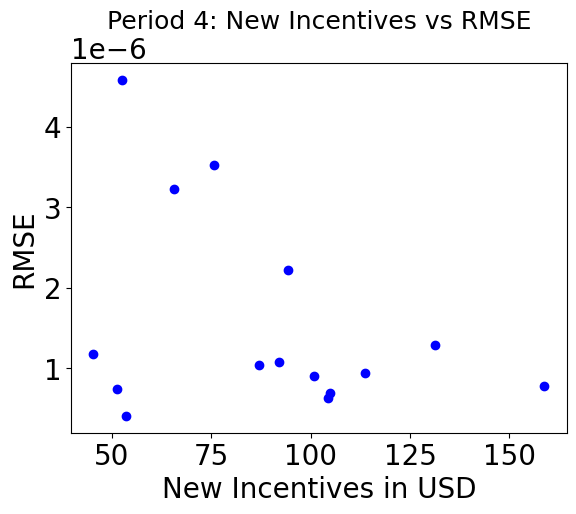

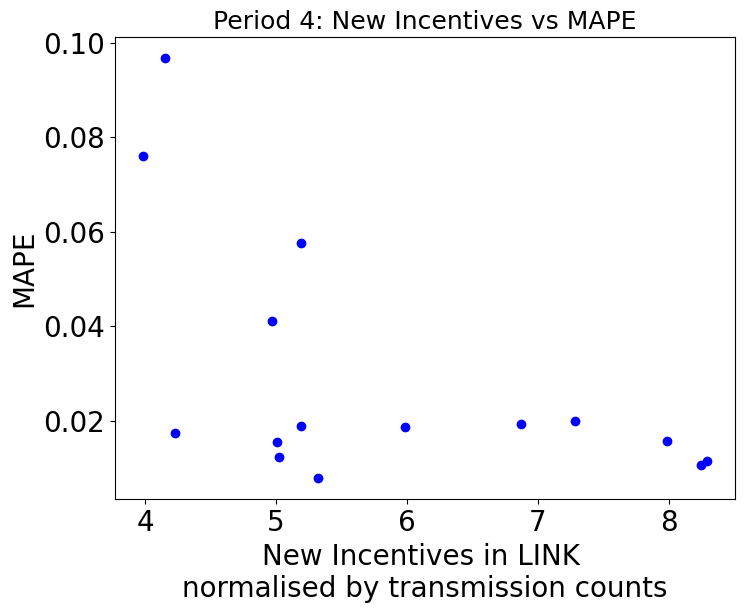

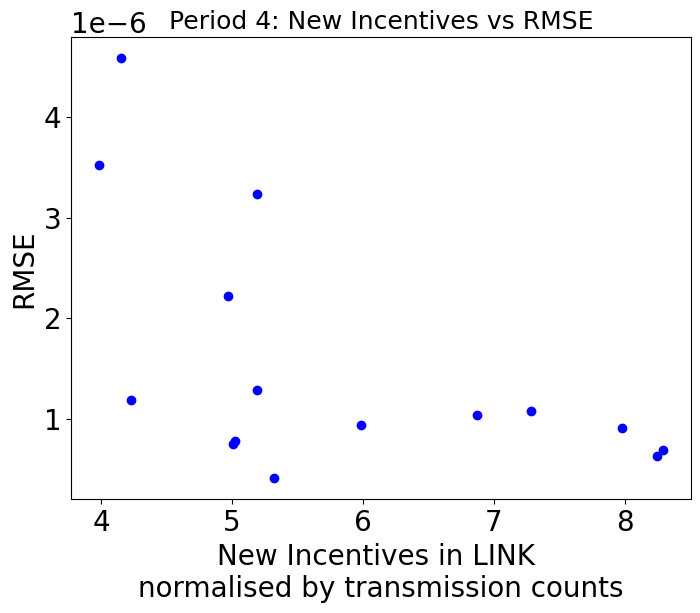

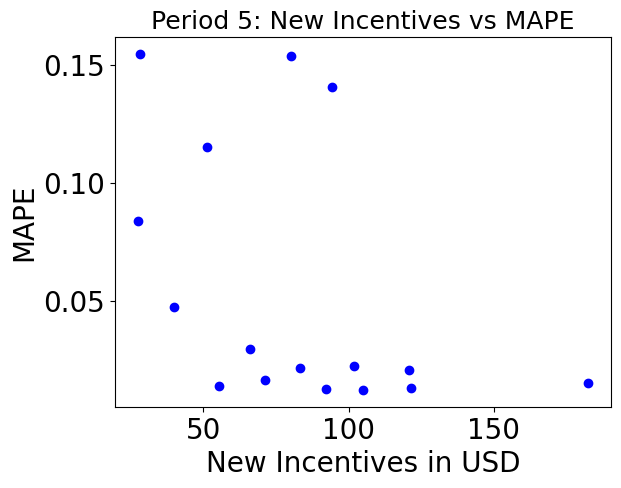

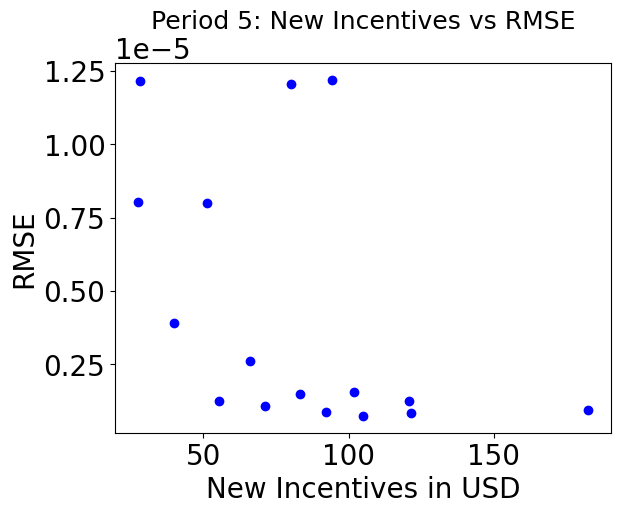

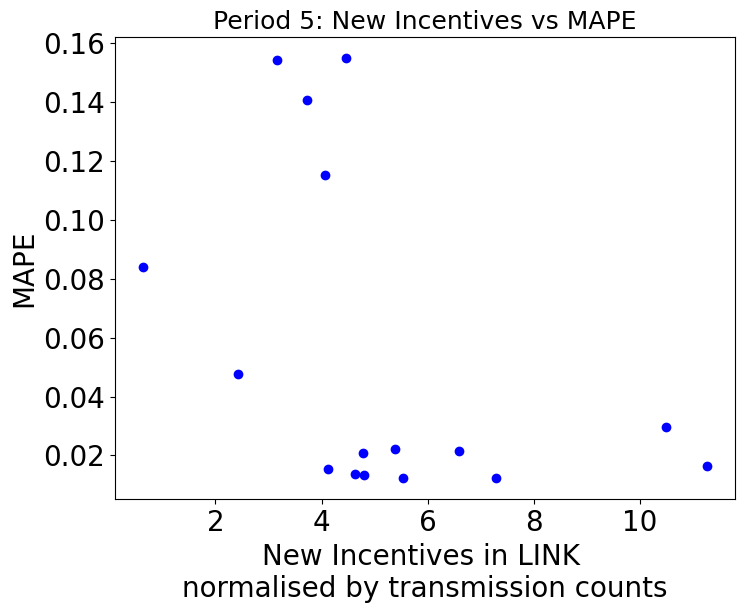

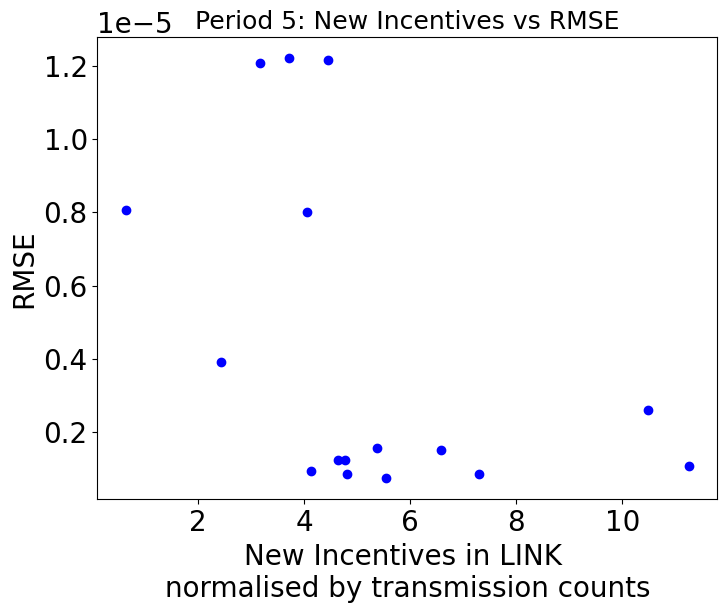

In [56]:
# Plot scatter plots for each period between incentives and errors

plt.figure(figsize=(6.4, 4.8)) 
plt.rcParams['font.size'] = 16
for index,period in enumerate(op_data_periods_cl):
    incentives = []
    incentives_link = []
    operators = []
    mape = []
    rmse = []
    max_dev = []
    for op in operator_names:
        if op in period_earnings_penalisation_scheme[period]:
            incentives.append(period_earnings_penalisation_scheme[period][op])
            incentives_link.append(period_earnings_penalisation_scheme_link_normalised[period][op])
            mape.append(op_data_periods_cl[period]["mape"][op])
            rmse.append(op_data_periods_cl[period]["rmse"][op])
            max_dev.append(op_data_periods_cl[period]["maximum_deviation"][op])
            operators.append(op)
            
    # Create a scatter plot for mape
    plt.scatter(incentives, mape, color='blue', marker='o', label='Data Points')
    # Add labels and title
    plt.xlabel('New Incentives in USD')
    plt.ylabel('MAPE')
    plt.title('Period '+str(index+1)+': New Incentives vs MAPE')
    plt.savefig(deviation_threshold_dir_path+'/period'+str(index+1)+'_newincentivesMAPE_corr_penalty.png', bbox_inches='tight')
    # Show the plot
    plt.show()
    
    # Create a scatter plot for rmse
    plt.scatter(incentives, rmse, color='blue', marker='o', label='Data Points')
    # Add labels and title
    plt.xlabel('New Incentives in USD')
    plt.ylabel('RMSE')
    plt.title('Period '+str(index+1)+': New Incentives vs RMSE')
    plt.savefig(deviation_threshold_dir_path+'/period'+str(index+1)+'_newincentivesRMSE_corr_penalty.png', bbox_inches='tight')
    # Show the plot
    plt.show()

    # Create a scatter plot for mape
    plt.figure(figsize=(8, 6)) 
    plt.rcParams['font.size'] = 20
    plt.scatter(incentives_link, mape, color='blue', marker='o', label='Data Points')
    # Add labels and title
    plt.xlabel('New Incentives in LINK \nnormalised by transmission counts')
    plt.ylabel('MAPE')
    plt.title('Period '+str(index+1)+': New Incentives vs MAPE')
    plt.savefig('figures/period'+str(index+1)+'_newincentivesLINKMAPE_corr_penalty.png', bbox_inches='tight')
    # Show the plot
    plt.show()
    
    # Create a scatter plot for mape
    plt.figure(figsize=(8, 6)) 
    plt.rcParams['font.size'] = 20
    plt.scatter(incentives_link, rmse, color='blue', marker='o', label='Data Points')
    # Add labels and title
    plt.xlabel('New Incentives in LINK \nnormalised by transmission counts')
    plt.ylabel('RMSE')
    plt.title('Period '+str(index+1)+': New Incentives vs RMSE')
    plt.savefig('figures/period'+str(index+1)+'_newincentivesLINKRMSE_corr_penalty.png', bbox_inches='tight')
    # Show the plot
    plt.show()
    

### Plot scatter plots for each period showing the difference between incentives in USD against MAPE

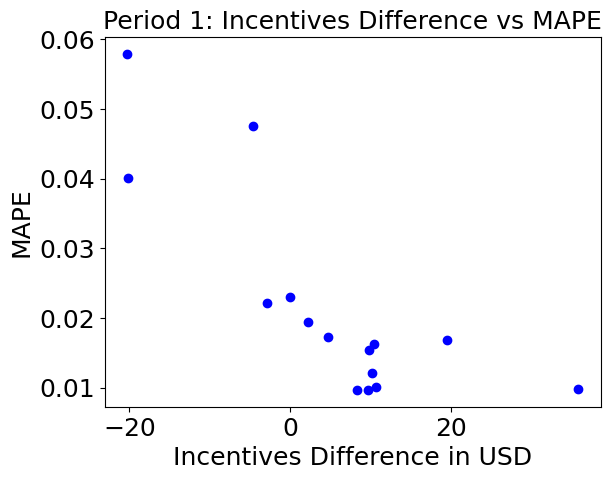

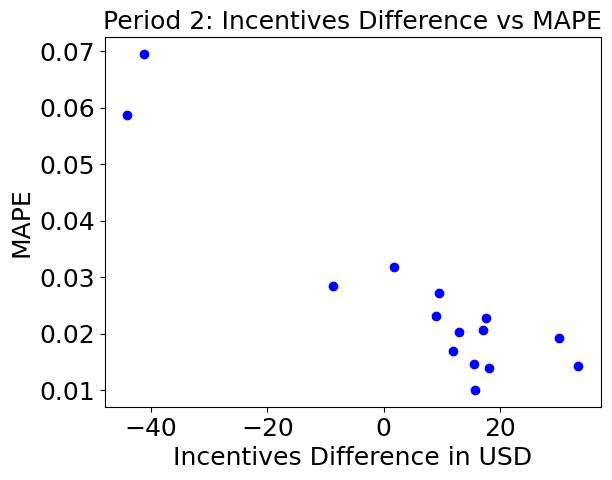

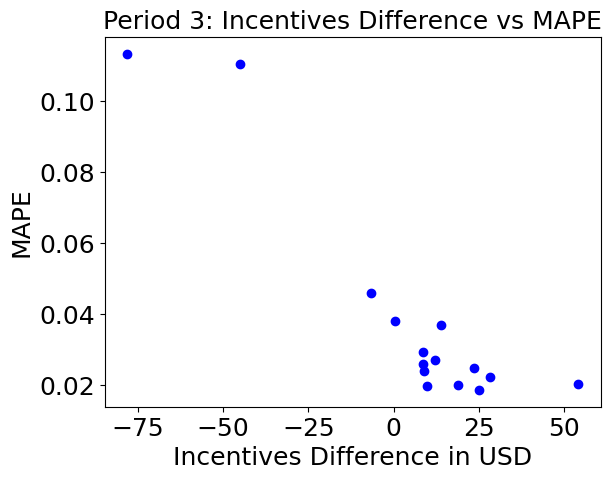

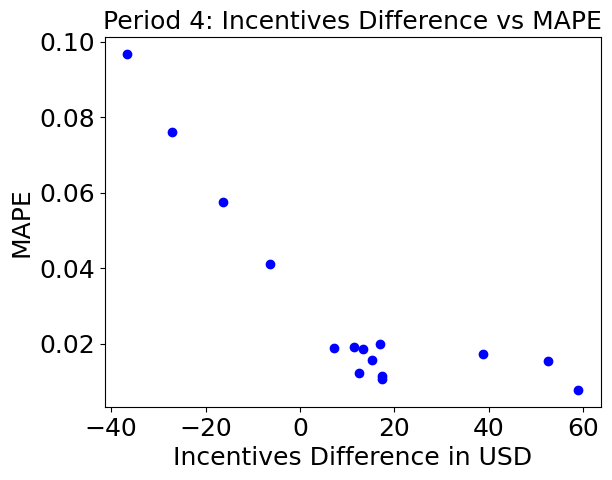

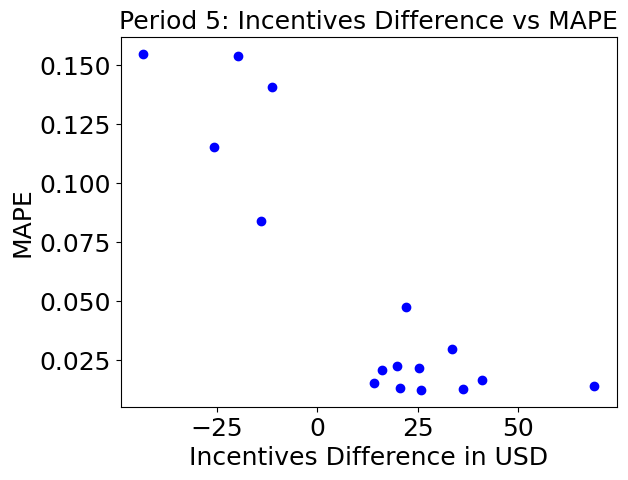

In [61]:
# Plot scatter plots for each period between incentives differences and errors
for index,period in enumerate(op_data_periods_cl):
    incentives = []
    operators = []
    mape = []
    rmse = []
    max_dev = []
    for op in operator_names:
        if op in incentives_differences[period]:
            incentives.append(incentives_differences[period][op])
            mape.append(op_data_periods_cl[period]["mape"][op])
            rmse.append(op_data_periods_cl[period]["rmse"][op])
            max_dev.append(op_data_periods_cl[period]["maximum_deviation"][op])
            operators.append(op)
            
            
    # Create a scatter plot for mape
    plt.scatter(incentives, mape, color='blue', marker='o', label='Data Points')
    # Add labels and title
    plt.xlabel('Incentives Difference in USD')
    plt.ylabel('MAPE')
    plt.title('Period '+str(index+1)+': Incentives Difference vs MAPE')
    plt.savefig(deviation_threshold_dir_path+'/period'+str(index+1)+'_newincentivesdiffMAPE_corr.png', bbox_inches='tight')
    # Show the plot
    plt.show()
    

### Plot a scatter plot showing the percentage differences between incentives in USD against MAPE of all periods in one plot

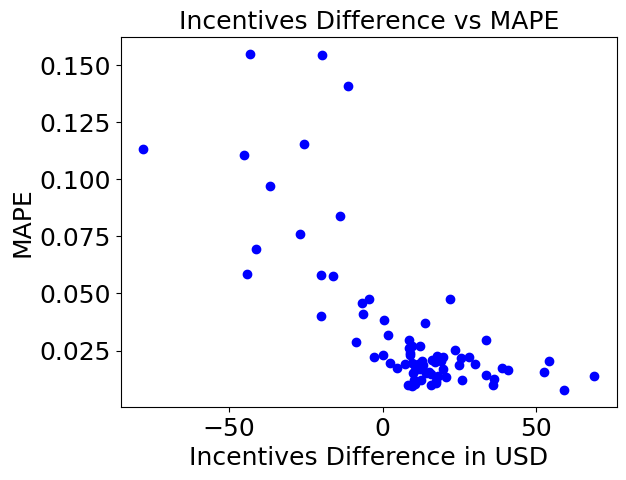

In [62]:
# Plot scatter plots for each period between incentives differences and errors
incentives = []
operators = []
mape = []
rmse = []
max_dev = []
for index,period in enumerate(op_data_periods_cl):
    
    for op in operator_names:
        if op in incentives_differences[period]:
            incentives.append(incentives_differences[period][op])
            mape.append(op_data_periods_cl[period]["mape"][op])
            rmse.append(op_data_periods_cl[period]["rmse"][op])
            max_dev.append(op_data_periods_cl[period]["maximum_deviation"][op])
            operators.append(op)
            
# Create a scatter plot for mape
plt.scatter(incentives, mape, color='blue', marker='o', label='Data Points')
# Add labels and title
plt.xlabel('Incentives Difference in USD')
plt.ylabel('MAPE')
plt.title('Incentives Difference vs MAPE')
# plt.savefig(deviation_threshold_dir_path+'/period'+str(index+1)+'_newincentivesdiffMAPE_corr.png', bbox_inches='tight')
# Show the plot
plt.show()
    

### Calculate the Spearman's Coefficient and the p-value for the relationship between percentage differences of incentives and the MAPE value

In [63]:
# Assuming you have two arrays: array1 and array2
correlation_coefficient, p_value = spearmanr(mape, incentives)
print("Spearman coefficient", correlation_coefficient)
print("p-value", p_value)

Spearman coefficient -0.6552563226247436
p-value 1.341304182445464e-10


### Plot a scatter plot showing the original incentives in USD against MAPE of all periods in one plot

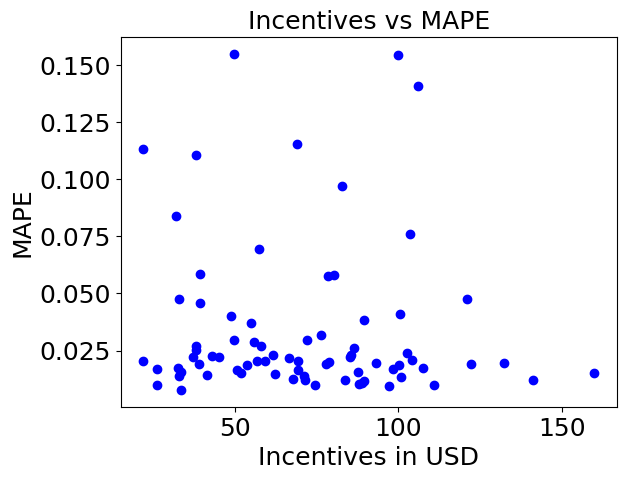

In [64]:
# Plot scatter plots for each period between incentives differences and errors
incentives = []
operators = []
mape = []
rmse = []
max_dev = []
for index,period in enumerate(op_data_periods_cl):
    
    for op in operator_names:
        if op in op_incentives_periods_usd[period]:
            incentives.append(op_incentives_periods_usd[period][op])
            mape.append(op_data_periods_cl[period]["mape"][op])
            rmse.append(op_data_periods_cl[period]["rmse"][op])
            max_dev.append(op_data_periods_cl[period]["maximum_deviation"][op])
            operators.append(op)
            
# Create a scatter plot for mape
plt.scatter(incentives, mape, color='blue', marker='o', label='Data Points')
# Add labels and title
plt.xlabel('Incentives in USD')
plt.ylabel('MAPE')
plt.title('Incentives vs MAPE')
# plt.savefig(deviation_threshold_dir_path+'/period'+str(index+1)+'_newincentivesdiffMAPE_corr.png', bbox_inches='tight')
# Show the plot
plt.show()
    

### Calculate the Spearman's Coefficient and the p-value for the relationship between original incentives in USD and the MAPE value

In [65]:
# Assuming you have two arrays: array1 and array2
correlation_coefficient, p_value = spearmanr(mape, incentives)
print("Spearman coefficient", correlation_coefficient)
print("p-value", p_value)

Spearman coefficient -0.12149673274393862
p-value 0.29578778550229695


### Plot a scatter plot showing the proposed incentives in USD against MAPE of all periods in one plot

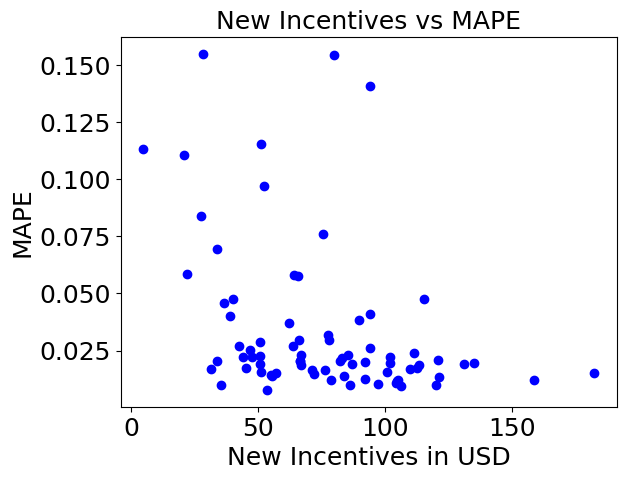

In [66]:
# Plot scatter plots for each period between incentives differences and errors
incentives = []
operators = []
mape = []
rmse = []
max_dev = []
for index,period in enumerate(op_data_periods_cl):
    
    for op in operator_names:
        if op in period_earnings_penalisation_scheme[period]:
            incentives.append(period_earnings_penalisation_scheme[period][op])
            mape.append(op_data_periods_cl[period]["mape"][op])
            rmse.append(op_data_periods_cl[period]["rmse"][op])
            max_dev.append(op_data_periods_cl[period]["maximum_deviation"][op])
            operators.append(op)
            

# Create a scatter plot for mape
plt.scatter(incentives, mape, color='blue', marker='o', label='Data Points')
# Add labels and title
plt.xlabel('New Incentives in USD')
plt.ylabel('MAPE')
plt.title('New Incentives vs MAPE')
plt.savefig(deviation_threshold_dir_path+'/allperiods_usdincvsmape_incentivisationmechanism.png', bbox_inches='tight')
# Show the plot
plt.show()
    

### Calculate the Spearman's Coefficient and the p-value for the relationship between proposed incentives in USD and the MAPE value

In [67]:
# Assuming you have two arrays: array1 and array2
correlation_coefficient, p_value = spearmanr(mape, incentives)
print("Spearman coefficient", correlation_coefficient)
print("p-value", p_value)

Spearman coefficient -0.424688995215311
p-value 0.00013147852366363693


### Plot a scatter plot showing the proposed incentives in LINK normalised by transmission counts against MAPE of all periods in one plot

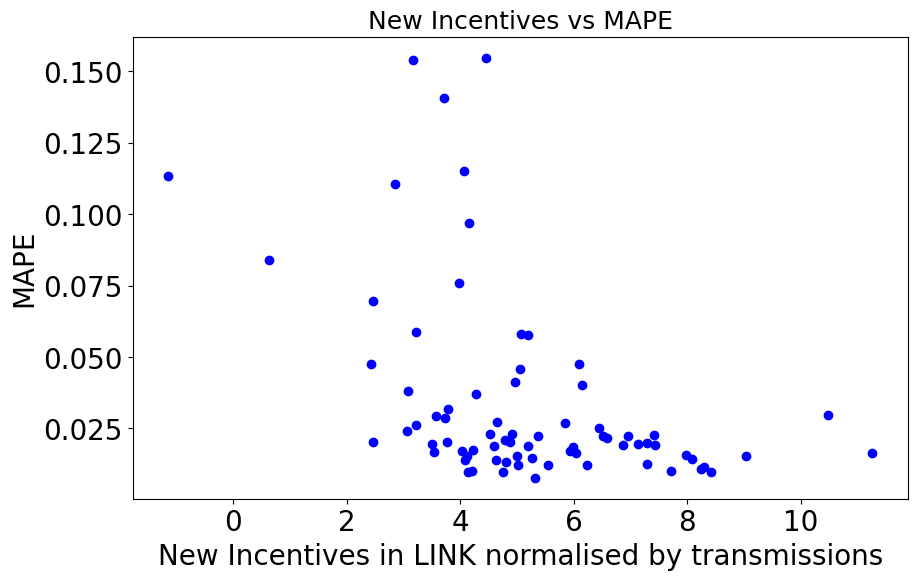

In [68]:
# Plot scatter plots for each period between incentives differences and errors
incentives = []
operators = []
mape = []
rmse = []
max_dev = []
for index,period in enumerate(op_data_periods_cl):
    
    for op in operator_names:
        if op in period_earnings_penalisation_scheme_link_normalised[period]:
            incentives.append(period_earnings_penalisation_scheme_link_normalised[period][op])
            mape.append(op_data_periods_cl[period]["mape"][op])
            rmse.append(op_data_periods_cl[period]["rmse"][op])
            max_dev.append(op_data_periods_cl[period]["maximum_deviation"][op])
            operators.append(op)
            

# Create a scatter plot for mape
plt.figure(figsize=(10, 6)) 
plt.rcParams['font.size'] = 20
plt.scatter(incentives, mape, color='blue', marker='o', label='Data Points')
# Add labels and title
plt.xlabel('New Incentives in LINK normalised by transmissions')
plt.ylabel('MAPE')
plt.title('New Incentives vs MAPE')
plt.savefig(deviation_threshold_dir_path+'/allperiods_linkincvsmape_incentivisationmechanism.png', bbox_inches='tight')
# Show the plot
plt.show()
    

### Calculate the Spearman's Coefficient and the p-value for the relationship between proposed incentives in normalised LINK and the MAPE value

In [69]:
# Assuming you have two arrays: array1 and array2
correlation_coefficient, p_value = spearmanr(mape, incentives)
print("Spearman coefficient", correlation_coefficient)
print("p-value", p_value)

Spearman coefficient -0.46627477785372523
p-value 2.1843798132086013e-05


# Testing the incentivisation method on the same feed on another network (Polygon)

Here we wll be implementing the incentivisation mechanism on the same feed on another network (Polygon) and we will be assessing whether the incentives reflect the performances in a better way. We will be using the same deviation threshold.

### Get all payments from 2023

In [59]:
# Load all payments to calculate incentives
path = "./data/polygon/mainnet/crypto-eth/"+feed
withdrawals = pd.read_csv(path+"/payments.csv")

# Keep only needed columns
withdrawals = withdrawals[["blockNumber", "txTimestamp", "submitter", "payeeAddress", "oracleName"]]

# Get all payee addresses
with open(path+'/nops.json', 'r') as json_file:
    nops = json.load(json_file)
    
payment_addresses = []
    
for nop in nops["nops_details"]:
    payment_addresses.extend(nops["nops_details"][nop]["paymentAddress"])
    

# Calculate date
withdrawals['txTimestamp'] = withdrawals['txTimestamp'] * 1000
withdrawals["date"] = pd.to_datetime(withdrawals['txTimestamp'], unit='ms', utc=True)
# Keep only when submitter is not a payee
withdrawals_by_not_payee = withdrawals[~withdrawals['submitter'].isin(payment_addresses)]

# Get unique withdrawal dates by Chainlink
unique_withdrawal_dates = withdrawals_by_not_payee["date"].unique()
target_year = pd.to_datetime('2023-01-01T00:00:00Z', utc=True)

# Find the first date in 2023
first_date_2023 = np.min(unique_withdrawal_dates[unique_withdrawal_dates >= target_year])

### Get all operator names on Polygon

In [60]:
# Get a list of all directory names in the specified directory
operator_names = [name for name in os.listdir(path+"/per_op") if os.path.isdir(os.path.join(path+"/per_op", name))]

### Load Chainlink aggregated Prices 
The below cell also does the following
* Calculate UTC date from timestamp

In [61]:
# Load prices from CL
cl_df = pd.read_csv(path+"/answers.csv")
cl_df["timestamp"] = cl_df["timestamp"] * 1000
cl_df["date"] = pd.to_datetime(cl_df['timestamp'], unit='ms', utc=True)
cl_df

Unnamed: 0      timestamp    answer                     txDate  \
0              0  1669857494000  0.005896  2022-12-01 01:18:14+00:00   
1              1  1669861845000  0.005867  2022-12-01 02:30:45+00:00   
2              2  1669864158000  0.005898  2022-12-01 03:09:18+00:00   
3              3  1669873314000  0.005869  2022-12-01 05:41:54+00:00   
4              4  1669879558000  0.005898  2022-12-01 07:25:58+00:00   
...          ...            ...       ...                        ...   
3561        3561  1692799273000  0.003818  2023-08-23 14:01:13+00:00   
3562        3562  1692800083000  0.003839  2023-08-23 14:14:43+00:00   
3563        3563  1692807663000  0.003819  2023-08-23 16:21:03+00:00   
3564        3564  1692810170000  0.003798  2023-08-23 17:02:50+00:00   
3565        3565  1692823083000  0.003779  2023-08-23 20:38:03+00:00   

                          date  
0    2022-12-01 01:18:14+00:00  
1    2022-12-01 02:30:45+00:00  
2    2022-12-01 03:09:18+00:00  
3    2022-12-01 05:41:54+00:00  
4    2022-12-01 07:25:58+00:00  
...                        ...  
3561 2023-08-23 14:01:13+00:00  
3562 2023-08-23 14:14:43+00:00  
3563 2023-08-23 16:21:03+00:00  
3564 2023-08-23 17:02:50+00:00  
3565 2023-08-23 20:38:03+00:00  

[3566 rows x 5 columns]

### Calculate each operator's performances

Just as we calculated the deviations between Chainlink's prices and Binance's prices, we will now calculate deviation metrics for each operator from Chainlink's aggregated prices

For each operator we will be calculating the following against Chainlink's aggregated prices:
* Mean Absolute Percentage Error
* Root Mean Square Error
* Maximum Deviation
* Missed submissions
* Completed submissions
* Completed transmissions

In [62]:
# Compute each operator's mape, rsme and max deviation averages and missed submissions against Chainlink's aggregated oruces
op_data_error_metrics = {
    "mape": {},
    "rmse": {},
    "maximum_deviation": {},
    "missed_submissions": {},
    "completed_submissions": {},
    "completed_transmissions": {}
}

# Load all transmissions
all_transmissions = pd.read_csv(path+"/transmissions.csv")
all_transmissions["timestamp"] = all_transmissions["timestamp"] * 1000
all_transmissions["date"] = pd.to_datetime(all_transmissions['timestamp'], unit='ms', utc=True)
all_transmissions = all_transmissions.fillna(0)

for op in operator_names:
    # Get submissions CSV
    op_submissions = pd.read_csv(path+"/per_op/"+op+"/submissions.csv")
    op_submissions = op_submissions[["timestamp", op+"_answer"]]
    op_submissions.rename(columns={op+"_answer": 'answer'}, inplace=True)
    op_submissions["answer"] = op_submissions["answer"] / (10 ** decimals)
    op_submissions['timestamp'] = op_submissions['timestamp'] * 1000
    op_submissions["date"] = pd.to_datetime(op_submissions['timestamp'], unit='ms', utc=True)
    op_submissions = op_submissions.dropna(subset=["answer"])
    # Keep only rows in given period
    op_submissions = op_submissions[(op_submissions['date'] >= first_date_2023)]

    if len(op_submissions) > 0:

        # Get only transmissions in the period
        transmissions_in_period = all_transmissions[(all_transmissions['date'] >= first_date_2023)]
        # Count missed submissions
        missed_submissions = len(transmissions_in_period[transmissions_in_period[op+"_answer"] == 0])
        # Count submissions
        completed_submissions = len(transmissions_in_period[transmissions_in_period[op+"_answer"] != 0])

        # Count transmissions
        completed_transmissions = 0;
        # Loop through submissions
        for index, row in transmissions_in_period.iterrows():
            submitter = row["submitter"]
            if op == nops["nops_details"][submitter.lower()]["name"]:
                completed_transmissions += 1


        # Merge with Chainlink's aggregated prices
        op_merged_df_cl = pd.merge_asof(op_submissions, cl_df, on='timestamp', suffixes=('_operator', '_cl'))
        op_merged_df_cl = op_merged_df_cl[["timestamp", "answer_operator", "answer_cl"]]
        op_merged_df_cl["answer_operator"] = op_merged_df_cl["answer_operator"].astype(float)
        op_merged_df_cl["answer_cl"] = op_merged_df_cl["answer_cl"].astype(float)
        op_merged_df_cl['percentage_change'] = (abs(op_merged_df_cl['answer_operator'] - op_merged_df_cl['answer_cl']) / op_merged_df_cl['answer_cl']) * 100
        op_merged_df_cl["date"] = pd.to_datetime(op_merged_df_cl['timestamp'], unit='ms', utc=True)
        op_merged_df_cl.set_index('date', inplace=True)

        # Calculate data for oeprators submissions against Chainlink's prices
        op_data_error_metrics["mape"][op] = calculate_mape(op_merged_df_cl['answer_operator'], op_merged_df_cl['answer_cl'])
        op_data_error_metrics["rmse"][op] =  np.sqrt(mean_squared_error(op_merged_df_cl['answer_operator'], op_merged_df_cl['answer_cl']))
        op_data_error_metrics["maximum_deviation"][op] =  op_merged_df_cl['percentage_change'].max()
        op_data_error_metrics["missed_submissions"][op] = missed_submissions
        op_data_error_metrics["completed_submissions"][op] = completed_submissions
        op_data_error_metrics["completed_transmissions"][op] = completed_transmissions

### Calculate operators' incentives in USD

In [63]:
# Calculating incentives per period for operators
op_incentives = {}
op_incentives_link = {}

# Get link prices for all payment dates
path = "./data/polygon/mainnet/crypto-eth/"+feed
all_payments = pd.read_csv(path+"/payments.csv")
all_payments['txTimestamp'] = all_payments['txTimestamp'] * 1000
all_payments["date"] = pd.to_datetime(all_payments['txTimestamp'], unit='ms', utc=True)
all_payments = all_payments[(all_payments['date'] >= first_date_2023)]

# Get heights of payments to get link-usd prices at thise heights
link_heights = all_payments["blockNumber"].unique()

link_usd_contract_address = feeds["polygon/mainnet/link-usd"]["address"]

with open('abi/polygon_aggregator_abi.json', 'r') as file:
    contract_abi = json.load(file)
    
feed_path = "polygon/mainnet/crypto-eth/"+feed
provider_url_archive_polygon = config["polygon"]["providerUrlArchive"]

w3_archive_polygon = Web3(Web3.HTTPProvider(provider_url_archive_polygon))
link_prices = get_prices_for_blocknumbers(w3_archive_polygon, link_usd_contract_address, contract_abi, link_heights, "link-usd", feed_path)
        
for op in operator_names:
    # Get payments CSV
    op_payments = pd.read_csv(path+"/per_op/"+op+"/payments.csv")
    op_payments['txTimestamp'] = op_payments['txTimestamp'] * 1000
    op_payments["date"] = pd.to_datetime(op_payments['txTimestamp'], unit='ms', utc=True)
    op_payments["blockNumber"] = op_payments["blockNumber"].astype(str)
    op_payments["linkPrice"] = op_payments["blockNumber"].map(link_prices)
    op_payments["usdAmount"] = op_payments["linkPrice"] * op_payments["amount"]
    op_payments = op_payments[op_payments['date'] > first_date_2023]
    # Get link prices per block
    amount_paid = op_payments["usdAmount"].sum()
    op_incentives_link[op] = op_payments["amount"].sum()
    if amount_paid > 0:
        op_incentives[op] = amount_paid
        
op_incentives

Got price 0/35
Got price 1/35
Got price 2/35
Got price 3/35
Got price 4/35
Got price 5/35
Got price 6/35
Got price 7/35
Got price 8/35
Got price 9/35
Got price 10/35
Got price 11/35
Got price 12/35
Got price 13/35
Got price 14/35
Got price 15/35
Got price 16/35
Got price 17/35
Got price 18/35
Got price 19/35
Got price 20/35
Got price 21/35
Got price 22/35
Got price 23/35
Got price 24/35
Got price 25/35
Got price 26/35
Got price 27/35
Got price 28/35
Got price 29/35
Got price 30/35
Got price 31/35
Got price 32/35
Got price 33/35
Got price 34/35


{'vulcan_link': 10.396061557791478,
 'linkriver': 13.445924210501099,
 'cryptomanufaktur': 15.824285171713454,
 'linkforest': 12.158439681389755,
 'staking_facilities': 12.012616189587638,
 'inotel': 13.335046958639069,
 'linkpool': 15.409876100334046,
 'snzpool': 20.25682276541731,
 'dextrac': 12.514209691093782,
 '01node': 1.1592911862987945,
 'fiews': 19.964403209833883,
 'b_harvest': 14.108229160840521,
 'newroad_network': 13.571222422437435,
 'chainlayer': 14.677444194813233,
 'pier_two': 12.41686136648701,
 'simply_vc': 11.855177144943438}

In [64]:
op_incentives_link

{'vulcan_link': 1.5406632468026549,
 'linkriver': 2.008678496123166,
 'cryptomanufaktur': 2.362123698655979,
 'linkforest': 1.753187725747579,
 'staking_facilities': 1.7553815854672399,
 'inotel': 1.950360435141643,
 'linkpool': 2.238098540685108,
 'snzpool': 3.1613954568642746,
 'dextrac': 1.812319122182822,
 '01node': 0.18727798917301,
 'fiews': 3.131078639871932,
 'b_harvest': 2.063207564394525,
 'newroad_network': 2.0274938675741137,
 'chainlayer': 2.2004762491673873,
 'pier_two': 1.790451226635561,
 'simply_vc': 1.759872243577721}

### Plot a scatter plot showing the original incentives in USD normalised by transmission counts against MAPE of all periods in one plot

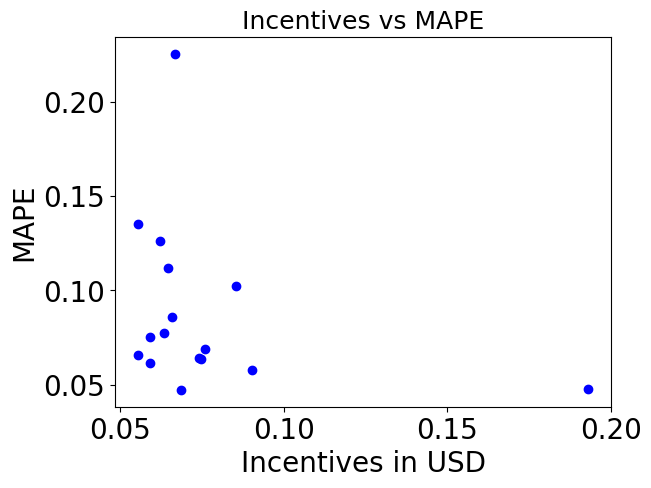

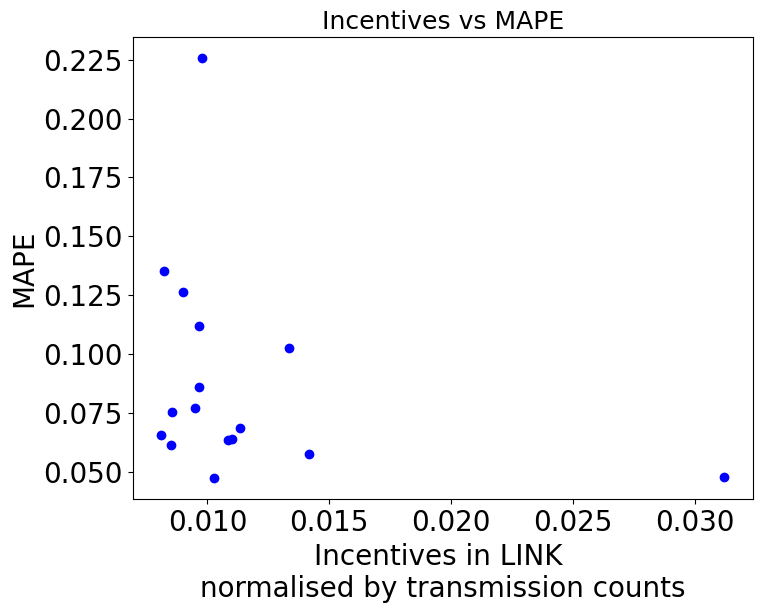

In [65]:
# Plot scatter plots for each period between incentives differences and errors
original_incentives = []
original_incentives_link = []
operators = []
mape = []
rmse = []
max_dev = []
    
for op in operator_names:
    if op in op_incentives and op_data_error_metrics["completed_transmissions"][op] > 0:
        original_incentives.append(op_incentives[op]/float(op_data_error_metrics["completed_transmissions"][op]))
        original_incentives_link.append(op_incentives_link[op]/float(op_data_error_metrics["completed_transmissions"][op]))
        mape.append(op_data_error_metrics["mape"][op])
        rmse.append(op_data_error_metrics["rmse"][op])
        max_dev.append(op_data_error_metrics["maximum_deviation"][op])
        operators.append(op)
            
# Create a scatter plot for mape
plt.scatter(original_incentives, mape, color='blue', marker='o', label='Data Points')
# Add labels and title
plt.xlabel('Incentives in USD')
plt.ylabel('MAPE')
plt.title('Incentives vs MAPE')
plt.savefig(deviation_threshold_dir_path+'/original_validation_corr.png', bbox_inches='tight')
# Show the plot
plt.show()
    
# Create a scatter plot for mape
plt.figure(figsize=(8, 6)) 
plt.rcParams['font.size'] = 20
plt.scatter(original_incentives_link, mape, color='blue', marker='o', label='Data Points')
# Add labels and title
plt.xlabel('Incentives in LINK \nnormalised by transmission counts')
plt.ylabel('MAPE')
plt.title('Incentives vs MAPE')
plt.savefig(deviation_threshold_dir_path+'/original_validationLINK_corr.png', bbox_inches='tight')
# Show the plot
plt.show()

### Calculate the Spearman's Coefficient and the p-value for the relationship between percentage differences of incentives and the MAPE value

In [66]:
# Assuming you have two arrays: array1 and array2
correlation_coefficient, p_value = spearmanr(mape, original_incentives_link)
print("Spearman coefficient", correlation_coefficient)
print("p-value", p_value)

Spearman coefficient -0.38235294117647056
p-value 0.14385924954389048


### Calculate incentives by simulating the penalisation scheme

This is done by going over each submission and calculating its deviation from the aggregated answer. If the submission's deviation exceeds the deviation threshold, it is considered as an operator's misbehvaiour. This operator is penalised and the penalty amount is split amongst operators whose submission was within the acceptable thresholds for that round.

In [67]:
# Get all withdrawal block numbers, not only those done by Chainlink but also done by operators themselves
unique_withdrawal_blocks = withdrawals["blockNumber"].unique()
# Get billing params
billing_params_filename = "data/polygon/mainnet/crypto-eth/"+feed+"/billing_params.json"
with open(billing_params_filename, 'r') as file:
    billing_params = json.load(file)

# Get billing params per withdrawal block
billing_params_per_withdrawal_block = {}
for block in unique_withdrawal_blocks:
    billing_params_per_withdrawal_block[block] = get_block_billing(block, billing_params)
    
# Calculate earnings per period
earnings_penalisation_scheme = {}
earnings_penalisation_scheme_normalised = {}
earnings_penalisation_scheme_normalised_link = {}
operator_extra_incentives = {}
operator_extra_incentives_link = {}

# Keep amounts of misbehaviours per period
misbehaviours = {}

for op in operator_names:
    print(op)
    
    op_addr = get_op_addr(nops,op)
    # Get operators transmission counts
    
    transmissions_period = all_transmissions[(all_transmissions['date'] >= first_date_2023)]
    op_transmissions_counts = transmissions_period[transmissions_period['submitter'] == op_addr]

    # Get submissions CSV
    op_submissions = pd.read_csv(path+"/per_op/"+op+"/submissions.csv")
    op_submissions.rename(columns={op+"_answer": 'answer'}, inplace=True)
    op_submissions['timestamp'] = op_submissions['timestamp'] * 1000
    op_submissions["date"] = pd.to_datetime(op_submissions['timestamp'], unit='ms', utc=True)
    op_submissions = op_submissions.dropna(subset=["answer"])
    # Keep only rows from 2023
    op_submissions = op_submissions[(op_submissions['date'] >= first_date_2023)]
    
    # Get payments from 2023
    op_payments = pd.read_csv(path+"/per_op/"+op+"/payments.csv")
    op_payments['txTimestamp'] = op_payments['txTimestamp'] * 1000
    op_payments["date"] = pd.to_datetime(op_payments['txTimestamp'], unit='ms', utc=True)
    op_payments["blockNumber"] = op_payments["blockNumber"].astype(str)
    op_payments["linkPrice"] = op_payments["blockNumber"].map(link_prices)
    op_payments["usdAmount"] = op_payments["linkPrice"] * op_payments["amount"]
    op_payments = op_payments[(op_payments['date'] > first_date_2023)]
    # Get link prices per block
    amount_paid = op_payments["usdAmount"].sum()
    amount_paid_link = op_payments["amount"].sum()
    # If there were payments made

    penalty = 0
    reduce_rewards = 0
    reduce_rewards_link = 0

    if amount_paid > 0:
        last_date = ""
        # Loop through each withdrawal and get submissions until that date to calculate errors
        for withdrawal_index, withdrawal_row in op_payments.iterrows():
            withdrawal_date = withdrawal_row["date"]

            # Get billing params at date
            reward_rate = (billing_params_per_withdrawal_block[int(withdrawal_row["blockNumber"])]["linkGweiPerObservation"] / 1000000000.0) * withdrawal_row["linkPrice"]
            reward_rate_link = (billing_params_per_withdrawal_block[int(withdrawal_row["blockNumber"])]["linkGweiPerObservation"] / 1000000000.0)
            
            # if there was no previous date
            if last_date == "":
                op_submissions_withdrawal = op_submissions[op_submissions['date'] <= withdrawal_date]
            else: 
                op_submissions_withdrawal = op_submissions[(op_submissions['date'] > last_date) & (op_submissions['date'] <= withdrawal_date)]

            # Holds operator misbehaviours
            op_misbehaviours = 0
            # Loop through submissions during withdrawal to find misbehaviours
            for submission_index, submission_row in op_submissions_withdrawal.iterrows():
                upper_limit = submission_row["aggregatedAnswer"] * (1+deviation_threshold)
                lower_limit = submission_row["aggregatedAnswer"] * (1-deviation_threshold)
                operator_deviation = (abs(submission_row["answer"] - submission_row["aggregatedAnswer"]) / submission_row["aggregatedAnswer"]) * 100
                # if deviated more than threshold
                if operator_deviation > deviation_threshold:
                    op_misbehaviours += 1
                    # Get correct operators
                    correct_oracles = [col for col in submission_row.index if col.endswith('_answer') and submission_row[col] <= upper_limit and submission_row[col] >= lower_limit]
                    correct_oracles = [element[:-7] for element in correct_oracles]
                    # For each correct oracle, add extra incentive
                    for correct_oracle in correct_oracles:
                        # Extra incentive is the penalty amount divided by the correct operators
                        if not (correct_oracle in operator_extra_incentives):
                            operator_extra_incentives[correct_oracle] = 0
                        if not (correct_oracle in operator_extra_incentives_link):
                            operator_extra_incentives_link[correct_oracle] = 0
                        operator_extra_incentives[correct_oracle] += (reward_rate * 3) / float(len(correct_oracles))
                        operator_extra_incentives_link[correct_oracle] += (reward_rate_link * 3) / float(len(correct_oracles))
                        

            misbehaviours[op] = (op_misbehaviours / len(op_submissions_withdrawal)) * 100
            # Calculate penalty by multiplying reward_rate * 2 * operator_misbehaviours
            penalty += reward_rate * 2 * op_misbehaviours
            # We also need this to reduce the incentive given for these submissions before
            reduce_rewards += reward_rate * op_misbehaviours
            reduce_rewards_link += reward_rate_link * 3 * op_misbehaviours

        earnings_penalisation_scheme[op] = amount_paid - (penalty + reduce_rewards)
        earnings_penalisation_scheme_normalised[op] = amount_paid - (penalty + reduce_rewards)
        earnings_penalisation_scheme_normalised_link[op] = amount_paid_link - reduce_rewards_link

# For each oracle, add extra incentives
for operator_name in operator_extra_incentives:
    if operator_name in earnings_penalisation_scheme:
        earnings_penalisation_scheme[operator_name] += operator_extra_incentives[operator_name]
        earnings_penalisation_scheme_normalised[operator_name] += operator_extra_incentives[operator_name]
        earnings_penalisation_scheme_normalised_link[operator_name] += operator_extra_incentives_link[operator_name]
        

vulcan_link
LINK vulcan_link 1.5406632468026549 1.3219672199999999 1.2391e-05 1750
USD vulcan_link 10.396061557791478 9.015891291728412 7.67029652169e-05 1750
linkriver
LINK linkriver 2.008678496123166 1.528444023 1.2391e-05 1746
USD linkriver 13.445924210501099 10.374394703238925 7.67029652169e-05 1746
cryptomanufaktur
LINK cryptomanufaktur 2.362123698655979 1.2663413880000003 1.2391e-05 1158
USD cryptomanufaktur 15.824285171713454 8.61878025442677 7.67029652169e-05 1158
linkforest
LINK linkforest 1.753187725747579 1.202445912 1.2391e-05 1272
USD linkforest 12.158439681389755 8.187394008258021 7.67029652169e-05 1272
staking_facilities
LINK staking_facilities 1.7553815854672399 1.247089701 1.2391e-05 1220
USD staking_facilities 12.012616189587638 8.4847236480733 7.67029652169e-05 1220
inotel
LINK inotel 1.950360435141643 1.614029418 1.2391e-05 1450
USD inotel 13.335046958639069 10.961687783665768 7.67029652169e-05 1450
linkpool
LINK linkpool 2.238098540685108 1.0599579209999999 1.2391e

In [68]:
earnings_penalisation_scheme_normalised_link

{'vulcan_link': 1.508171794240741,
 'linkriver': 1.7548742863078215,
 'cryptomanufaktur': 2.3912255210566573,
 'linkforest': 1.851382598777217,
 'staking_facilities': 1.806550148166557,
 'inotel': 1.6096494478911043,
 'linkpool': 2.486820781223991,
 'snzpool': 2.6732794465725602,
 'dextrac': 1.358794600437439,
 '01node': 0.18757944450158145,
 'fiews': 3.385111573174399,
 'b_harvest': 0.7748088686346122,
 'newroad_network': 2.029623430491786,
 'chainlayer': 2.6170388601594117,
 'pier_two': 1.8869494425768378,
 'simply_vc': 2.064118459177843}

In [69]:
earnings_penalisation_scheme

{'vulcan_link': 10.15172342628839,
 'linkriver': 11.745534116621604,
 'cryptomanufaktur': 16.01843289038173,
 'linkforest': 12.819097956024308,
 'staking_facilities': 12.3601522552411,
 'inotel': 11.037222328014645,
 'linkpool': 17.104550464707636,
 'snzpool': 16.920871026267296,
 'dextrac': 9.394857107738883,
 '01node': 1.161157259866857,
 'fiews': 21.688836373225904,
 'b_harvest': 5.420524514548754,
 'newroad_network': 13.564912835197553,
 'chainlayer': 17.499619744965383,
 'pier_two': 13.080104662874335,
 'simply_vc': 13.914303867551697}

### Plot the number of misbehaviours and the differences between the original incentives and the incentives after the introduction of the proposed penalisation scheme

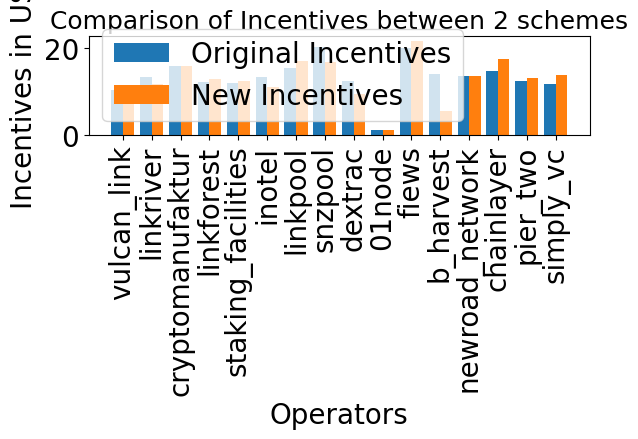

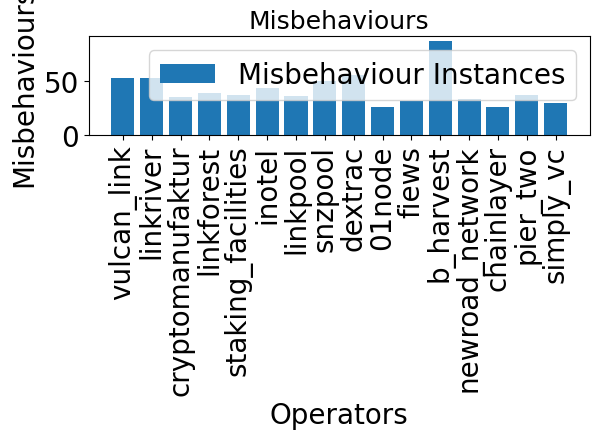

In [70]:
traditional_incentives = op_incentives
penalisation_scheme_incentives = earnings_penalisation_scheme

# Extract names and values
operators = list(op_incentives.keys())
values_ti = list(traditional_incentives.values())
values_pi = [penalisation_scheme_incentives[op] if op in traditional_incentives else 0 for op in operators]

# Create positions for bars
x = range(0, len(operators))
# Create the bar graph
plt.bar(x, values_ti, width=0.4, label='Original Incentives')
plt.bar([pos + 0.4 for pos in x], values_pi, width=0.4, label='New Incentives')

# Add labels and title
plt.xlabel('Operators')
plt.xticks(rotation=90)
plt.ylabel('Incentives in USD')
plt.title('Comparison of Incentives between 2 schemes')
plt.xticks([pos + 0.2 for pos in x], operators)
plt.legend()
plt.savefig(deviation_threshold_dir_path+'/validation_inccomparison.png', bbox_inches='tight')
plt.tight_layout()
plt.show()


x = range(0, len(operators))
values = list(misbehaviours.values())
plt.bar(x, values, label='Misbehaviour Instances')
plt.xlabel('Operators')
plt.xticks(rotation=90)
plt.ylabel('Misbehaviours')
plt.title('Misbehaviours')
plt.xticks(x, operators)
plt.legend()
plt.savefig(deviation_threshold_dir_path+'/validation__misbehaviours.png', bbox_inches='tight')
plt.tight_layout()
plt.show()


### Plot a scatter plot showing the proposed incentives in USD normalised by the transmission counts against MAPE of all periods in one plot

The reason for normalising by the transmission counts is that operators earn additional costs for transmissions and an operator with a few transmissions may have low incentives. Therefore, it is fair to compare operators with normalised incentives on transmission counts

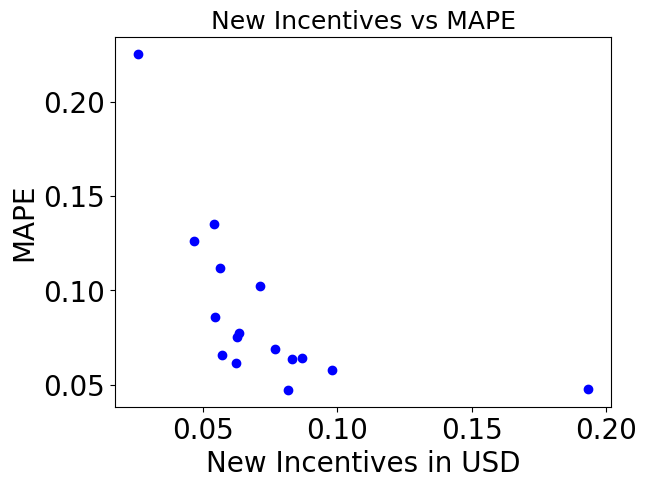

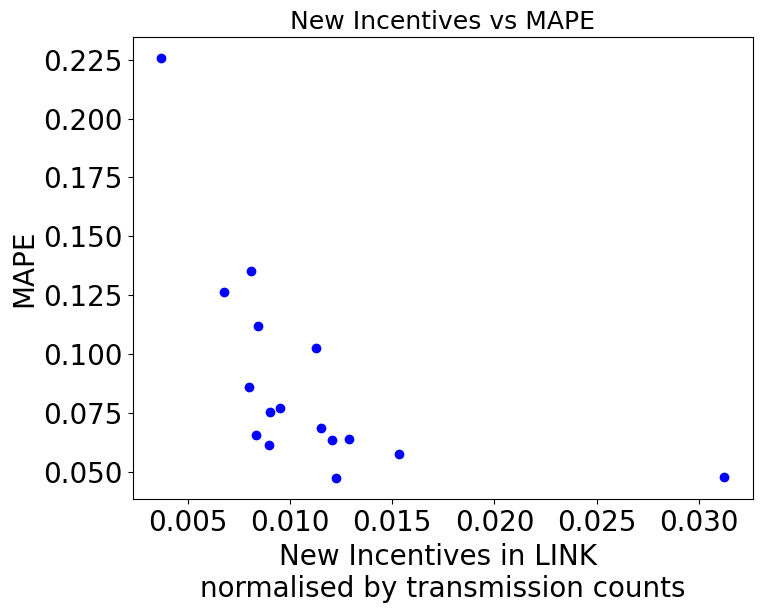

In [71]:
# Plot scatter plots for each period between incentives differences and errors
incentives = []
incentives_link = []
operators = []
mape = []
rmse = []
max_dev = []
    
for op in operator_names:
    if op in earnings_penalisation_scheme:
        incentives.append(earnings_penalisation_scheme[op]/float(op_data_error_metrics["completed_transmissions"][op]))
        incentives_link.append(earnings_penalisation_scheme_normalised_link[op]/float(op_data_error_metrics["completed_transmissions"][op]))
        mape.append(op_data_error_metrics["mape"][op])
        rmse.append(op_data_error_metrics["rmse"][op])
        max_dev.append(op_data_error_metrics["maximum_deviation"][op])
        operators.append(op)
            

# Create a scatter plot for mape
# plt.scatter(orginal_incentives, mape, color='red', marker='o', label='Data Points')
plt.scatter(incentives, mape, color='blue', marker='o', label='Data Points')
# Add labels and title
plt.xlabel('New Incentives in USD')
plt.ylabel('MAPE')
plt.title('New Incentives vs MAPE')
plt.savefig(deviation_threshold_dir_path+'/validation_newincentives_corr.png', bbox_inches='tight')
# Show the plot
plt.show()

# Create a scatter plot for mape
plt.figure(figsize=(8, 6)) 
plt.rcParams['font.size'] = 20
plt.scatter(incentives_link, mape, color='blue', marker='o', label='Data Points')
# Add labels and title
plt.xlabel('New Incentives in LINK \nnormalised by transmission counts')
plt.ylabel('MAPE')
plt.title('New Incentives vs MAPE')
plt.savefig(deviation_threshold_dir_path+'/validation_newincentivesLINK_corr.png', bbox_inches='tight')
# Show the plot
plt.show()
    

### Calculate the Spearman's Coefficient and the p-value for the relationship between proposed incentives in USD and the MAPE value

In [72]:
# Assuming you have two arrays: array1 and array2
correlation_coefficient, p_value = spearmanr(mape, incentives_link)
print("Spearman coefficient", correlation_coefficient)
print("p-value", p_value)

Spearman coefficient -0.8058823529411765
p-value 0.00016384666473672616


In [73]:
misbehaviours

{'vulcan_link': 53.304904051172706,
 'linkriver': 53.102189781021906,
 'cryptomanufaktur': 35.21897810218978,
 'linkforest': 38.66261398176292,
 'staking_facilities': 37.07079914919477,
 'inotel': 44.099756690997566,
 'linkpool': 36.52676399026764,
 'snzpool': 50.426569165143206,
 'dextrac': 55.55555555555556,
 '01node': 25.925925925925924,
 'fiews': 31.66058394160584,
 'b_harvest': 87.43119266055047,
 'newroad_network': 33.42449103615922,
 'chainlayer': 25.6838905775076,
 'pier_two': 37.02686202686203,
 'simply_vc': 29.85622514530438}

In [74]:
op_data_error_metrics["completed_transmissions"]

{'vulcan_link': 187,
 'linkriver': 208,
 'cryptomanufaktur': 208,
 'linkforest': 205,
 'staking_facilities': 217,
 'inotel': 202,
 'linkpool': 206,
 'snzpool': 237,
 'dextrac': 201,
 '01node': 6,
 'fiews': 221,
 'b_harvest': 211,
 'newroad_network': 214,
 'chainlayer': 214,
 'pier_two': 210,
 'simply_vc': 160}